In [1]:
# Import necessary librarie

import warnings

warnings.filterwarnings('ignore')

import datetime

import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from pandas.tseries.offsets import BDay

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix

import pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

## Data Wrangling

In [2]:
# Download the data for the stocks
data = pd.ExcelFile('stock_prices.xlsx')

In [3]:
# Get the sheet names to download the sotck prices in different data frames
data.sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [4]:
# Define a function to read the stock information, get the price column and rename to the stock + Price name

def read_stock(n, col_name):
    df = pd.DataFrame(data.parse(data.sheet_names[n])[['Date','Price']]).rename(columns = {'Price': col_name})
    df = df.iloc[:-1, :]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='ignore')
    df = df.set_index('Date')
    return df

In [5]:
# Use the function for the different stock prices

S_stock = read_stock(n = 0, col_name = 'S_Price')
KCHOL_stock = read_stock(n = 1, col_name = 'KCHOL_Price')
M_stock = read_stock(n = 2, col_name = 'M_Price')
BEEF_stock = read_stock(n = 3, col_name = 'BEEF_Price')
P_stock = read_stock(n = 4, col_name = 'P_Price')
C_stock = read_stock(n = 5, col_name = 'C_Price')
IP_stock = read_stock(n = 6, col_name = 'IP_Price')
DS_stock = read_stock(n = 7, col_name = 'DS_Price')

In [6]:
# Define a function to merge the different data frames

def merge_df(df1, df2, df3, df4, df5, df6, df7, df8):
    df = [df1, df2, df3, df4, df5, df6, df7, df8]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'left', on = 'Date'), df)

In [7]:
# Merge he data frames

stock_prices = merge_df(df1 = S_stock, df2 = KCHOL_stock, df3 = M_stock, df4 = BEEF_stock, df5 = P_stock, 
                        df6 = C_stock, df7 = IP_stock, df8 = DS_stock)

In [8]:
# Sort the index to have the dates in ascending order

stock_prices = stock_prices.sort_index()

In [9]:
# Check out the NaN Values

for col in stock_prices:
    print(col)
    print(stock_prices[col].isna().sum())

S_Price
0
KCHOL_Price
9
M_Price
77
BEEF_Price
13
P_Price
22
C_Price
20
IP_Price
10
DS_Price
14


In [10]:
# Fill the NaN values with forward filling

stock_prices_daily = stock_prices.fillna(method = 'ffill')

stock_prices_daily['M_Price'] = stock_prices['M_Price'].fillna(method = 'bfill')

# Normalize the data to have prices between 0-1 (different currencies)

stock_prices_daily_normalized = stock_prices_daily.div(stock_prices_daily.max())

In [11]:
# Resample the data weekly and monthly and do the same for the normalized data

stock_prices_weekly = stock_prices_daily.resample('W').mean()
stock_prices_weekly_normalized = stock_prices_daily_normalized.resample('W').mean()

stock_prices_monthly = stock_prices_daily.resample('M').mean()
stock_prices_monthly_normalized = stock_prices_daily_normalized.resample('M').mean()

In [12]:
# Calculate the returns for daily, weekly and monthly 

stock_returns_daily = stock_prices_daily.pct_change().dropna()

stock_returns_weekly = stock_prices_weekly.pct_change().dropna()

stock_returns_monthly = stock_prices_monthly.pct_change().dropna()

In [13]:
# Multi Period Return

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

stock_returns_daily_pr = stock_returns_daily.rolling('360D').apply(multi_period_return)

In [14]:
# See the first rows for stock returns daily

stock_returns_daily.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-01-06 -0.004314    -0.010837  0.000000   -0.000775 -0.006148  0.000000   
2020-01-08  0.020677    -0.006972  0.030374    0.057409 -0.041237 -0.017143   
2020-01-09 -0.004476     0.024072  0.047619   -0.015407  0.036559 -0.010174   
2020-01-10  0.000775     0.005877  0.025974   -0.004471 -0.002075 -0.005874   
2020-01-13  0.016306     0.012658  0.000000    0.089820 -0.010395 -0.016248   

            IP_Price  DS_Price  
Date                            
2020-01-06 -0.015024 -0.028814  
2020-01-08  0.045828 -0.052356  
2020-01-09 -0.016939  0.011050  
2020-01-10 -0.007784  0.001821  
2020-01-13 -0.010862  0.003636

In [15]:
# See the first rows for stock returns weekly

stock_returns_weekly.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-01-12  0.009049    -0.002709  0.054322    0.032946 -0.019980 -0.019286   
2020-01-19  0.008731     0.030575  0.064598    0.099437 -0.016414 -0.035397   
2020-01-26  0.024912     0.015146 -0.028310   -0.023754  0.002976  0.000604   
2020-02-02 -0.035809    -0.054958  0.000857   -0.168508 -0.035184 -0.016601   
2020-02-09 -0.008944    -0.005995  0.006421    0.001009  0.032293 -0.010129   

            IP_Price  DS_Price  
Date                            
2020-01-12  0.008135 -0.061441  
2020-01-19 -0.007922 -0.003521  
2020-01-26 -0.024533 -0.009786  
2020-02-02 -0.046765 -0.071925  
2020-02-09  0.064895  0.004536

In [16]:
# See the first rows for stock returns monthly

stock_returns_monthly.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-02-29 -0.035158    -0.052227 -0.018411   -0.115723 -0.065941 -0.093874   
2020-03-31 -0.208611    -0.233035 -0.288244   -0.272670 -0.125974 -0.364742   
2020-04-30 -0.029628    -0.017621 -0.087966    0.116947  0.102754  0.001470   
2020-05-31  0.002142     0.036267 -0.113204    0.373662  0.225149 -0.074671   
2020-06-30  0.087484     0.143947  0.019610   -0.020883 -0.053766  0.007810   

            IP_Price  DS_Price  
Date                            
2020-02-29  0.051736 -0.052666  
2020-03-31 -0.395876 -0.262213  
2020-04-30  0.105588  0.040225  
2020-05-31  0.098673  0.034586  
2020-06-30  0.076068  0.473359

## Data Visualization

In [17]:
# Plot how the prices have been moving during time

def plot_prices(df):
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc = (1.02,0))
    return plt.show()

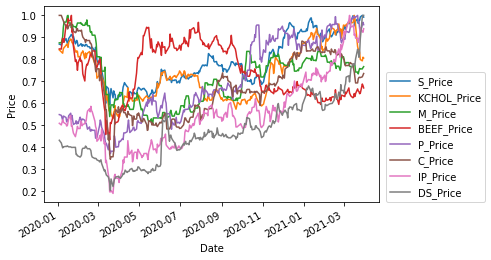

In [18]:
# Plot daily prices

plot_prices(df = stock_prices_daily_normalized)

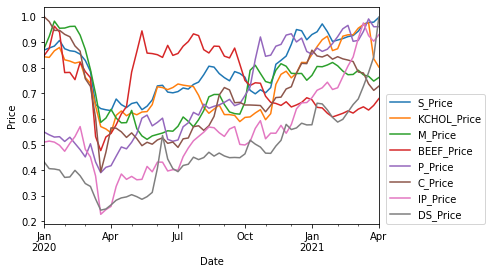

In [19]:
# Plot weekly prices

plot_prices(df = stock_prices_weekly_normalized)

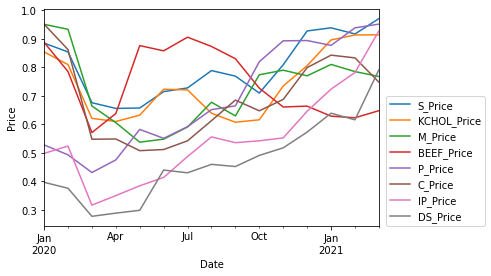

In [20]:
# Plot monthly prices

plot_prices(df = stock_prices_monthly_normalized)

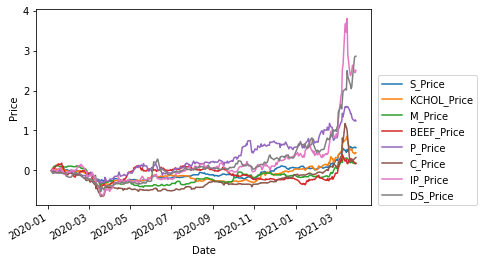

In [21]:
# Plot multiperiod return

plot_prices(df = stock_returns_daily_pr)


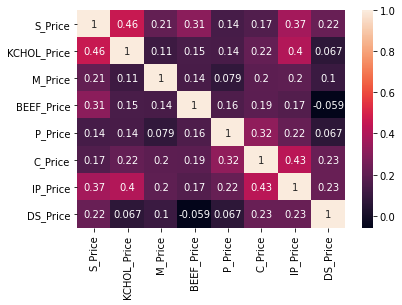

In [22]:
# Plot a correlation heatmap among all the stocks

corr_matrix = stock_returns_daily.corr()

# Plot the heatmap

sns.heatmap(corr_matrix, annot = True)
plt.show()

## Feature Engineering

In [23]:
# Define a function to use MaxMin Scaler for the modeling part

def scaler(train_array, test_array):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    return X, y

In [24]:
# Define a function to calculate the real price of the stock based on the MinMax Scaler

def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    y_inverse = scaler.inverse_transform(predictions)
    return y_inverse

In [25]:
# Define a function to have the previous 5 days as independant features to predict the stock price

def preprocessing(dataset, time_steps = 1):
    X, y = [], []
    for i in range(len(dataset) - time_steps - 1):
        x = dataset[i:(i + time_steps), 0]
        X.append(x)
        y.append(dataset[i + time_steps, 0])
    return X, y

In [26]:
# Divide the train and test data

train = stock_prices_daily['2020']
test = stock_prices_daily['2021']

In [27]:
# Define an empty array to change the shape of the X variable (train and test)
# The new shape with treat the stock prices as each of the subarrays
# Eight stocks mean an array with shape (8, n_days)

n_days = len(stock_prices_daily)

# Define number of stocks

n_stocks = len(stock_prices_daily.columns)

# Save the number of days that are going to be used as train and test

n_days_train = len(train)
n_days_test = len(test)

# Empty array for the train and test data

train_scale = np.zeros(shape = (n_stocks, n_days_train))

test_scale = np.zeros(shape = (n_stocks, n_days_test))

# Use the for loop to iterate over the train and test to have the array shape changed

for i in range(0, n_stocks):
    train_scale[i] = train.iloc[:,i]
    
for i in range(0, n_stocks):
    test_scale[i] = test.iloc[:,i]


### Apply the Scaler function to the stocks

In [28]:
# Empty arrays for the train and test data (n_stocks, ndays, 1) to make it usable after using the MinMax Scaler

Xtrain = np.empty(shape = (n_stocks, n_days_train, 1))

Xtest = np.empty(shape = (n_stocks, n_days_test, 1))

# For loop to create the Xtrain and Xtest and scale the data (by just fitting the train data). 
# The idea is to avoid the data leakage by scaling the complete data set

for i in range(n_stocks):
    Xtrain[i], Xtest[i] = scaler(train_array = train_scale[i], test_array = test_scale[i])
    

In [29]:
# Get together the Xtrain and Xtest to apply some feature engineering (Make previous 5 days as independent variables)
# and the day ahead the dependant variable

# Define the empty array to iterate over an array (more time efficient)

Values = np.empty(shape = (n_stocks, n_days, 1))

#Iterate by concatenating the Xtrain and Xtest

for i in range(n_stocks):
    Values[i] = np.concatenate((Xtrain[i], Xtest[i]))

In [30]:
# Use the function to use the previous 5 days as independent features for train data

time_steps = 5

# Make two empty list to store the data

X = []
y = []

for i in range(0, n_stocks):
    # Use the preprocessing function 
    a,b = preprocessing(dataset = Values[i], time_steps = time_steps)
    # Apend the values
    X.append(a)
    y.append(b)

# Make sure to have them as arrays

X = np.array(X)
y = np.array(y)

In [31]:
# X_train array will have new shape

# Define the new days for each subarray

n_days_train_resample = n_days_train - time_steps - 1

# Make empty arrays with the reshape of the data after taking the 5 days as independant variables

X_train = np.empty(shape = (n_stocks, n_days_train_resample, 5))

y_train = np.empty(shape = (n_stocks, n_days_train_resample))

X_test = np.empty(shape = (n_stocks, n_days_test, 5))

y_test = np.empty(shape = (n_stocks, n_days_test))

In [32]:
# Start for the X_train, y_train, X_test, y_test

for i in range(n_stocks):
    X_train[i], y_train[i] = X[i][:n_days_train_resample], y[i][:n_days_train_resample]
    X_test[i], y_test[i] = X[i][n_days_train_resample:], y[i][n_days_train_resample:]

In [33]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , X_test.shape[2], 1)

In [34]:
print('Shape of the train data to use at the model', X_train.shape, y_train.shape)
print('Shape of the test data to use', X_test.shape, y_test.shape)

Shape of the train data to use at the model (8, 244, 5, 1) (8, 244)
Shape of the test data to use (8, 61, 5, 1) (8, 61)


## Modeling

### LSTM

In [35]:
# Define a model to build the neural network

def neural_network():
    # Begin with Sequential
    regressor = Sequential()
    # The first layer would the be LSTM
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (5,1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [36]:
# Define a variable to reshape the train and test data into shape (, , 1) to make it processable on the neural network

def variables_model(n):
    x_train, Y_train = X_train[n], y_train[n]
    x_test, Y_test = X_test[n], y_test[n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    return (x_train, x_test, Y_train, Y_test)
    

In [37]:
# Fit the model and get the predictions

def model_fit(Xtr, ytr, Xte):
    model.fit(Xtr, ytr, epochs = 100, batch_size = 32)
    pred = model.predict(Xte)
    return pred

In [38]:
# For future use in plotting, create one data frame to have the train values plus the test values
# and another pandas series to have the train data plus the predicted values

def df_merger(train_data, test_data, pred_values):
    actual_data = train_data.append(test_data)
    predicted_data = train_data.append(pred_values)
    return actual_data, predicted_data

In [39]:
# Compare actual values with predicted values with a plot

def plot_comparison(actual, predicted, string):
    #Visualizing the prediction
    plt.figure(figsize=(10,6))
    plt.plot(actual[:'2020-12-30'], color = 'blue')
    plt.plot(actual['2020-12-30':], color = 'orange', label = 'Actual Values')
    plt.plot(predicted['2020-12-30':], color = 'green', label = 'Predicted Values')
    plt.title(string)
    plt.xlabel('Trading Day')
    plt.ylabel('Price')
    plt.legend()
    return plt.show()
    

In [40]:
# Save a data frame to concat all the predictions

# Start with an empty data frame
predictions_df = pd.DataFrame()

# Start with the same date than the test for the comparisons.
predictions_df['Date'] = test.index

#Set the date as the index
predictions_df.set_index('Date', inplace = True)

In [41]:
# Define the model

model = neural_network()

In [42]:
# Check the summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

#### S_Stock

In [43]:
# Get the data for this stock

S_Xtrain, S_Xtest, S_ytrain, S_ytest = variables_model(n = 0)

In [44]:
# Fit the data for the stock

S_pred = model_fit(Xtr = S_Xtrain, ytr = S_ytrain, Xte = S_Xtest)


Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 336us/sample - loss: 0.2065
Epoch 2/100
244/244 [==============================] - 0s 305us/sample - loss: 0.0850
Epoch 3/100
244/244 [==============================] - 0s 334us/sample - loss: 0.0356
Epoch 4/100
244/244 [==============================] - 0s 369us/sample - loss: 0.0235
Epoch 5/100
244/244 [==============================] - 0s 263us/sample - loss: 0.0228
Epoch 6/100
244/244 [==============================] - 0s 353us/sample - loss: 0.0156
Epoch 7/100
244/244 [==============================] - 0s 273us/sample - loss: 0.0115
Epoch 8/100
244/244 [==============================] - 0s 383us/sample - loss: 0.0093
Epoch 9/100
244/244 [==============================] - 0s 278us/sample - loss: 0.0105
Epoch 10/100
244/244 [==============================] - 0s 347us/sample - loss: 0.0092
Epoch 11/100
244/244 [==============================] - 0s 284us/sample - loss: 0.0108
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 363us/sample - loss: 0.0074
Epoch 95/100
244/244 [==============================] - 0s 386us/sample - loss: 0.0072
Epoch 96/100
244/244 [==============================] - 0s 383us/sample - loss: 0.0067
Epoch 97/100
244/244 [==============================] - 0s 346us/sample - loss: 0.0066
Epoch 98/100
244/244 [==============================] - 0s 362us/sample - loss: 0.0078
Epoch 99/100
244/244 [==============================] - 0s 358us/sample - loss: 0.0066
Epoch 100/100
244/244 [==============================] - 0s 379us/sample - loss: 0.0065
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [45]:
# Use the inverse transform function

S_pred_prices = scaler_inverse(train_array = train['S_Price'].values, predictions = S_pred)


In [46]:
# Add the first column to the data frame that will store the predictions

predictions_df['S_Price'] = S_pred_prices


In [47]:
# Get the actual and predicted data as data frames for both

S_actual, S_predicted = df_merger(train_data = train['S_Price'], test_data = test['S_Price'], 
                                  pred_values = predictions_df['S_Price'])


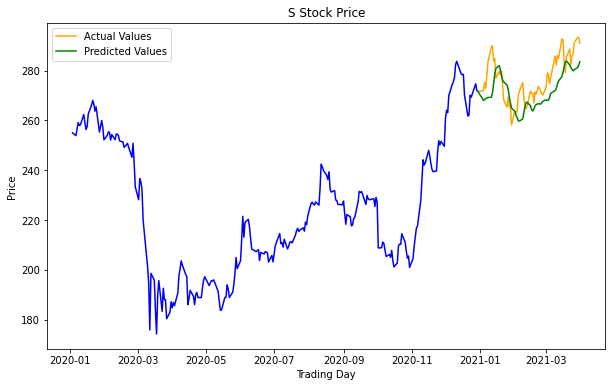

In [48]:
# Plot the S Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predicted, string = 'S Stock Price')

#### KCHOL Stock

In [49]:
# Get the data for this stock

KCHOL_Xtrain, KCHOL_Xtest, KCHOL_ytrain, KCHOL_ytest = variables_model(n = 1)

In [50]:
# Fit the model

KCHOL_pred = model_fit(Xtr = KCHOL_Xtrain, ytr = KCHOL_ytrain, Xte = KCHOL_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 249us/sample - loss: 0.0075
Epoch 2/100
244/244 [==============================] - 0s 268us/sample - loss: 0.0069
Epoch 3/100
244/244 [==============================] - 0s 307us/sample - loss: 0.0075
Epoch 4/100
244/244 [==============================] - 0s 309us/sample - loss: 0.0074
Epoch 5/100
244/244 [==============================] - 0s 325us/sample - loss: 0.0072
Epoch 6/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0069
Epoch 7/100
244/244 [==============================] - 0s 371us/sample - loss: 0.0073
Epoch 8/100
244/244 [==============================] - 0s 283us/sample - loss: 0.0085
Epoch 9/100
244/244 [==============================] - 0s 296us/sample - loss: 0.0083
Epoch 10/100
244/244 [==============================] - 0s 291us/sample - loss: 0.0067
Epoch 11/100
244/244 [==============================] - 0s 270us/sample - loss: 0.0075
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 308us/sample - loss: 0.0047
Epoch 96/100
244/244 [==============================] - 0s 267us/sample - loss: 0.0041
Epoch 97/100
244/244 [==============================] - 0s 284us/sample - loss: 0.0044
Epoch 98/100
244/244 [==============================] - 0s 317us/sample - loss: 0.0039
Epoch 99/100
244/244 [==============================] - 0s 308us/sample - loss: 0.0042
Epoch 100/100
244/244 [==============================] - 0s 313us/sample - loss: 0.0041


In [51]:
# Save the actual and predicted values in different data frames to plot

KCHOL_pred_prices = scaler_inverse(train_array = train['KCHOL_Price'].values, predictions = KCHOL_pred)

In [52]:
# Add the first column to the data frame that will store the predictions

predictions_df['KCHOL_Price'] = KCHOL_pred_prices

In [53]:
# Get the actual and predicted data as data frames for both

KCHOL_actual, KCHOL_predicted = df_merger(train_data = train['KCHOL_Price'], test_data = test['KCHOL_Price'], 
                                  pred_values = predictions_df['KCHOL_Price'])

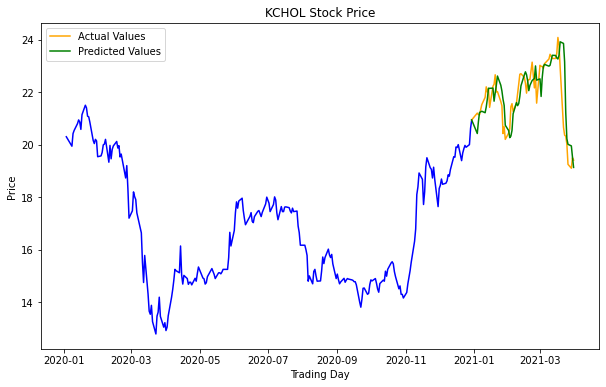

In [54]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predicted, string = 'KCHOL Stock Price')

#### M Stock

In [55]:
# Get the data for this stock

M_Xtrain, M_Xtest, M_ytrain, M_ytest = variables_model(n = 2)

In [56]:
# Fit the model

M_pred = model_fit(Xtr = M_Xtrain, ytr = M_ytrain, Xte = M_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 244us/sample - loss: 0.0035
Epoch 2/100
244/244 [==============================] - 0s 240us/sample - loss: 0.0031
Epoch 3/100
244/244 [==============================] - 0s 254us/sample - loss: 0.0030
Epoch 4/100
244/244 [==============================] - 0s 351us/sample - loss: 0.0032
Epoch 5/100
244/244 [==============================] - 0s 249us/sample - loss: 0.0031
Epoch 6/100
244/244 [==============================] - 0s 250us/sample - loss: 0.0033
Epoch 7/100
244/244 [==============================] - 0s 328us/sample - loss: 0.0029
Epoch 8/100
244/244 [==============================] - 0s 249us/sample - loss: 0.0027
Epoch 9/100
244/244 [==============================] - 0s 308us/sample - loss: 0.0029
Epoch 10/100
244/244 [==============================] - 0s 257us/sample - loss: 0.0033
Epoch 11/100
244/244 [==============================] - 0s 274us/sample - loss: 0.0031
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 398us/sample - loss: 0.0029
Epoch 96/100
244/244 [==============================] - 0s 377us/sample - loss: 0.0026
Epoch 97/100
244/244 [==============================] - 0s 381us/sample - loss: 0.0023
Epoch 98/100
244/244 [==============================] - 0s 384us/sample - loss: 0.0027
Epoch 99/100
244/244 [==============================] - 0s 361us/sample - loss: 0.0028
Epoch 100/100
244/244 [==============================] - 0s 370us/sample - loss: 0.0023


In [57]:
# Save the actual and predicted values in different data frames to plot

M_pred_prices = scaler_inverse(train_array = train['M_Price'].values, predictions = M_pred)

In [58]:
# Add the first column to the data frame that will store the predictions

predictions_df['M_Price'] = M_pred_prices

In [59]:
# Get the actual and predicted data as data frames for both

M_actual, M_predicted = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = predictions_df['M_Price'])

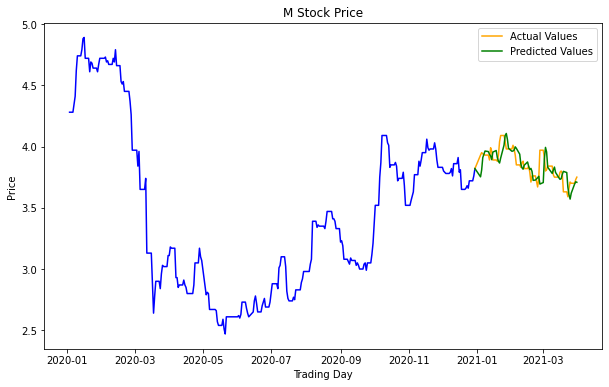

In [60]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predicted, string = 'M Stock Price')

#### BEEF Stock

In [61]:
# Get the data for this stock

BEEF_Xtrain, BEEF_Xtest, BEEF_ytrain, BEEF_ytest = variables_model(n = 3)

In [62]:
# Fit the model

BEEF_pred = model_fit(Xtr = BEEF_Xtrain, ytr = BEEF_ytrain, Xte = BEEF_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 326us/sample - loss: 0.0039
Epoch 2/100
244/244 [==============================] - 0s 309us/sample - loss: 0.0039
Epoch 3/100
244/244 [==============================] - 0s 364us/sample - loss: 0.0040
Epoch 4/100
244/244 [==============================] - 0s 433us/sample - loss: 0.0033
Epoch 5/100
244/244 [==============================] - 0s 318us/sample - loss: 0.0036
Epoch 6/100
244/244 [==============================] - 0s 382us/sample - loss: 0.0034
Epoch 7/100
244/244 [==============================] - 0s 402us/sample - loss: 0.0037
Epoch 8/100
244/244 [==============================] - 0s 356us/sample - loss: 0.0036
Epoch 9/100
244/244 [==============================] - 0s 407us/sample - loss: 0.0039
Epoch 10/100
244/244 [==============================] - 0s 450us/sample - loss: 0.0041
Epoch 11/100
244/244 [==============================] - 0s 329us/sample - loss: 0.0038
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 314us/sample - loss: 0.0033
Epoch 96/100
244/244 [==============================] - 0s 296us/sample - loss: 0.0032
Epoch 97/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0035
Epoch 98/100
244/244 [==============================] - 0s 271us/sample - loss: 0.0032
Epoch 99/100
244/244 [==============================] - 0s 292us/sample - loss: 0.0036
Epoch 100/100
244/244 [==============================] - 0s 308us/sample - loss: 0.0034


In [63]:
# Save the actual and predicted values in different data frames to plot

BEEF_pred_prices = scaler_inverse(train_array = train['BEEF_Price'].values, predictions = BEEF_pred)

In [64]:
# Add the first column to the data frame that will store the predictions

predictions_df['BEEF_Price'] = BEEF_pred_prices

In [65]:
# Get the actual and predicted data as data frames for both

BEEF_actual, BEEF_predicted = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = predictions_df['BEEF_Price'])

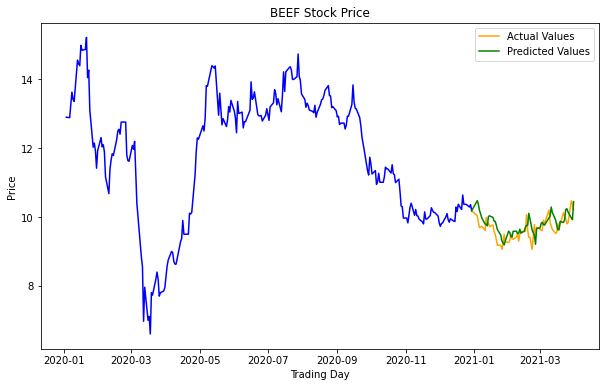

In [66]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predicted, string = 'BEEF Stock Price')

#### P Stock

In [67]:
# Get the data for this stock

P_Xtrain, P_Xtest, P_ytrain, P_ytest = variables_model(n = 4)

In [68]:
# Fit the model

P_pred = model_fit(Xtr = P_Xtrain, ytr = P_ytrain, Xte = P_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 262us/sample - loss: 0.0027
Epoch 2/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0025
Epoch 3/100
244/244 [==============================] - 0s 336us/sample - loss: 0.0022
Epoch 4/100
244/244 [==============================] - 0s 254us/sample - loss: 0.0027
Epoch 5/100
244/244 [==============================] - 0s 263us/sample - loss: 0.0026
Epoch 6/100
244/244 [==============================] - 0s 320us/sample - loss: 0.0025
Epoch 7/100
244/244 [==============================] - 0s 245us/sample - loss: 0.0023
Epoch 8/100
244/244 [==============================] - 0s 333us/sample - loss: 0.0024
Epoch 9/100
244/244 [==============================] - 0s 247us/sample - loss: 0.0024
Epoch 10/100
244/244 [==============================] - 0s 279us/sample - loss: 0.0024
Epoch 11/100
244/244 [==============================] - 0s 281us/sample - loss: 0.0024
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 304us/sample - loss: 0.0030
Epoch 96/100
244/244 [==============================] - 0s 273us/sample - loss: 0.0020
Epoch 97/100
244/244 [==============================] - 0s 298us/sample - loss: 0.0026
Epoch 98/100
244/244 [==============================] - 0s 306us/sample - loss: 0.0026
Epoch 99/100
244/244 [==============================] - 0s 326us/sample - loss: 0.0023
Epoch 100/100
244/244 [==============================] - 0s 316us/sample - loss: 0.0023


In [69]:
# Save the actual and predicted values in different data frames to plot

P_pred_prices = scaler_inverse(train_array = train['P_Price'].values, predictions = P_pred)

In [70]:
# Add the first column to the data frame that will store the predictions

predictions_df['P_Price'] = P_pred_prices

In [71]:
# Get the actual and predicted data as data frames for both

P_actual, P_predicted = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = predictions_df['P_Price'])

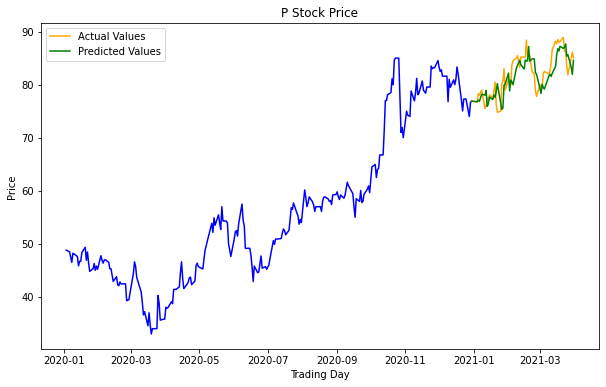

In [72]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predicted, string = 'P Stock Price')

#### C Stock

In [73]:
# Get the data for this stock

C_Xtrain, C_Xtest, C_ytrain, C_ytest = variables_model(n = 5)

In [74]:
# Fit the model

C_pred = model_fit(Xtr = C_Xtrain, ytr = C_ytrain, Xte = C_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 270us/sample - loss: 0.0017
Epoch 2/100
244/244 [==============================] - 0s 259us/sample - loss: 0.0021
Epoch 3/100
244/244 [==============================] - 0s 288us/sample - loss: 0.0019
Epoch 4/100
244/244 [==============================] - 0s 328us/sample - loss: 0.0019
Epoch 5/100
244/244 [==============================] - 0s 266us/sample - loss: 0.0016
Epoch 6/100
244/244 [==============================] - 0s 313us/sample - loss: 0.0016
Epoch 7/100
244/244 [==============================] - 0s 286us/sample - loss: 0.0017
Epoch 8/100
244/244 [==============================] - 0s 256us/sample - loss: 0.0017
Epoch 9/100
244/244 [==============================] - 0s 294us/sample - loss: 0.0017
Epoch 10/100
244/244 [==============================] - 0s 251us/sample - loss: 0.0016
Epoch 11/100
244/244 [==============================] - 0s 350us/sample - loss: 0.0017
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 346us/sample - loss: 0.0015
Epoch 96/100
244/244 [==============================] - 0s 313us/sample - loss: 0.0015
Epoch 97/100
244/244 [==============================] - 0s 299us/sample - loss: 0.0016
Epoch 98/100
244/244 [==============================] - 0s 304us/sample - loss: 0.0016
Epoch 99/100
244/244 [==============================] - 0s 280us/sample - loss: 0.0016
Epoch 100/100
244/244 [==============================] - 0s 308us/sample - loss: 0.0016


In [75]:
# Save the actual and predicted values in different data frames to plot

C_pred_prices = scaler_inverse(train_array = train['C_Price'].values, predictions = C_pred)

In [76]:
# Add the first column to the data frame that will store the predictions

predictions_df['C_Price'] = C_pred_prices

In [77]:
# Get the actual and predicted data as data frames for both

C_actual, C_predicted = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = predictions_df['C_Price'])

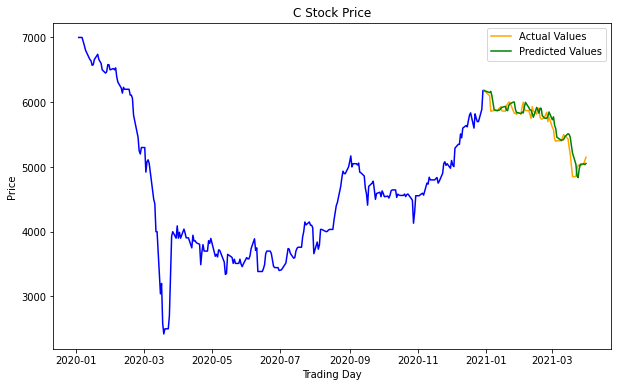

In [78]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predicted, string = 'C Stock Price')

#### IP Stock

In [79]:
# Get the data for this stock

IP_Xtrain, IP_Xtest, IP_ytrain, IP_ytest = variables_model(n = 6)

In [80]:
# Fit the model

IP_pred = model_fit(Xtr = IP_Xtrain, ytr = IP_ytrain, Xte = IP_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0026
Epoch 2/100
244/244 [==============================] - 0s 247us/sample - loss: 0.0027
Epoch 3/100
244/244 [==============================] - 0s 321us/sample - loss: 0.0026
Epoch 4/100
244/244 [==============================] - 0s 308us/sample - loss: 0.0024
Epoch 5/100
244/244 [==============================] - 0s 237us/sample - loss: 0.0029
Epoch 6/100
244/244 [==============================] - 0s 247us/sample - loss: 0.0026
Epoch 7/100
244/244 [==============================] - 0s 333us/sample - loss: 0.0026
Epoch 8/100
244/244 [==============================] - 0s 266us/sample - loss: 0.0027
Epoch 9/100
244/244 [==============================] - 0s 264us/sample - loss: 0.0028
Epoch 10/100
244/244 [==============================] - 0s 327us/sample - loss: 0.0030
Epoch 11/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0030
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 296us/sample - loss: 0.0027
Epoch 96/100
244/244 [==============================] - 0s 338us/sample - loss: 0.0026
Epoch 97/100
244/244 [==============================] - 0s 291us/sample - loss: 0.0026
Epoch 98/100
244/244 [==============================] - 0s 277us/sample - loss: 0.0025
Epoch 99/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0025
Epoch 100/100
244/244 [==============================] - 0s 300us/sample - loss: 0.0026


In [81]:
# Save the actual and predicted values in different data frames to plot

IP_pred_prices = scaler_inverse(train_array = train['IP_Price'].values, predictions = IP_pred)

In [82]:
# Add the first column to the data frame that will store the predictions

predictions_df['IP_Price'] = IP_pred_prices

In [83]:
# Get the actual and predicted data as data frames for both

IP_actual, IP_predicted = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = predictions_df['IP_Price'])

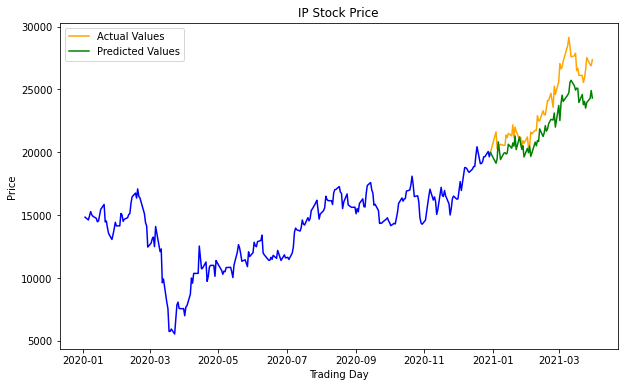

In [84]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predicted, string = 'IP Stock Price')

#### DS Stock

In [85]:
# Get the data for this stock

DS_Xtrain, DS_Xtest, DS_ytrain, DS_ytest = variables_model(n = 7)

In [86]:
# Fit the model

DS_pred = model_fit(Xtr = DS_Xtrain, ytr = DS_ytrain, Xte = DS_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0027
Epoch 2/100
244/244 [==============================] - 0s 237us/sample - loss: 0.0031
Epoch 3/100
244/244 [==============================] - 0s 237us/sample - loss: 0.0026
Epoch 4/100
244/244 [==============================] - 0s 445us/sample - loss: 0.0030
Epoch 5/100
244/244 [==============================] - 0s 259us/sample - loss: 0.0031
Epoch 6/100
244/244 [==============================] - 0s 245us/sample - loss: 0.0028
Epoch 7/100
244/244 [==============================] - 0s 359us/sample - loss: 0.0030
Epoch 8/100
244/244 [==============================] - 0s 252us/sample - loss: 0.0026
Epoch 9/100
244/244 [==============================] - 0s 310us/sample - loss: 0.0026
Epoch 10/100
244/244 [==============================] - 0s 267us/sample - loss: 0.0027
Epoch 11/100
244/244 [==============================] - 0s 287us/sample - loss: 0.0024
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 312us/sample - loss: 0.0024
Epoch 96/100
244/244 [==============================] - 0s 289us/sample - loss: 0.0024
Epoch 97/100
244/244 [==============================] - 0s 249us/sample - loss: 0.0024
Epoch 98/100
244/244 [==============================] - 0s 313us/sample - loss: 0.0024
Epoch 99/100
244/244 [==============================] - 0s 305us/sample - loss: 0.0026
Epoch 100/100
244/244 [==============================] - 0s 321us/sample - loss: 0.0029


In [87]:
# Save the actual and predicted values in different data frames to plot

DS_pred_prices = scaler_inverse(train_array = train['DS_Price'].values, predictions = DS_pred)

In [88]:
# Add the first column to the data frame that will store the predictions

predictions_df['DS_Price'] = DS_pred_prices

In [89]:
# Get the actual and predicted data as data frames for both

DS_actual, DS_predicted = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = predictions_df['DS_Price'])

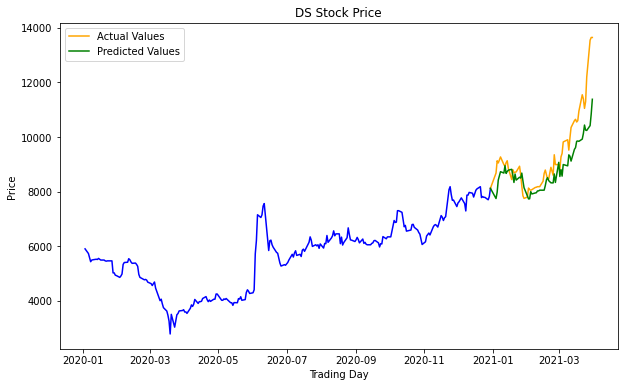

In [90]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predicted, string = 'DS Stock Price')

### SARIMAX

In [91]:
def arima_selection(values):
    model_autoARIMA = auto_arima(y = values, x = None, start_p = 1, d = None, start_q = 1, max_p = 11, max_d = 11,
                                max_q = 11, start_P = 1, D = None, start_Q = 1, max_P = 11, max_D = 11, max_Q = 11,
                                max_order = None, m = 5, alpha = 0.05, n_jobs = -1)
    return model_autoARIMA, model_autoARIMA.summary()


In [92]:
def model_fit_arima(df, col, order):
    
    warnings.filterwarnings('ignore')

    train_values = df['2020'][col].values

    test_values = df['2021'][col].values
    
    predictions = np.empty(shape = len(test_values))
    
    for i in range(len(test_values)):
        model = ARIMA(endog = train_values, order = order)
        model = model.fit()
        output = model.forecast()
        p = output[0]
        predictions[i] = p
        obs = test_values[i]
        train_values = np.append(train_values, obs)
        
    return predictions
        

In [93]:
pred_arima = pd.DataFrame()

pred_arima['Date'] = test.index

pred_arima.set_index('Date', inplace = True)

#### S Stock

In [94]:
# Get the best order to train the ARIMA model

arima_selection(values = train['S_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -747.842
 Date:                Mon, 21 Jun 2021   AIC                           1497.685
 Time:                        19:16:52   BIC                           1501.202
 Sample:                             0   HQIC                          1499.101
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2        23.7810    

In [95]:
stock_prices.isna().sum()

S_Price         0
KCHOL_Price     9
M_Price        77
BEEF_Price     13
P_Price        22
C_Price        20
IP_Price       10
DS_Price       14
dtype: int64

In [96]:
# Use the function to predict the outcomes

S_pred_arima = model_fit_arima(df = stock_prices_daily, col = 'S_Price', order = (0,1,0))

In [97]:
# Save the predicted prices in a new column

pred_arima['S_Price'] = S_pred_arima

In [98]:
# Get the actual and predicted data as data frames for both

S_actual_arima, S_predicted_arima = df_merger(train_data = train['S_Price'], 
                                                      test_data = test['S_Price'], 
                                                      pred_values = pred_arima['S_Price'])

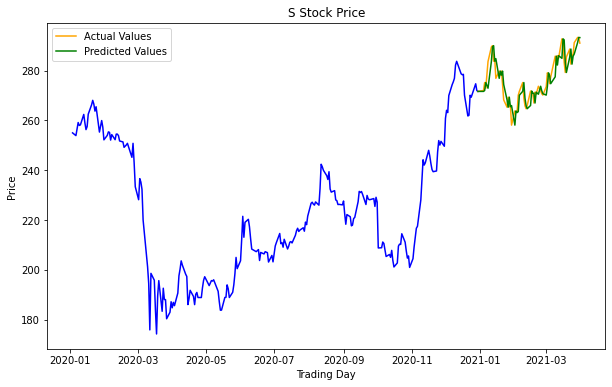

In [99]:
# Plot the Stock Price comparison

plot_comparison(actual = S_actual_arima, predicted = S_predicted_arima, string = 'S Stock Price')

#### KCHOL Stock

In [100]:
# Get the best order to train the ARIMA model

arima_selection(values = train['KCHOL_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -126.205
 Date:                Mon, 21 Jun 2021   AIC                            254.410
 Time:                        19:16:55   BIC                            257.927
 Sample:                             0   HQIC                           255.826
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.1613    

In [101]:
# Use the function to predict the outcomes

KCHOL_pred_arima = model_fit_arima(stock_prices_daily, col = 'KCHOL_Price', order = (0,1,0))

In [102]:
# Save the predicted prices in a new column

pred_arima['KCHOL_Price'] = KCHOL_pred_arima

In [103]:
# Get the actual and predicted data as data frames for both

KCHOL_actual_arima, KCHOL_predicted_arima = df_merger(train_data = train['KCHOL_Price'], 
                                                      test_data = test['KCHOL_Price'], 
                                                      pred_values = pred_arima['KCHOL_Price'])

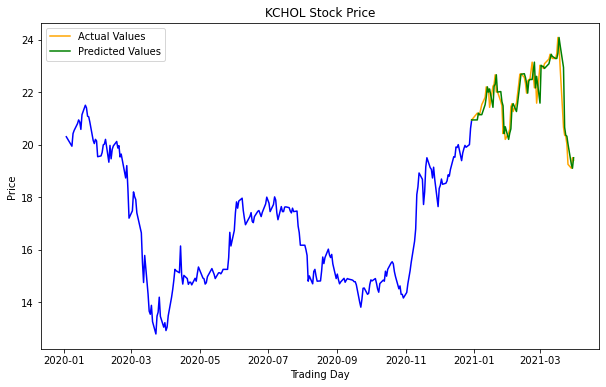

In [104]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual_arima, predicted = KCHOL_predicted_arima, string = 'KCHOL Stock Price')

#### M Stock

In [105]:
# Get the best order to train the ARIMA model

arima_selection(values = train['M_Price'])

(ARIMA(order=(0, 1, 4), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 4)   Log Likelihood                 252.477
 Date:                Mon, 21 Jun 2021   AIC                           -494.954
 Time:                        19:17:08   BIC                           -477.366
 Sample:                             0   HQIC                          -487.875
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ma.L1          0.0498    

In [106]:
# Use the function to predict the outcomes

M_pred_arima = model_fit_arima(stock_prices_daily, col = 'M_Price', order = (0,1,4))

In [107]:
pred_arima['M_Price'] = M_pred_arima

In [108]:
# Get the actual and predicted data as data frames for both

M_actual_arima, M_predicted_arima = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = pred_arima['M_Price'])

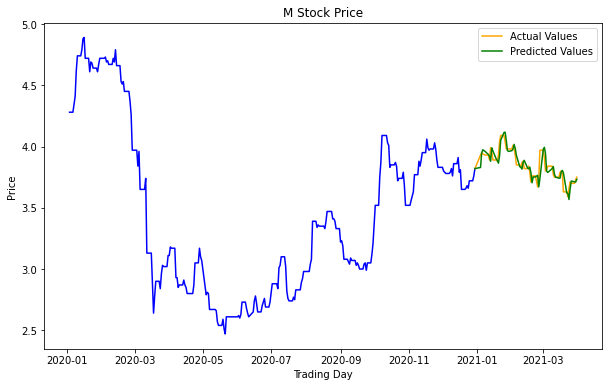

In [109]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual_arima, predicted = M_predicted_arima, string = 'M Stock Price')

#### BEEF Stock

In [110]:
# Get the best order to train the ARIMA model

arima_selection(values = train['BEEF_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -127.797
 Date:                Mon, 21 Jun 2021   AIC                            257.595
 Time:                        19:17:15   BIC                            261.112
 Sample:                             0   HQIC                           259.011
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.1634    

In [111]:
# Use the function to predict the outcomes

BEEF_pred_arima = model_fit_arima(stock_prices_daily, col = 'BEEF_Price', order = (0,1,0))

In [112]:
# Save prices in a column of the data frame

pred_arima['BEEF_Price'] = BEEF_pred_arima

In [113]:
# Get the actual and predicted data as data frames for both

BEEF_actual_arima, BEEF_predicted_arima = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = pred_arima['BEEF_Price'])

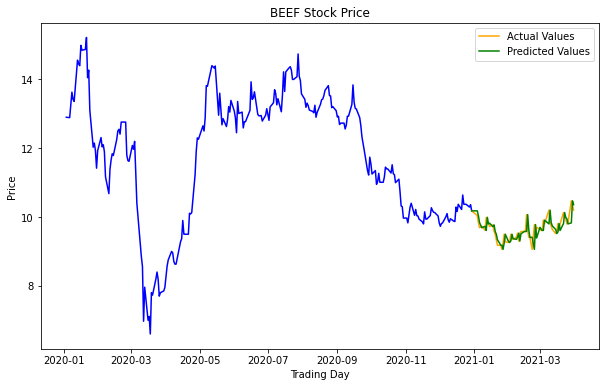

In [114]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual_arima, predicted = BEEF_predicted_arima, string = 'BEEF Stock Price')

#### P Stock

In [115]:
# Get the best order to train the ARIMA model

arima_selection(values = train['P_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -522.848
 Date:                Mon, 21 Jun 2021   AIC                           1047.695
 Time:                        19:17:18   BIC                           1051.213
 Sample:                             0   HQIC                          1049.111
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         3.9028    

In [116]:
# Use the function to predict the outcomes

P_pred_arima = model_fit_arima(stock_prices_daily, col = 'P_Price', order = (0,1,0))

In [117]:
pred_arima['P_Price'] = P_pred_arima

In [118]:
# Get the actual and predicted data as data frames for both

P_actual_arima, P_predicted_arima = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = pred_arima['P_Price'])

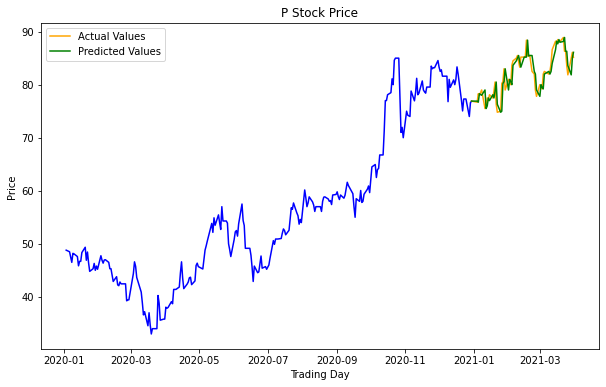

In [119]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual_arima, predicted = P_predicted_arima, string = 'P Stock Price')

#### C Stock

In [120]:
# Get the best order to train the ARIMA model

arima_selection(values = train['C_Price'])

(ARIMA(order=(2, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1593.351
 Date:                Mon, 21 Jun 2021   AIC                           3194.701
 Time:                        19:17:26   BIC                           3208.755
 Sample:                             0   HQIC                          3200.359
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          0.0525    

In [121]:
# Use the function to predict the outcomes

C_pred_arima = model_fit_arima(stock_prices_daily, col = 'C_Price', order = (2,2,1))


In [122]:
# Save results in the predicted data frame

pred_arima['C_Price'] = C_pred_arima

In [123]:
# Get the actual and predicted data as data frames for both

C_actual_arima, C_predicted_arima = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = pred_arima['C_Price'])

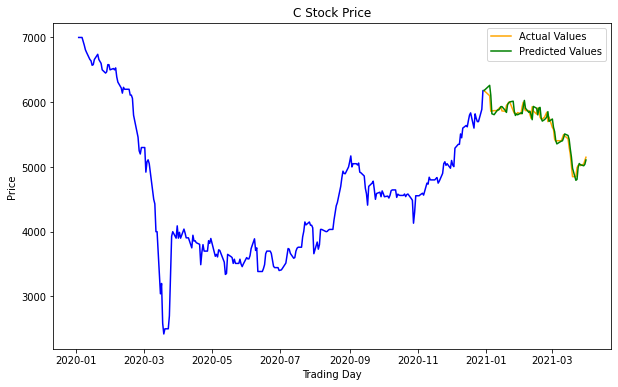

In [124]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual_arima, predicted = C_predicted_arima, string = 'C Stock Price')

#### IP Stock

In [125]:
# Get the best order to train the ARIMA model

arima_selection(values = train['IP_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 1, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                      
 Dep. Variable:                                   y   No. Observations:                  250
 Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -1964.063
 Date:                             Mon, 21 Jun 2021   AIC                           3932.126
 Time:                                     19:17:39   BIC                           3939.161
 Sample:                                          0   HQIC                          3934.957
                                              - 250                                         
 Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 -

In [126]:
# Use the function to predict the outcomes

IP_pred_arima = model_fit_arima(stock_prices_daily, col = 'IP_Price', order = (0,1,0))


In [127]:
pred_arima['IP_Price'] = IP_pred_arima

In [128]:
# Get the actual and predicted data as data frames for both

IP_actual_arima, IP_predicted_arima = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = pred_arima['IP_Price'])

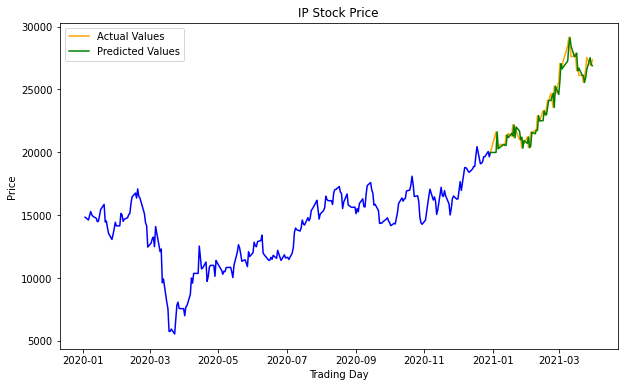

In [129]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual_arima, predicted = IP_predicted_arima, string = 'IP Stock Price')

#### DS Stock

In [130]:
# Get the best order to train the ARIMA model

arima_selection(values = train['DS_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1711.671
 Date:                Mon, 21 Jun 2021   AIC                           3425.341
 Time:                        19:17:42   BIC                           3428.859
 Sample:                             0   HQIC                          3426.757
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2      5.475e+04   1

In [131]:
# Use the function to predict the outcomes

DS_pred_arima = model_fit_arima(stock_prices_daily, col = 'DS_Price', order = (0,1,0))


In [132]:
pred_arima['DS_Price'] = DS_pred_arima

In [133]:
# Get the actual and predicted data as data frames for both

DS_actual_arima, DS_predicted_arima = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = pred_arima['DS_Price'])

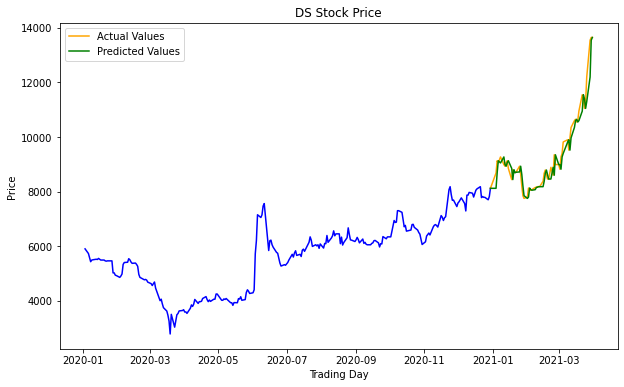

In [134]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual_arima, predicted = DS_predicted_arima, string = 'DS Stock Price')

## Model Evaluation

In [135]:
def capital_gain_predicted_prices(df1, df2):
    # Define the total capital gain as the final value minus the initial value divided by the initial value
    actual_returns = (df1[-1] - df1[0])/df1[0]
    # Predicted returns 
    predicted_returns = (df2[-1] - df2[0])/df2[0]
    # Show the value as percentage
    actual_returns = round(actual_returns*100,2)
    predicted_returns = round(predicted_returns*100, 2)
    print('The actual returns had a value of {}% and the predicted returns had a value {}%'.format(actual_returns, 
                                                                                                predicted_returns))

In [136]:
# Define a function for the Bollinger brands

def bollinger_bands(df, col, p, std):
    # Create a new data frame just to use in the function to plot the upper, and lower bound with the moving average
    # and the closing price
    bollinger_df = pd.DataFrame()
    #Establish the serie to use the rolling function
    bollinger_df[col] = df[col].astype(int)
    # Define number of periods
    period = p
    # Apply the rolling function for the moving average
    bollinger_df['SMA'] = bollinger_df.rolling(window = period).mean()
    # Calculate the Standard Deviation
    bollinger_df['std'] = bollinger_df[col].rolling(window = period).std()
    # Establish the upper border
    bollinger_df['upper'] = bollinger_df['SMA'] + (bollinger_df['std'] * std)
    # Establish the lower border
    bollinger_df['lower'] = bollinger_df['SMA'] - (bollinger_df['std'] * std)
    
    # Define the conditions to make the buy/sell recommendations
    buy_signal = []
    sell_signal = []
    
    # Start a for loop
    for i in range(len(bollinger_df[col])):
        if bollinger_df[col][i] > bollinger_df['upper'][i]: # This is the condition for sell recommendation 
            buy_signal.append(np.nan)
            sell_signal.append(bollinger_df[col][i])
        elif bollinger_df[col][i] < bollinger_df['lower'][i]: # This is the condition for buy recommendation
            buy_signal.append(bollinger_df[col][i])
            sell_signal.append(np.nan)
        else: # If none of the conditions are met, then no recommendation is given
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    # Add the recommendations as a columns in the data frame
    bollinger_df['buy'] = buy_signal
    bollinger_df['sell'] = sell_signal
    
    # Plot the bollinger bands in order to make the sell and buy recommendations
    fig = plt.figure(figsize = (20,12))
    # Add subplot
    ax = fig.add_subplot(1,1,1)
    # Get the index
    x_axis = bollinger_df.index
    # Plot the shade area between the upper and the lower bound
    ax.fill_between(x_axis, bollinger_df['upper'], bollinger_df['lower'], color = 'grey')
    # Plot the closing price, moving average and buy and sell recommendations
    ax.plot(x_axis, bollinger_df[col], color = 'gold', lw = 3, label = 'Price')
    ax.plot(x_axis, bollinger_df['SMA'], color = 'blue', lw = 3, label = 'Moving Averag')
    ax.scatter(x_axis, bollinger_df['buy'], color = 'green', lw = 3, marker = '^', label = 'Buy', s = 100)
    ax.scatter(x_axis, bollinger_df['sell'], color = 'red', lw = 3, marker = 'v', label = 'Sell', s = 100)
    # Set the axis
    ax.set_title('Bollinger bands for {}'.format(col))
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.xticks(rotation = 45)
    ax.legend(loc = (1.02, 0.6))
    return plt.show()


In [137]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df = merge_df(df1 = S_predicted, df2 = KCHOL_predicted, df3 = M_predicted, df4 = BEEF_predicted, 
                        df5 = P_predicted, df6 = C_predicted, df7 = IP_predicted, df8 = DS_predicted)

### LSTM

#### S_Stock

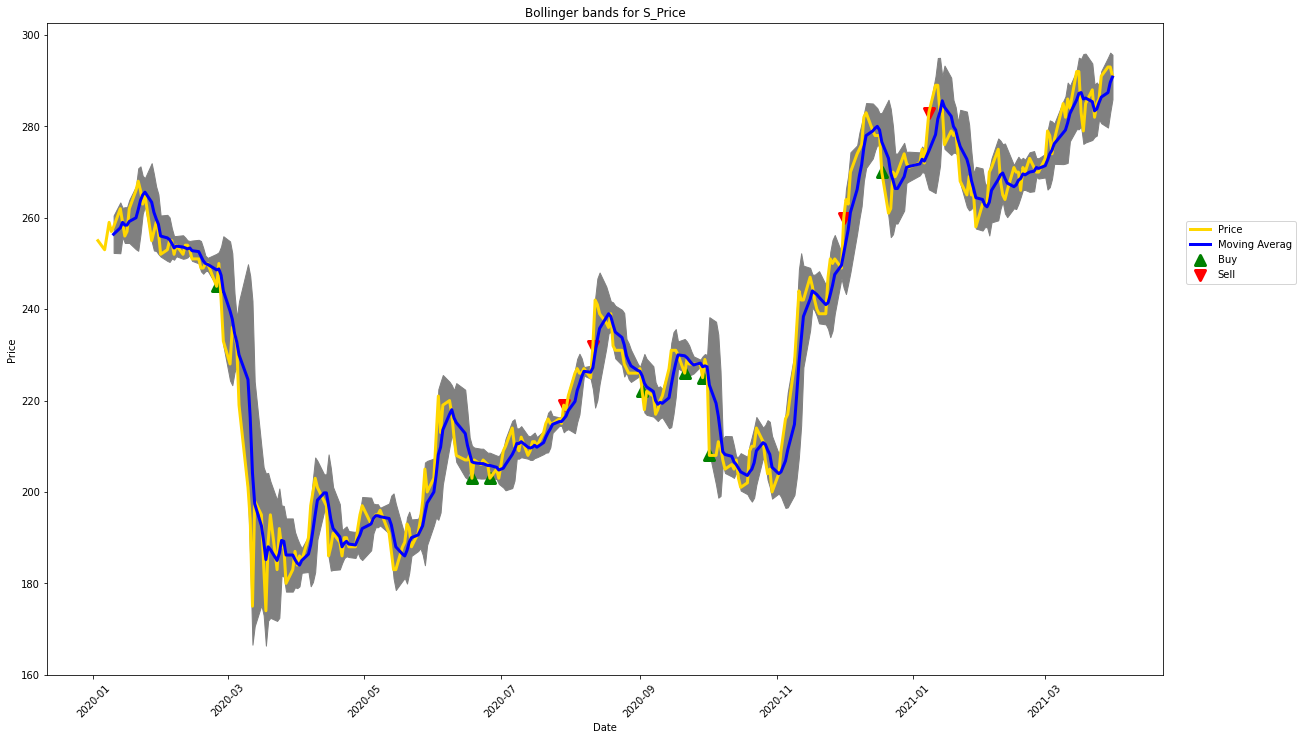

In [138]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

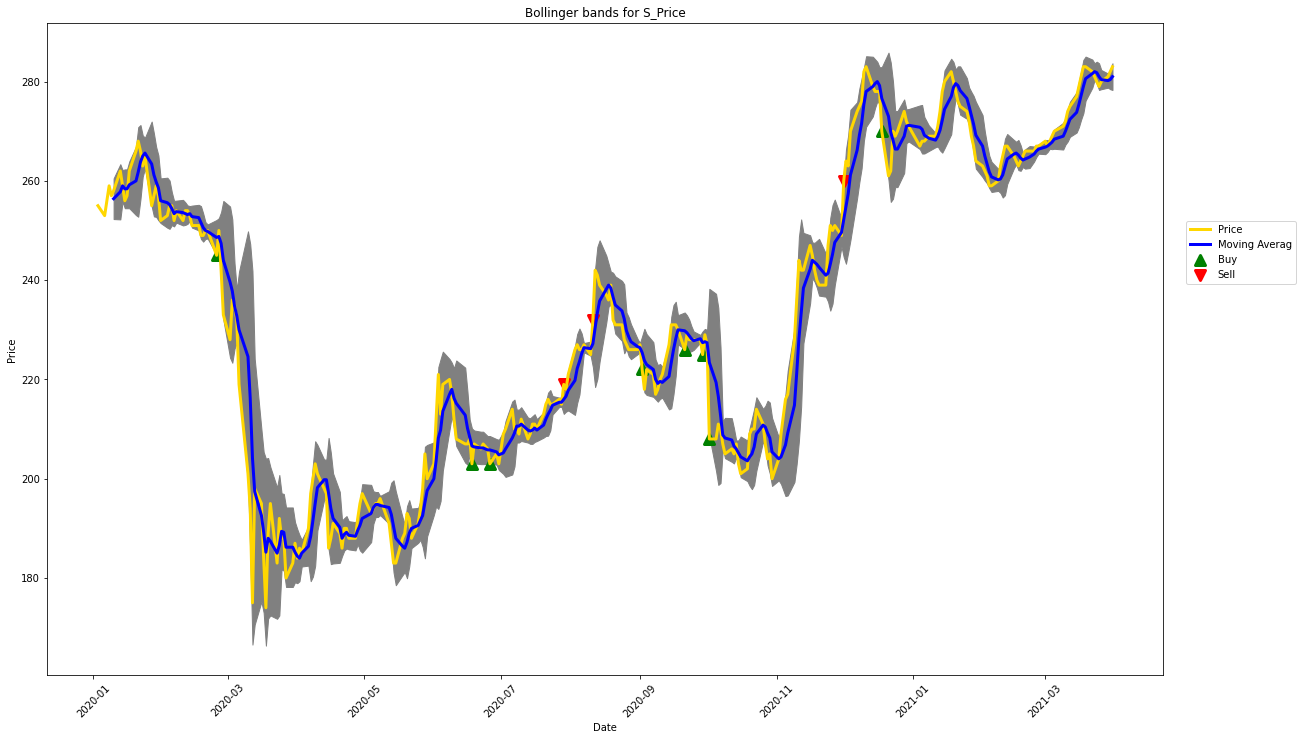

In [139]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'S_Price', p = 5, std = 1.7)

In [140]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = predictions_df['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 5.82%


#### KCHOL Stock

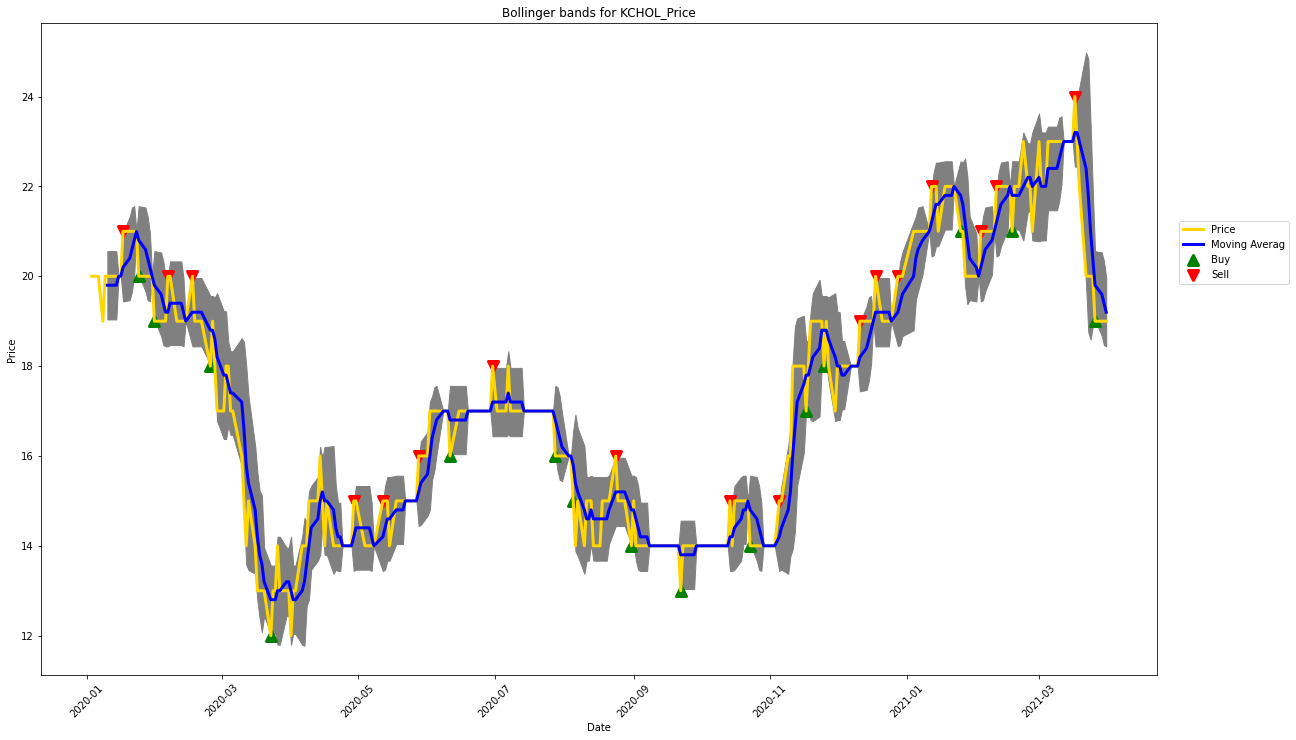

In [141]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

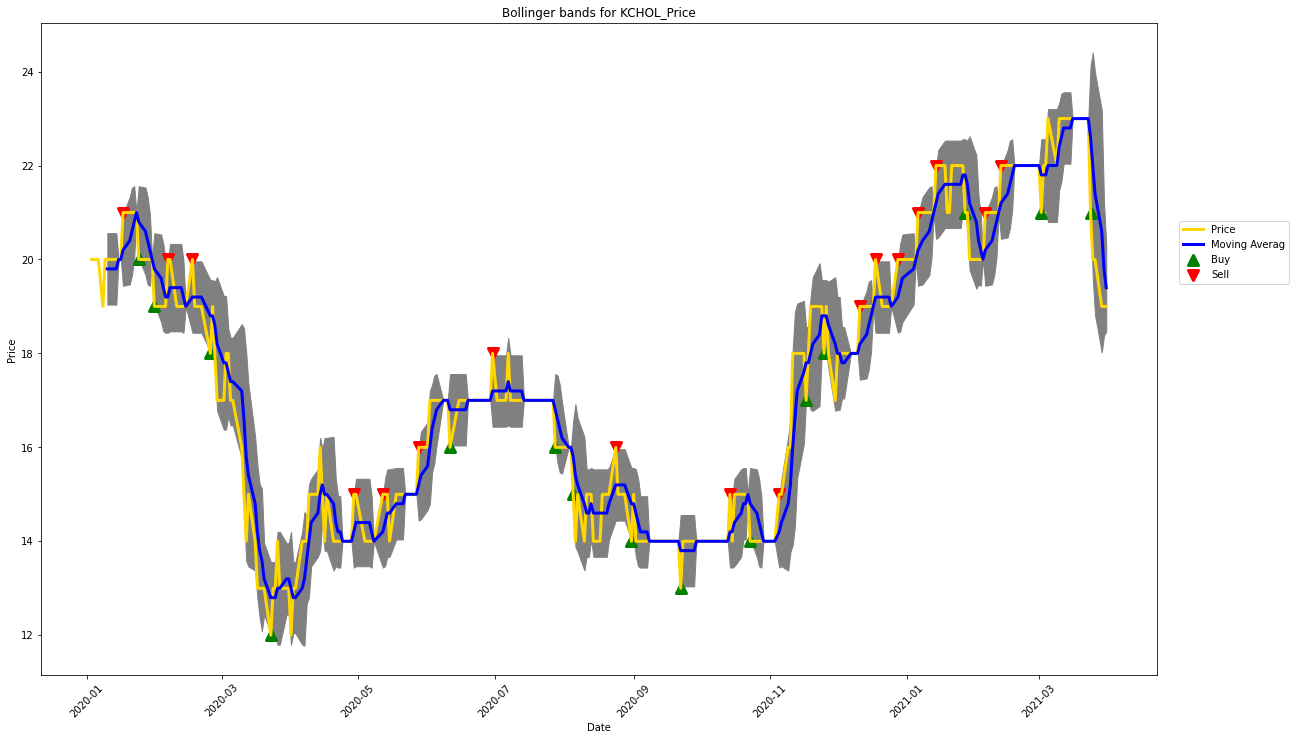

In [142]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'KCHOL_Price', p = 5, std = 1.7)

In [143]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = predictions_df['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -6.32%


#### M Stock

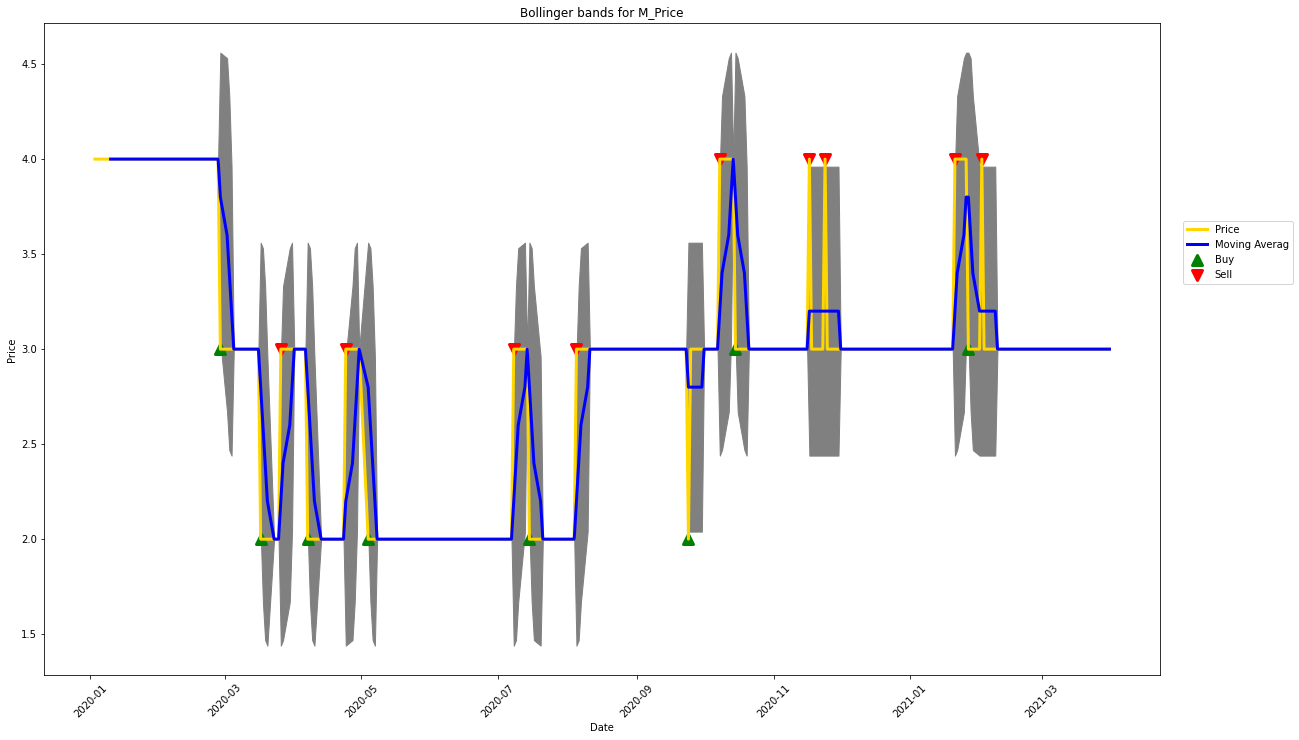

In [144]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

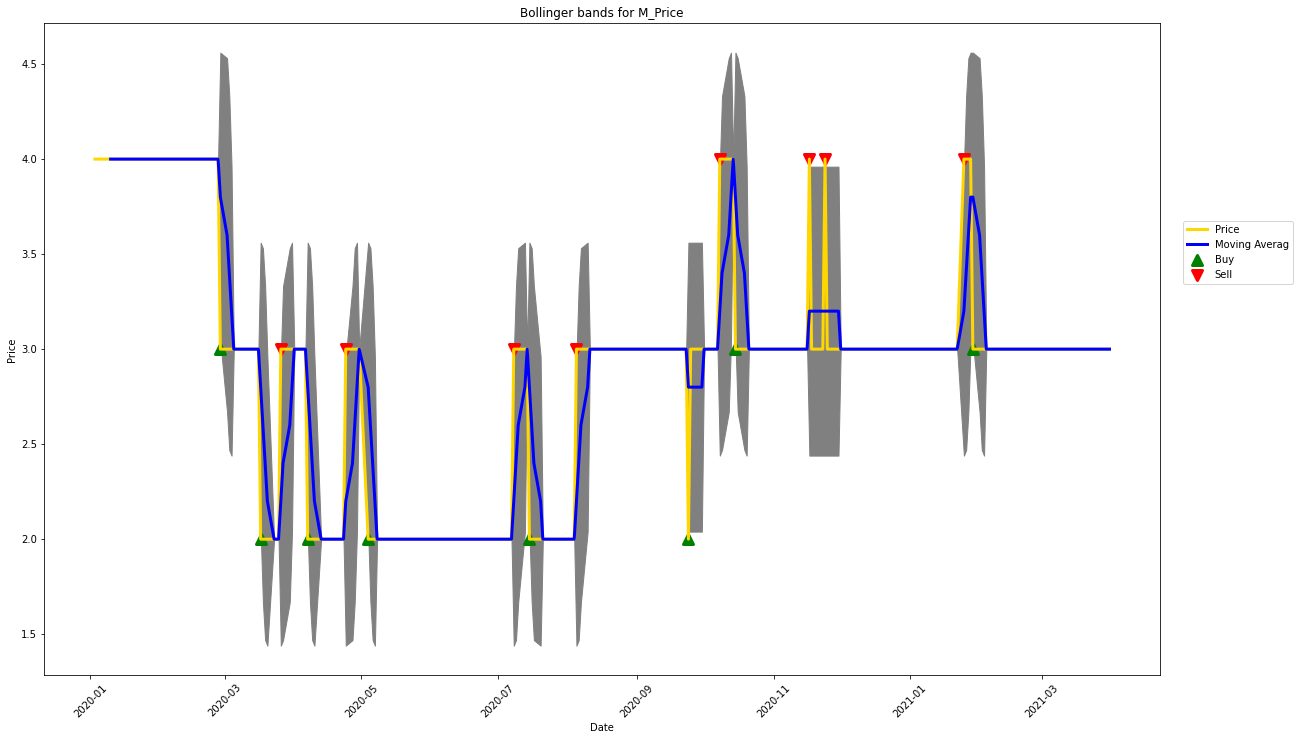

In [145]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'M_Price', p = 5, std = 1.7)

In [146]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = predictions_df['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -1.19%


#### BEEF Stock

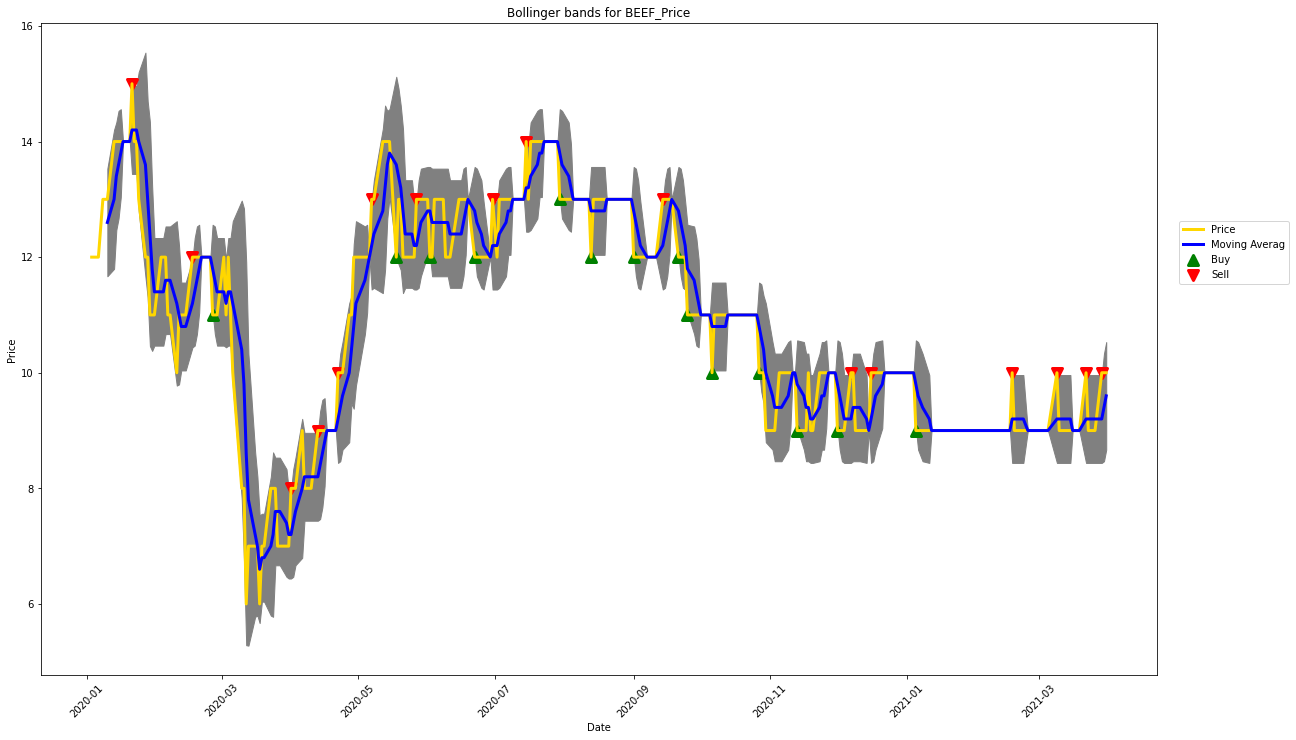

In [147]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

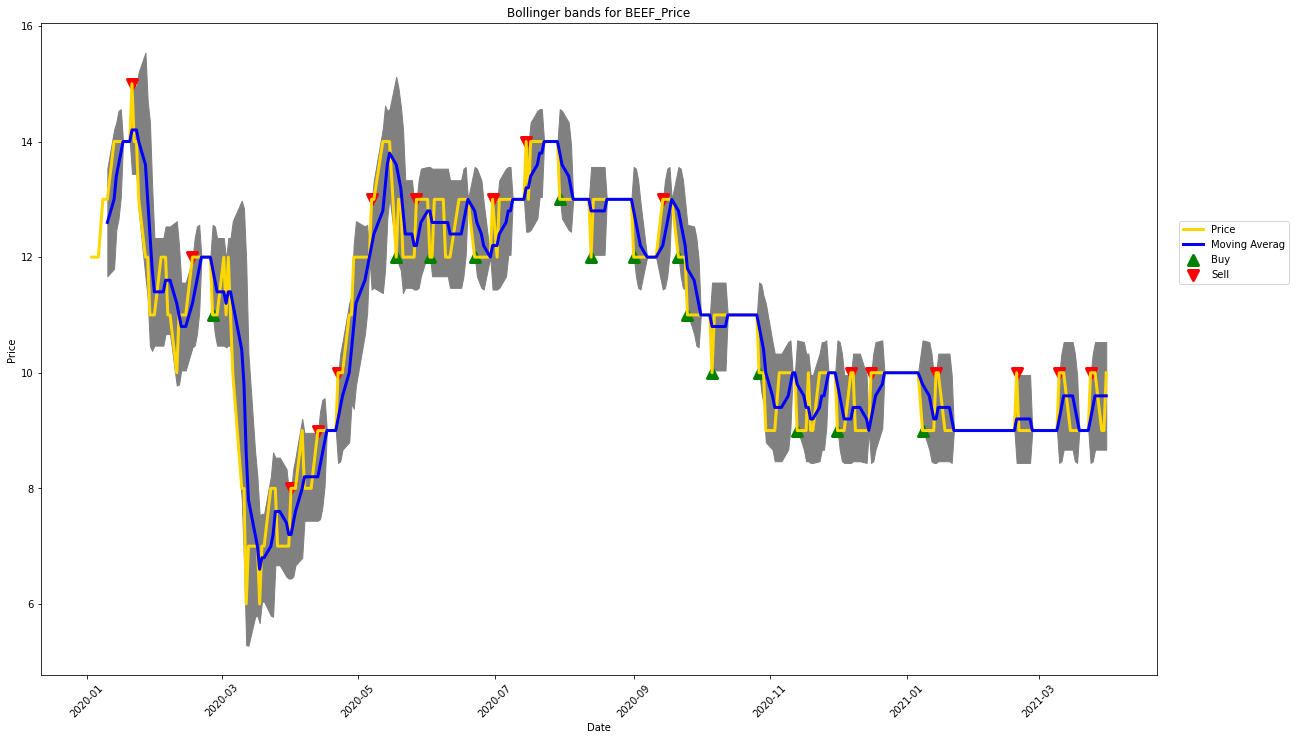

In [148]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'BEEF_Price', p = 5, std = 1.7)

In [149]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = predictions_df['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value -0.3%


#### P Stock

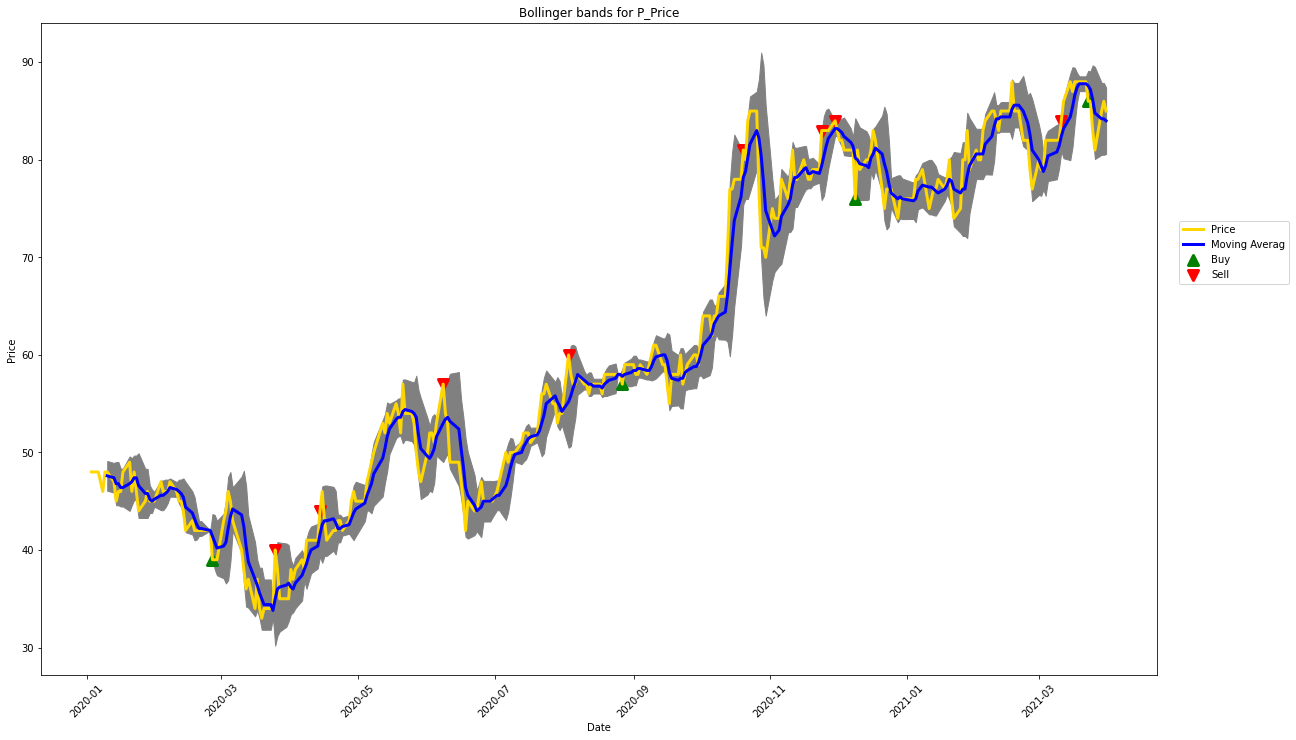

In [150]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

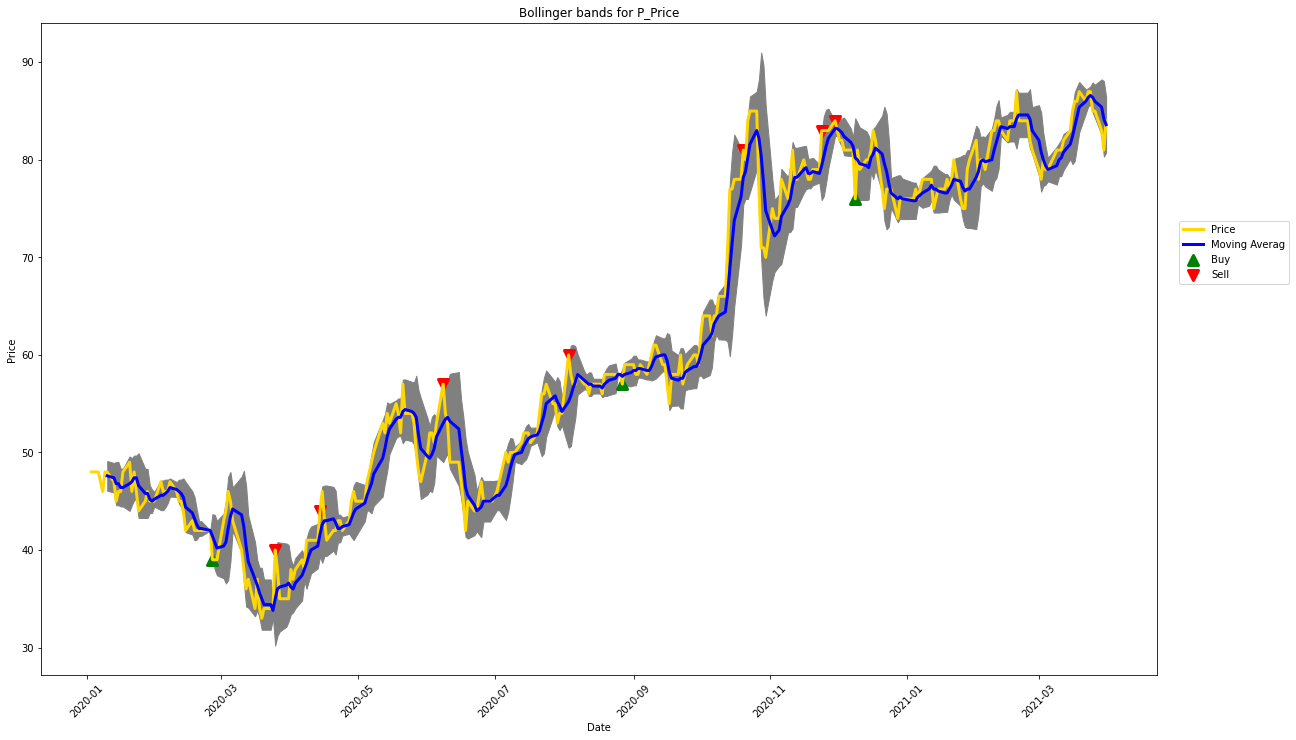

In [151]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'P_Price', p = 5, std = 1.7)

In [152]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = predictions_df['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 10.16%


#### C Stock

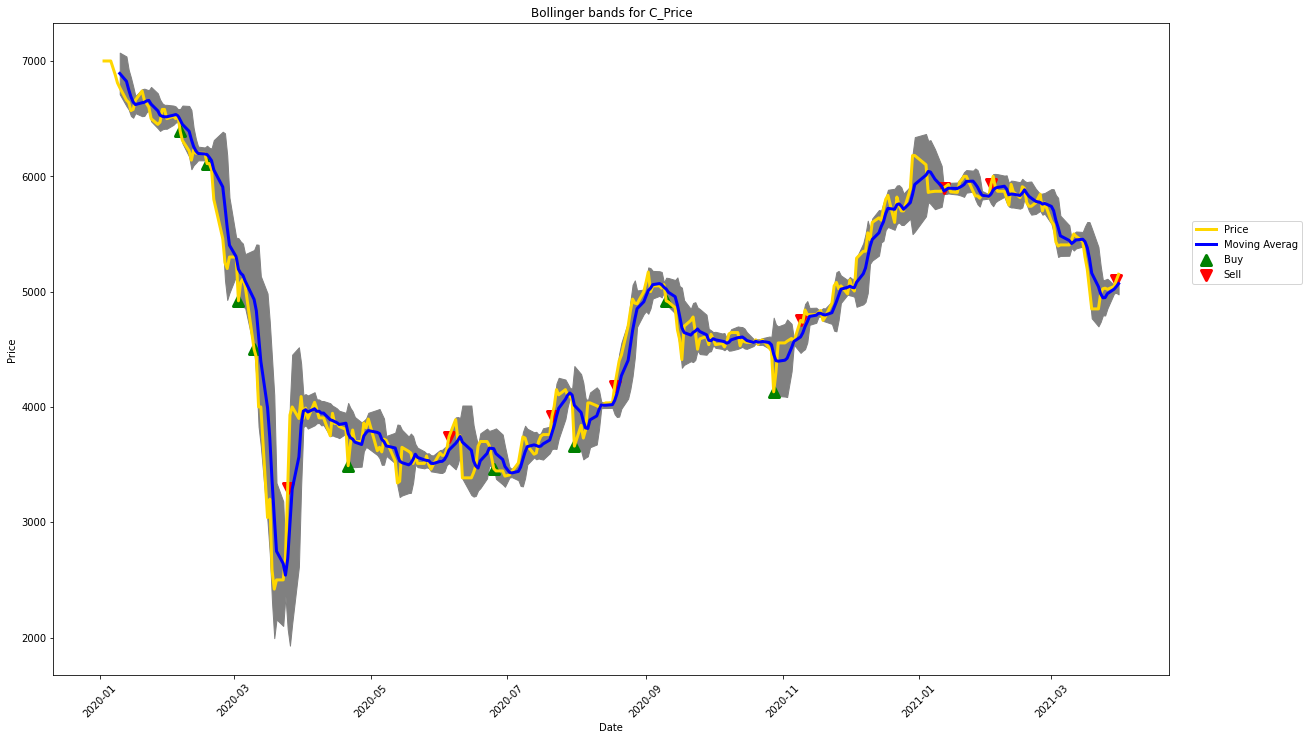

In [153]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

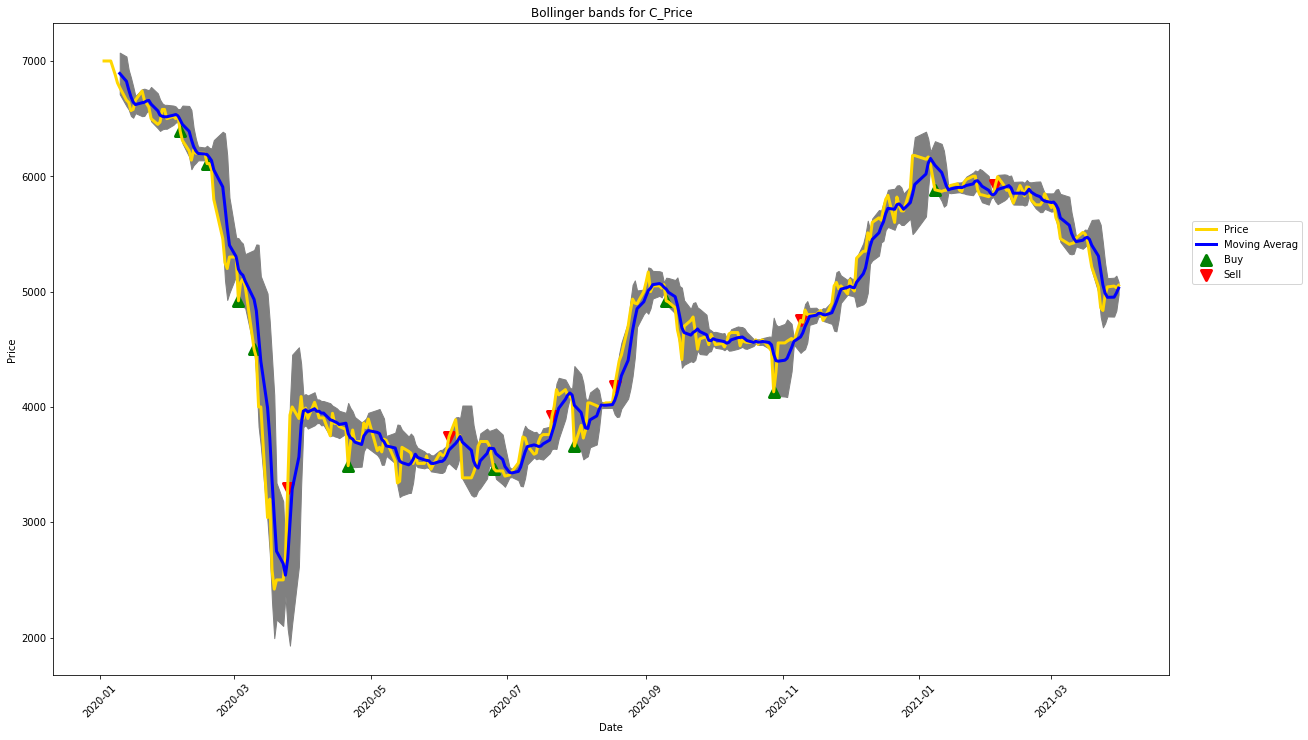

In [154]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'C_Price', p = 5, std = 1.7)

In [155]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = predictions_df['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -17.8%


#### IP Stock

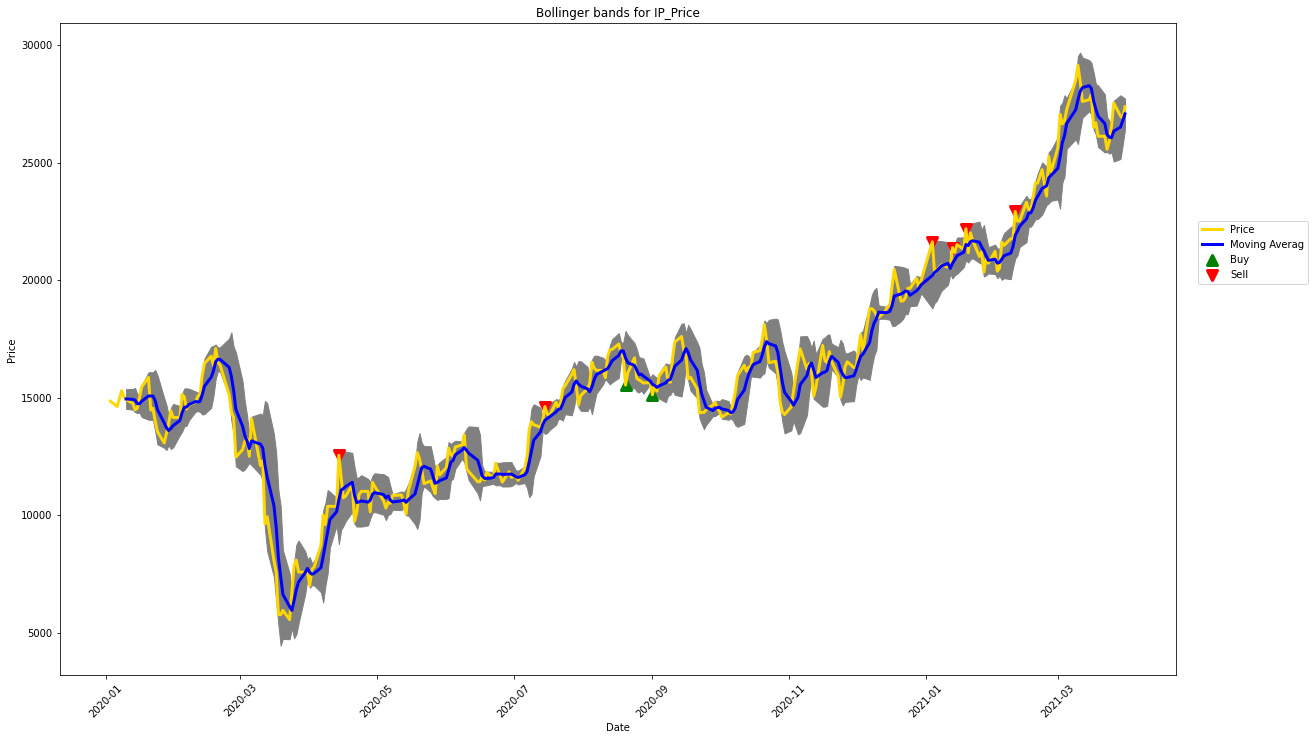

In [156]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

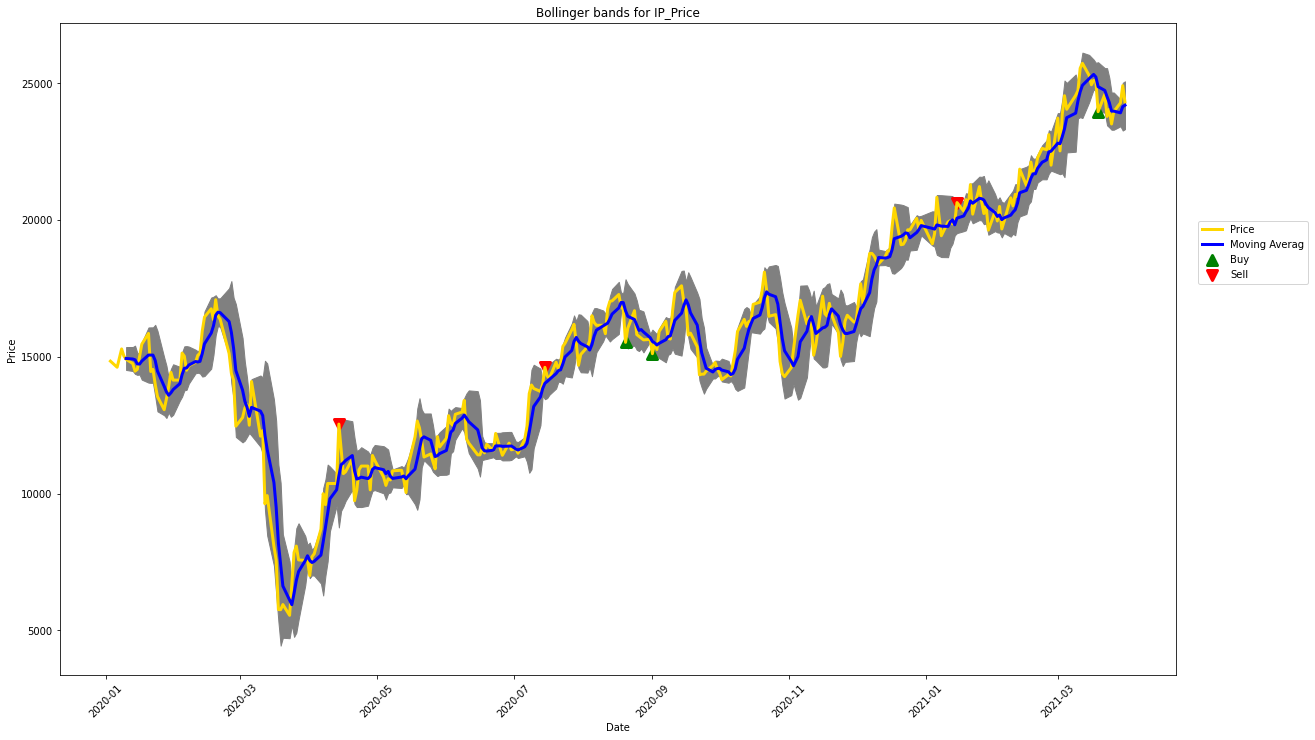

In [157]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'IP_Price', p = 5, std = 1.7)

In [158]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = predictions_df['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 27.08%


#### DS Stock

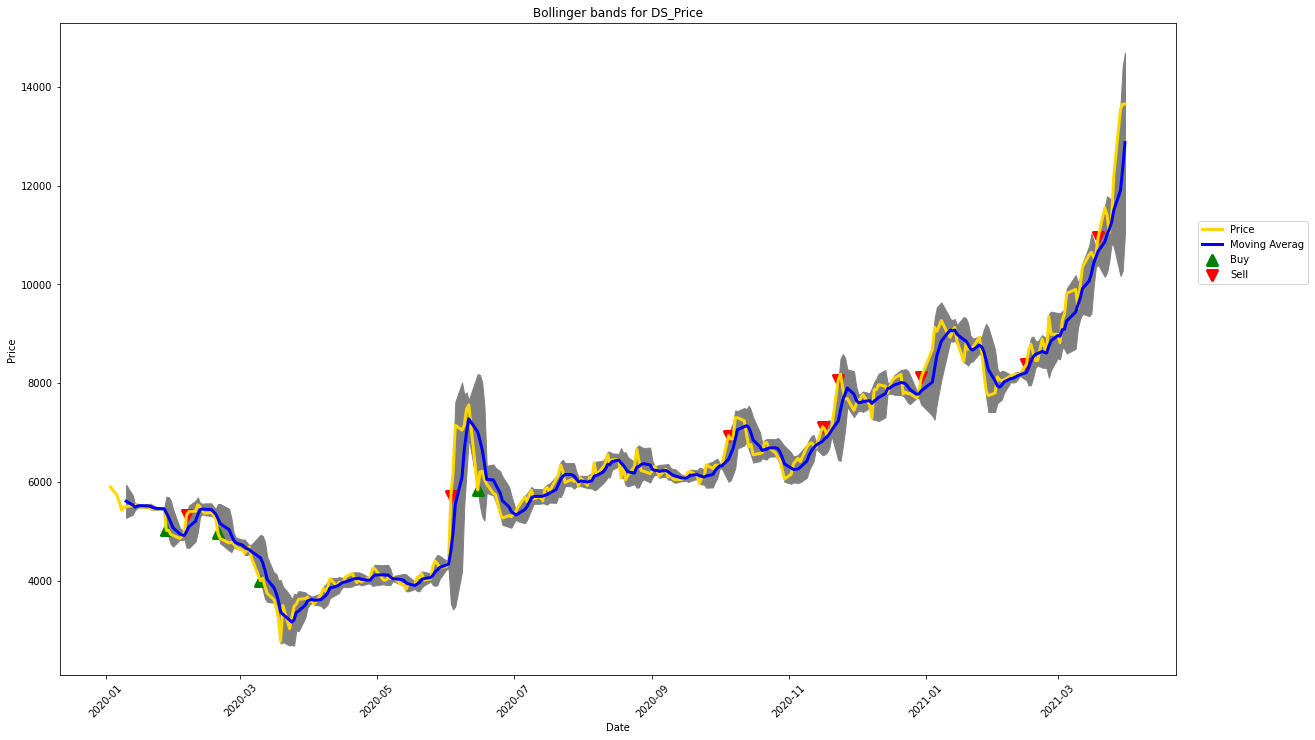

In [159]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

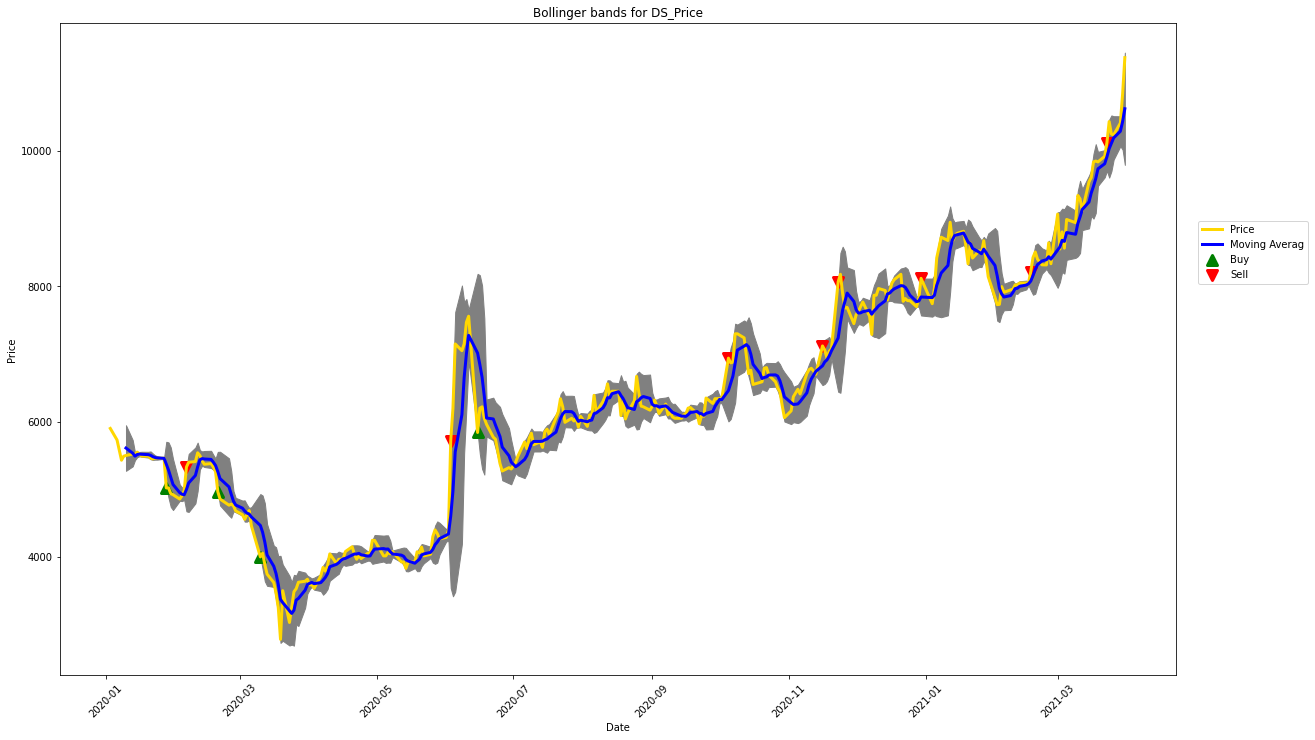

In [160]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'DS_Price', p = 5, std = 1.7)

In [161]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = predictions_df['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 46.99%


### ARIMA

In [162]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df_arima = merge_df(df1 = S_predicted_arima, df2 = KCHOL_predicted_arima, df3 = M_predicted_arima, 
                        df4 = BEEF_predicted_arima, df5 = P_predicted_arima, df6 = C_predicted_arima, 
                        df7 = IP_predicted_arima, df8 = DS_predicted_arima)

#### S Stock

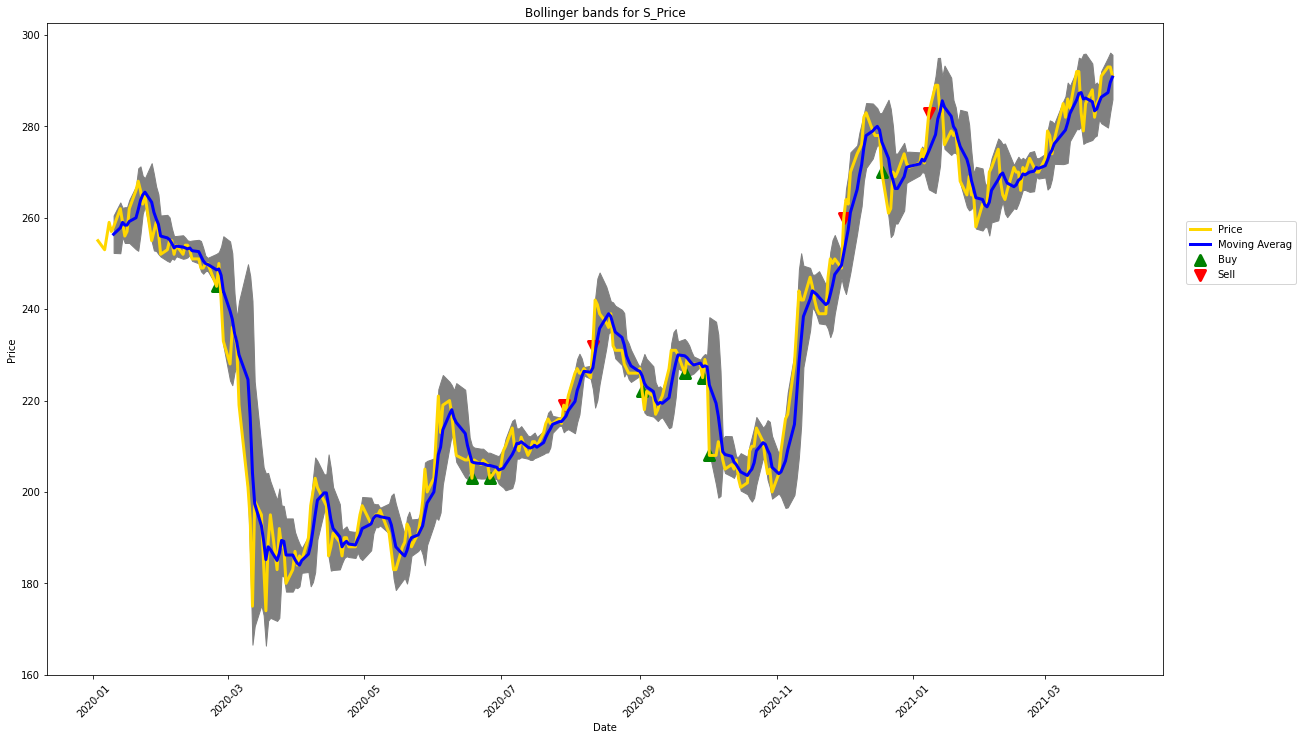

In [163]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

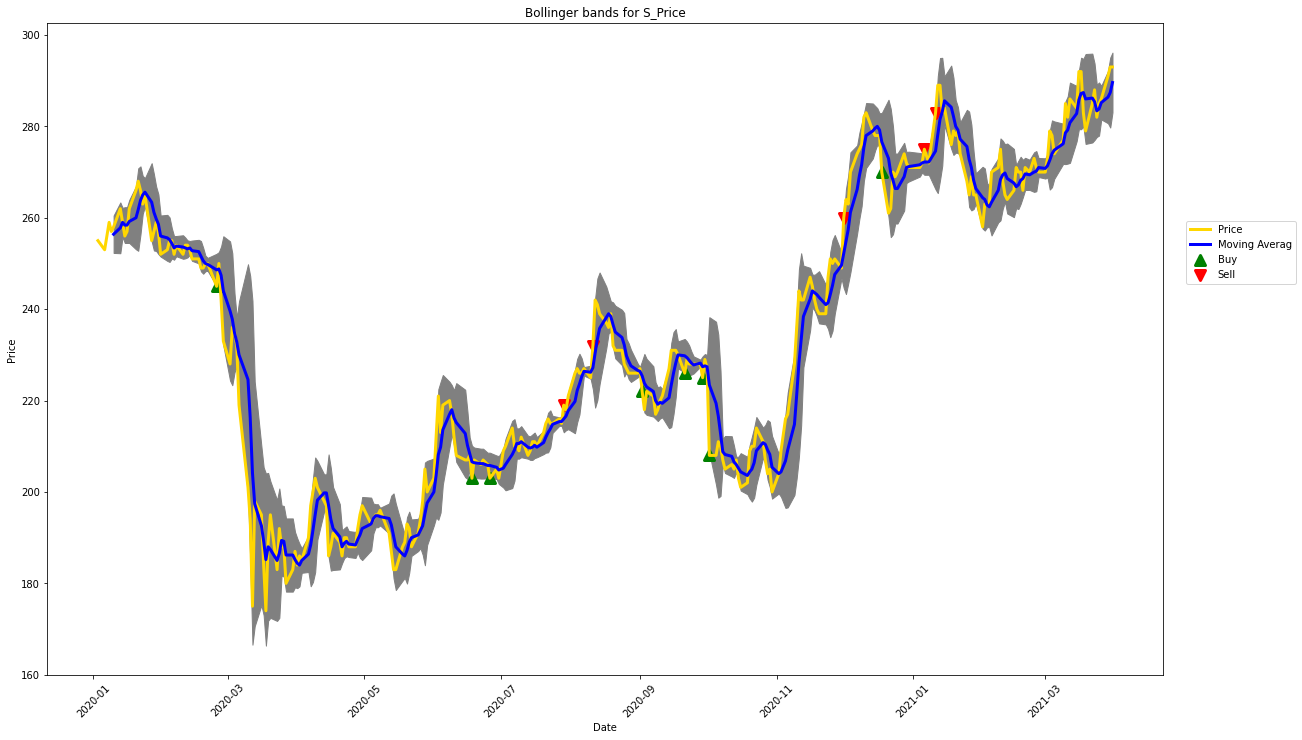

In [164]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'S_Price', p = 5, std = 1.7)

In [165]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = pred_arima['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 7.95%


#### KCHOL Stock

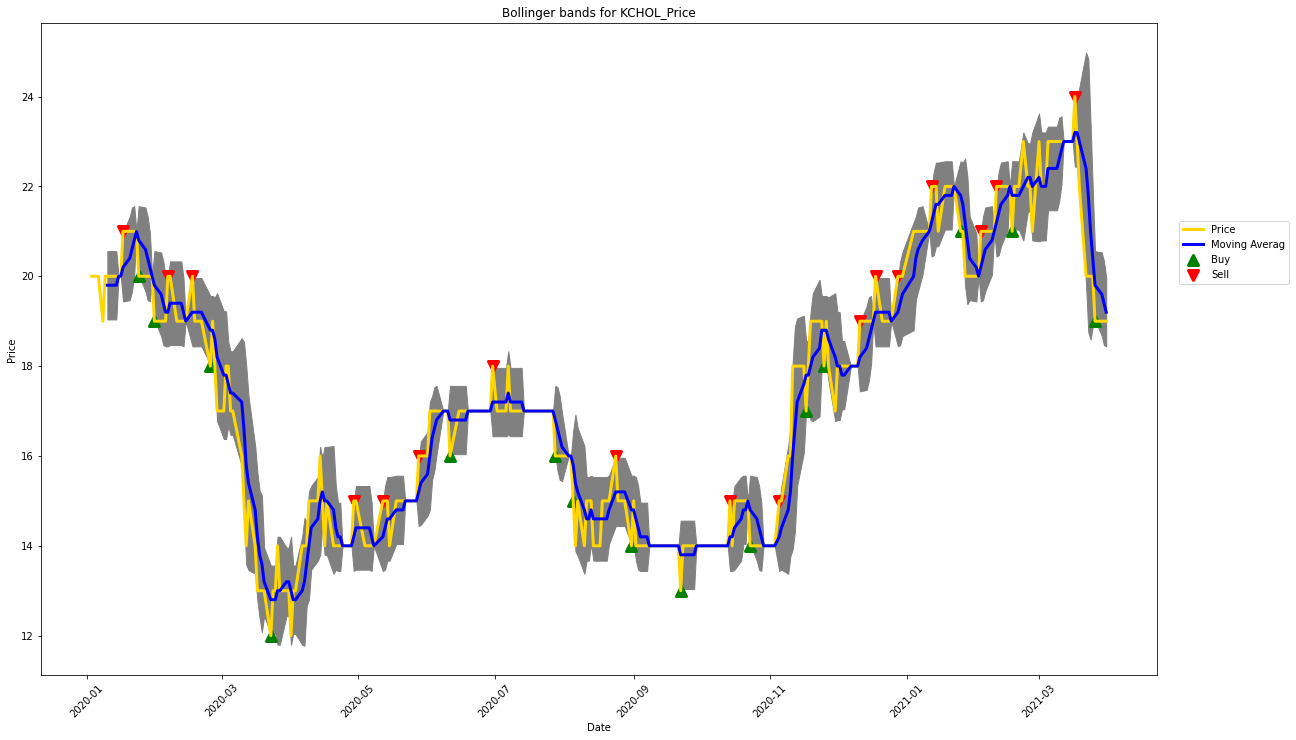

In [166]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

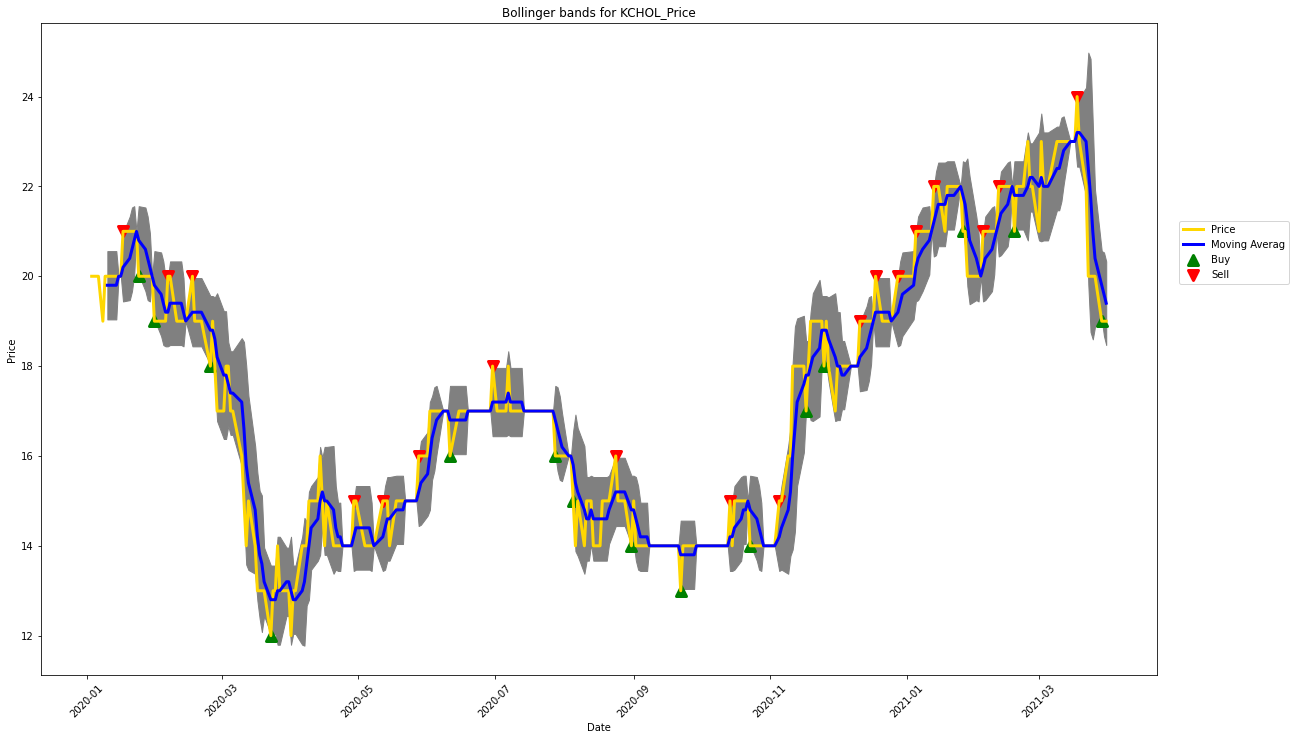

In [167]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'KCHOL_Price', p = 5, std = 1.7)

In [168]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = pred_arima['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -6.88%


#### M Stock

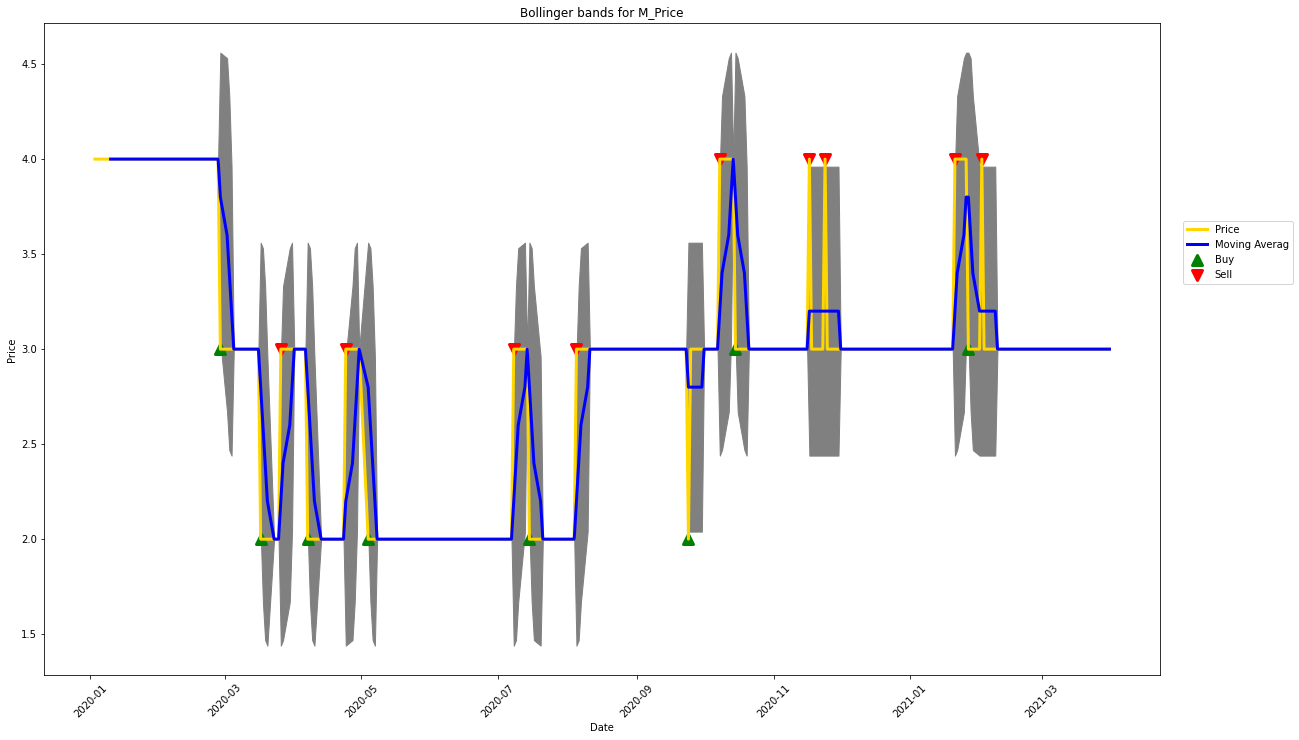

In [169]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

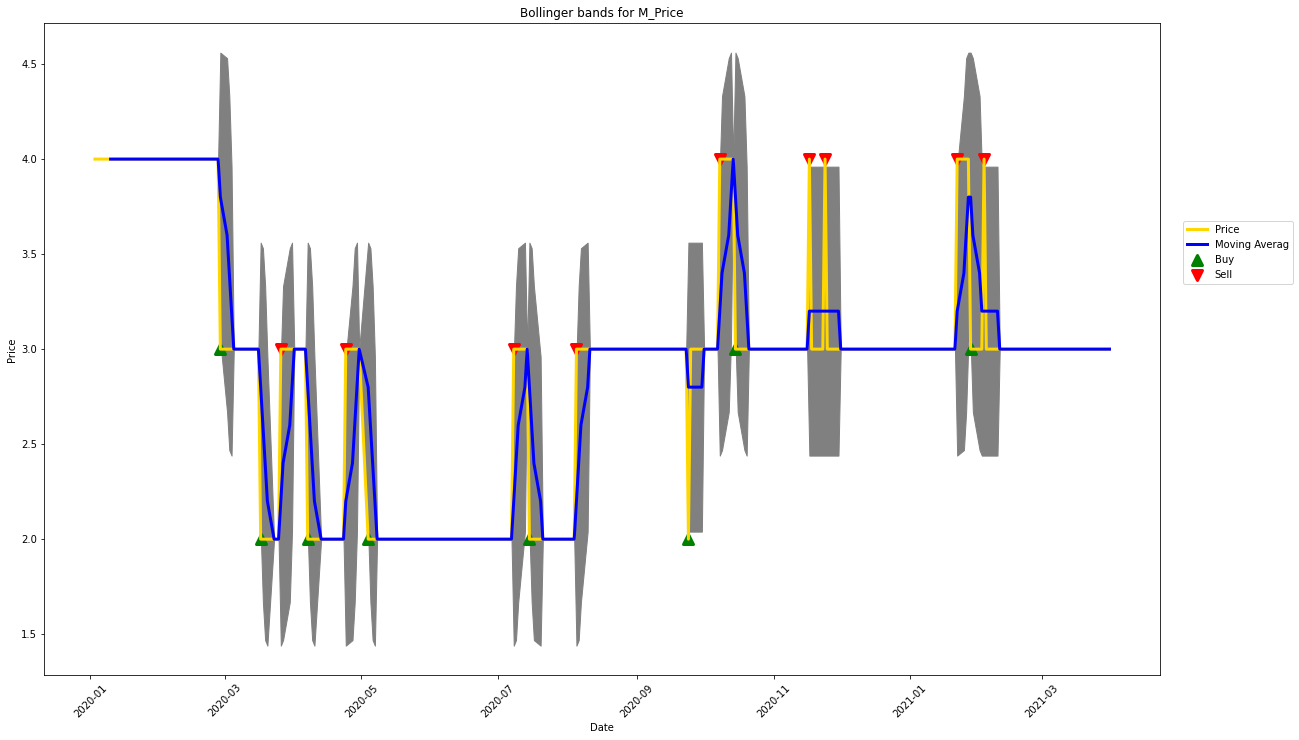

In [170]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'M_Price', p = 5, std = 1.7)

In [171]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = pred_arima['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -2.51%


#### BEEF Stock

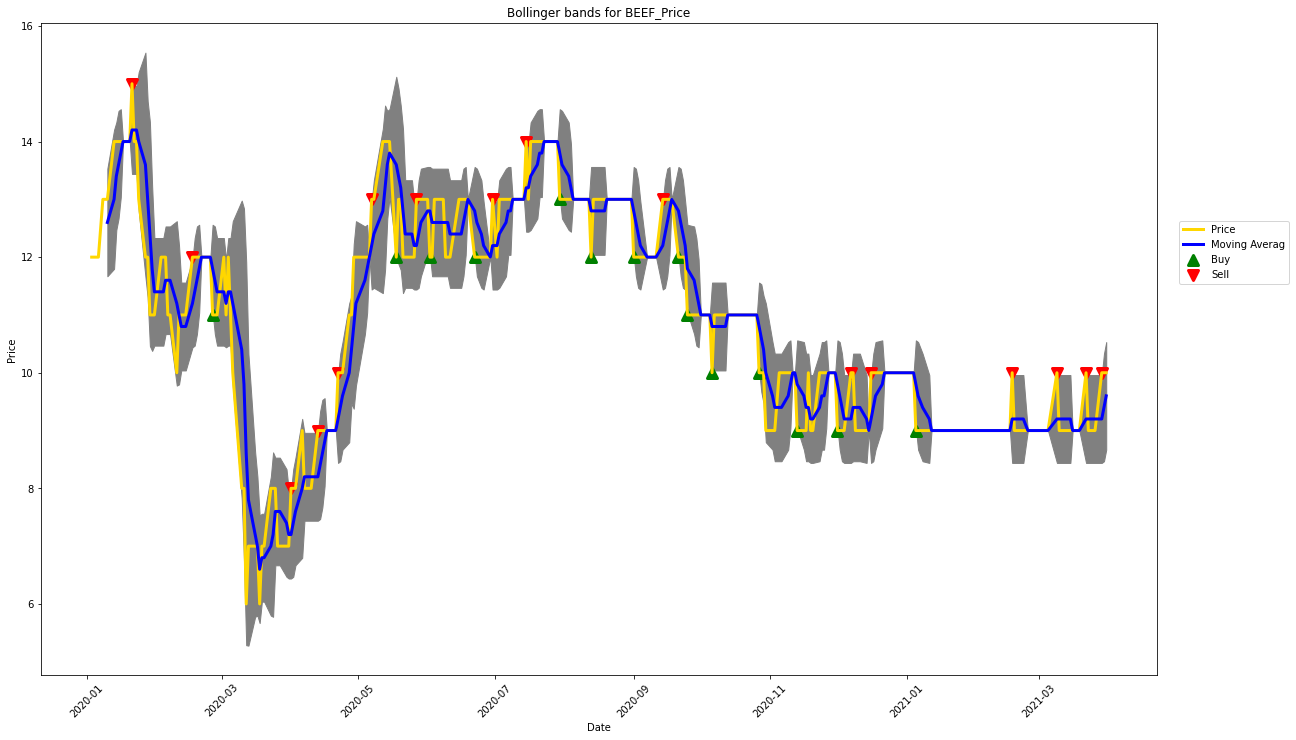

In [172]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

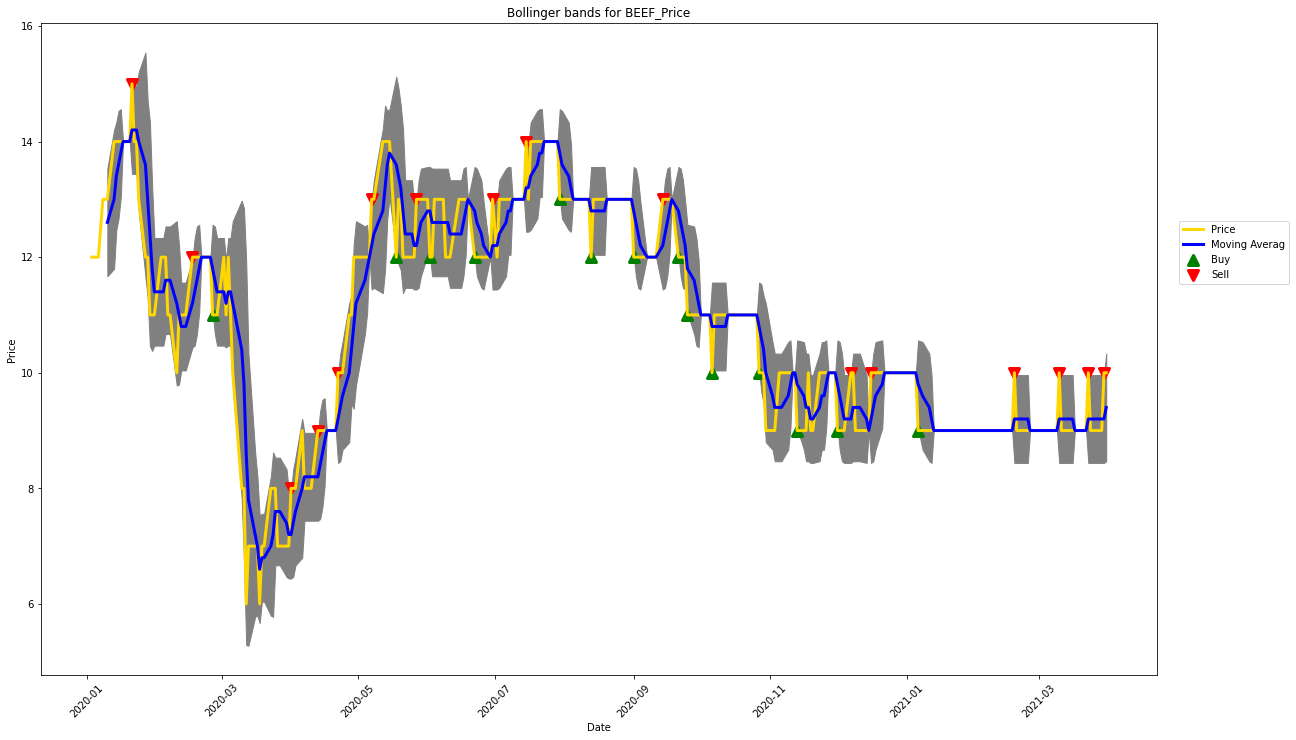

In [173]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'BEEF_Price', p = 5, std = 1.7)

In [174]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = pred_arima['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value 1.77%


#### P Stock

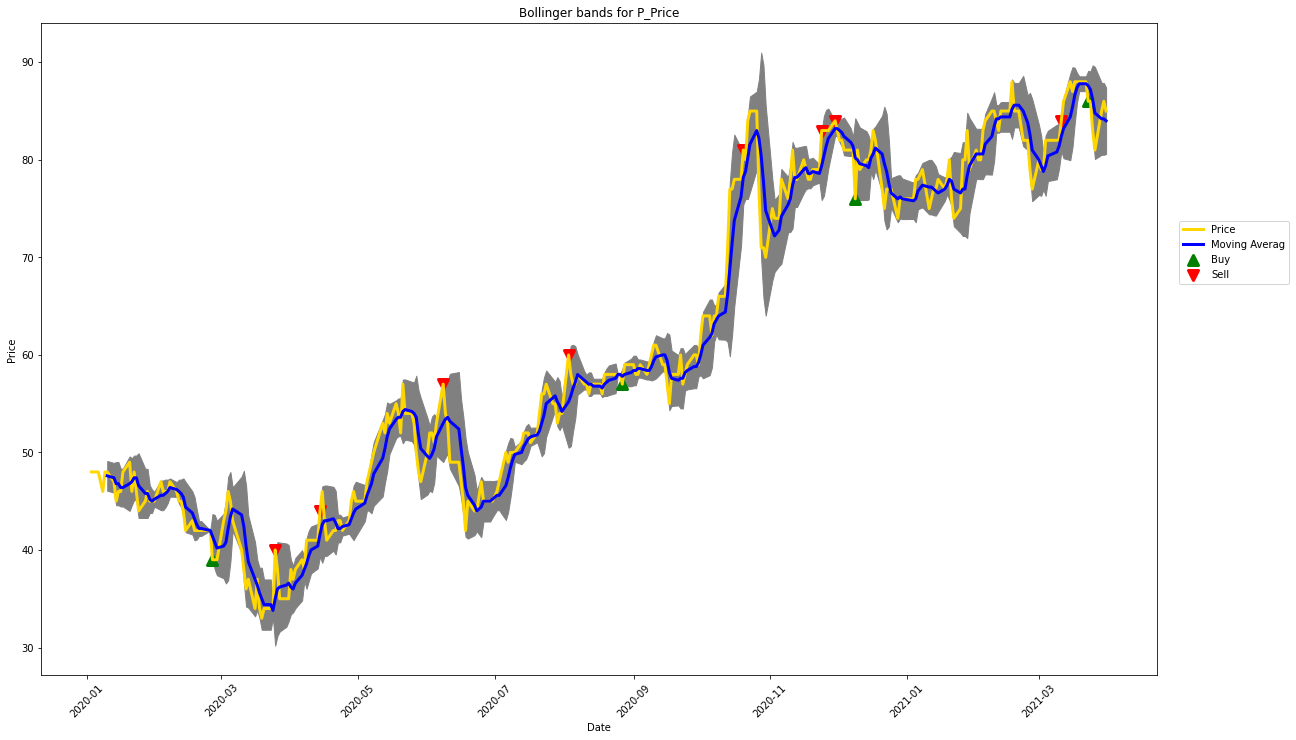

In [175]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

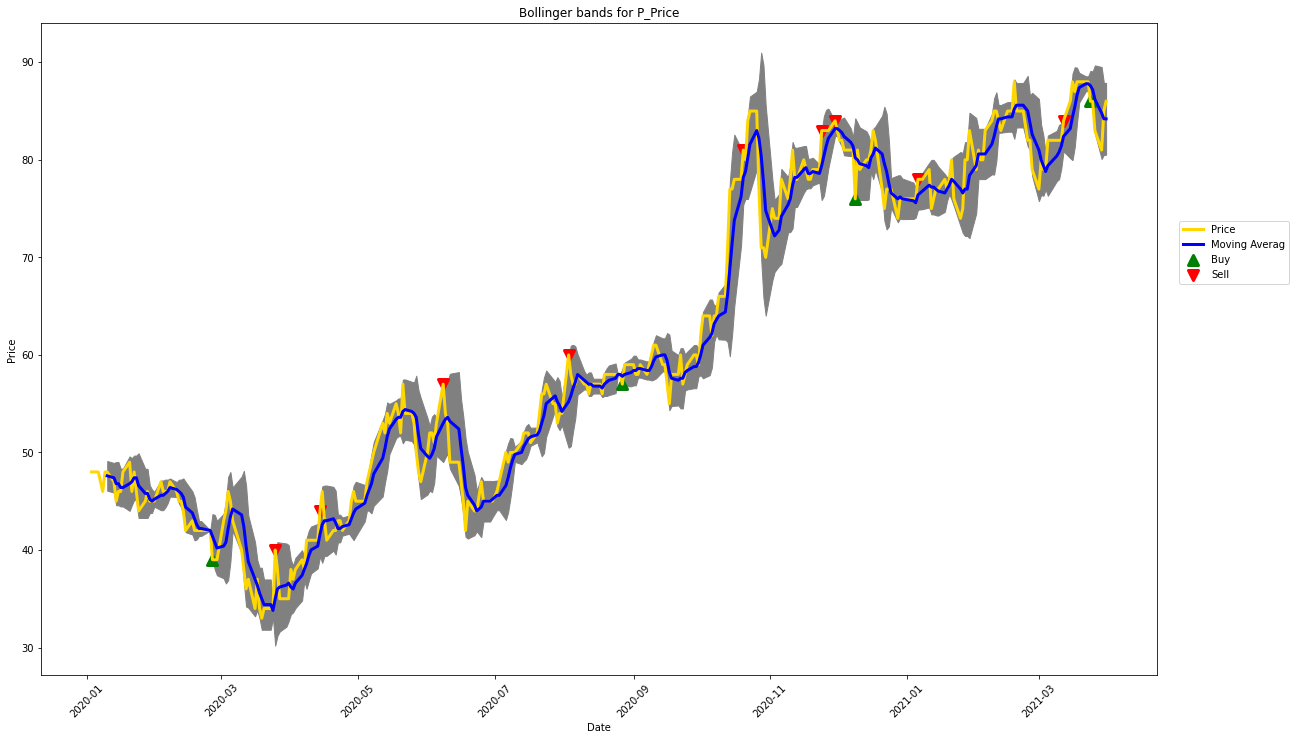

In [176]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'P_Price', p = 5, std = 1.7)

In [177]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = pred_arima['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 11.96%


#### C Stock

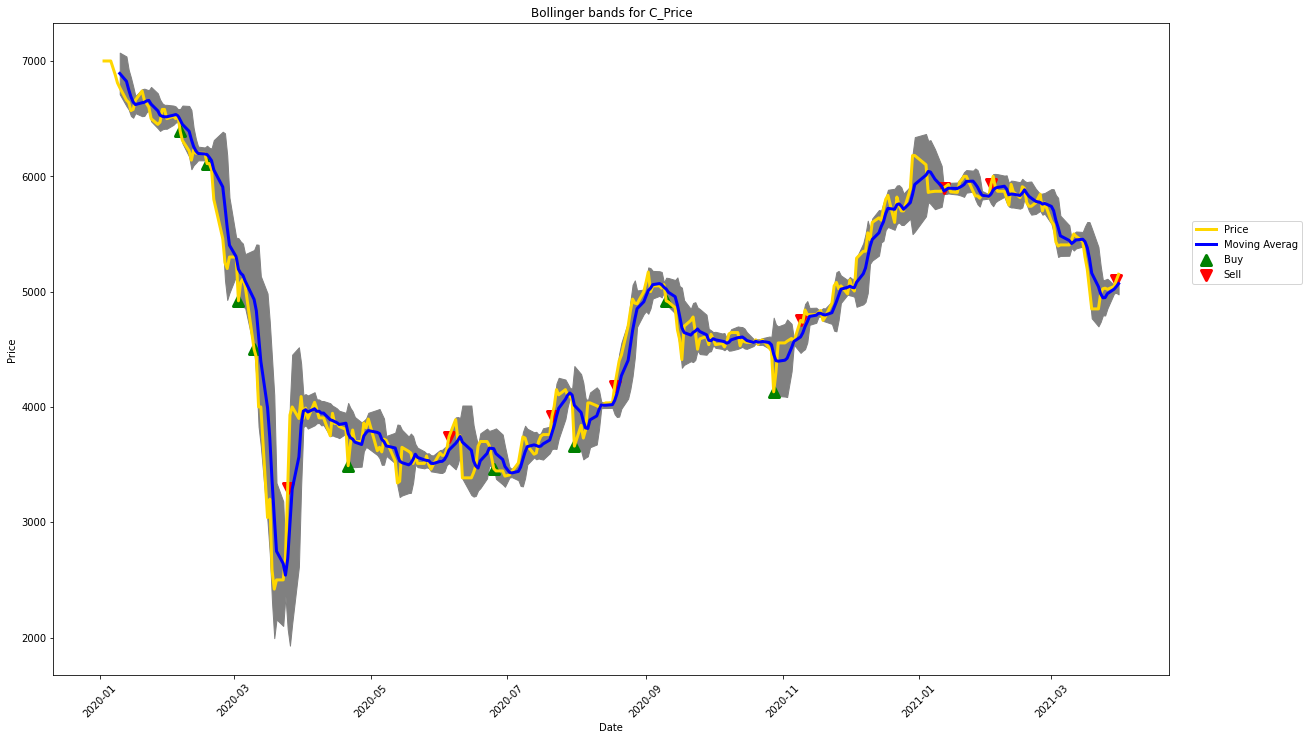

In [178]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

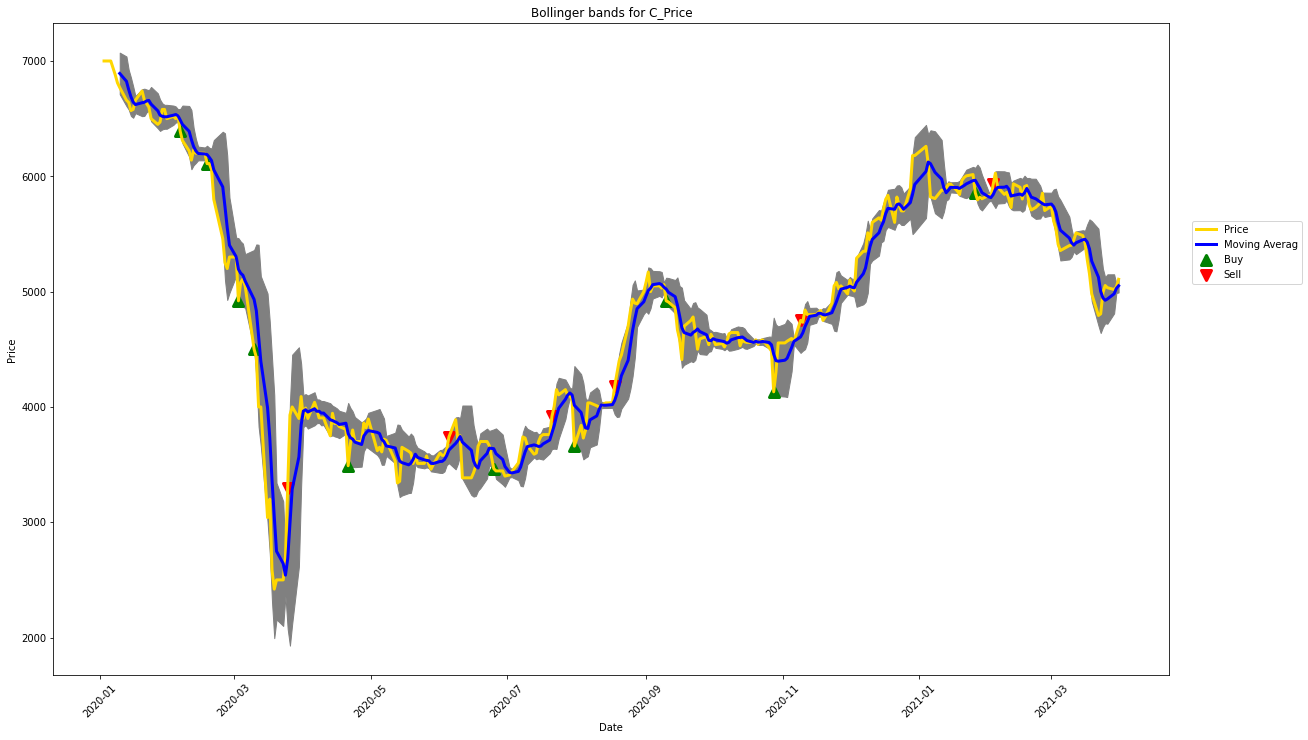

In [179]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'C_Price', p = 5, std = 1.7)

In [180]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = pred_arima['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -18.42%


#### IP Stock

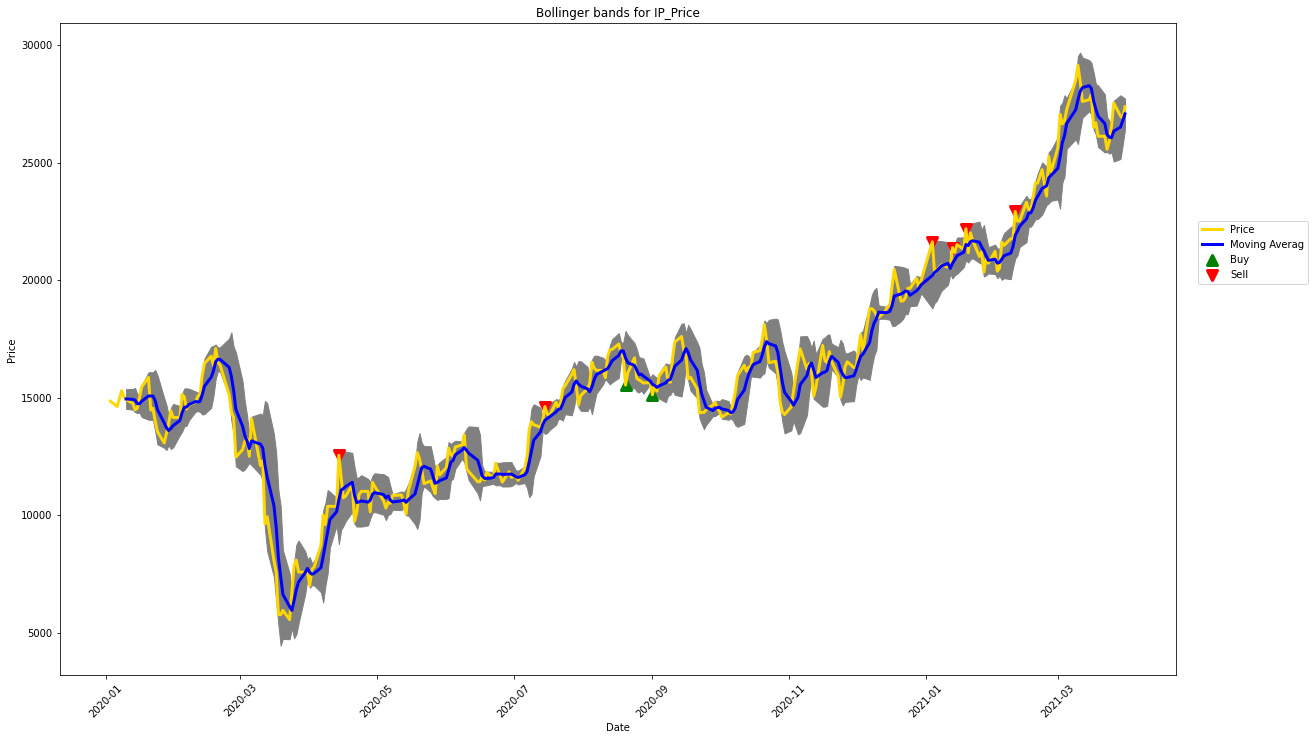

In [181]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

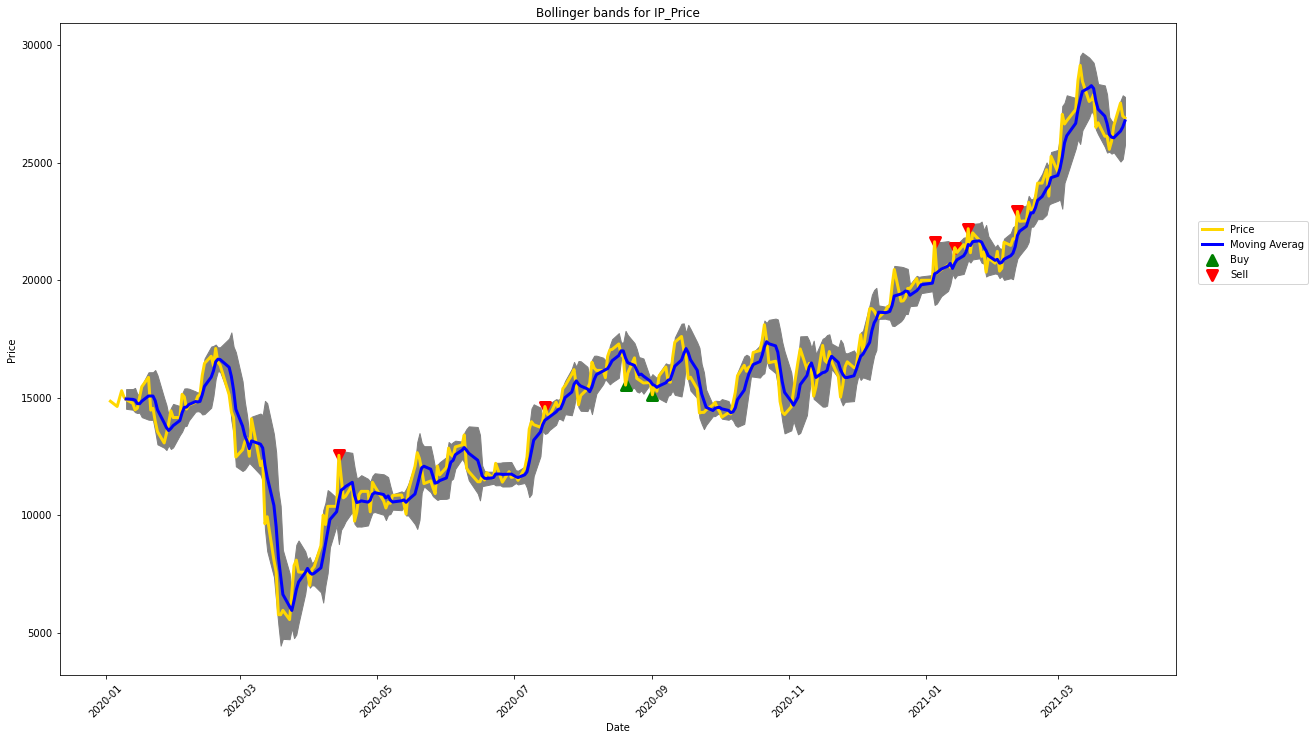

In [182]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'IP_Price', p = 5, std = 1.7)

In [183]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = pred_arima['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 34.56%


#### DS Stock

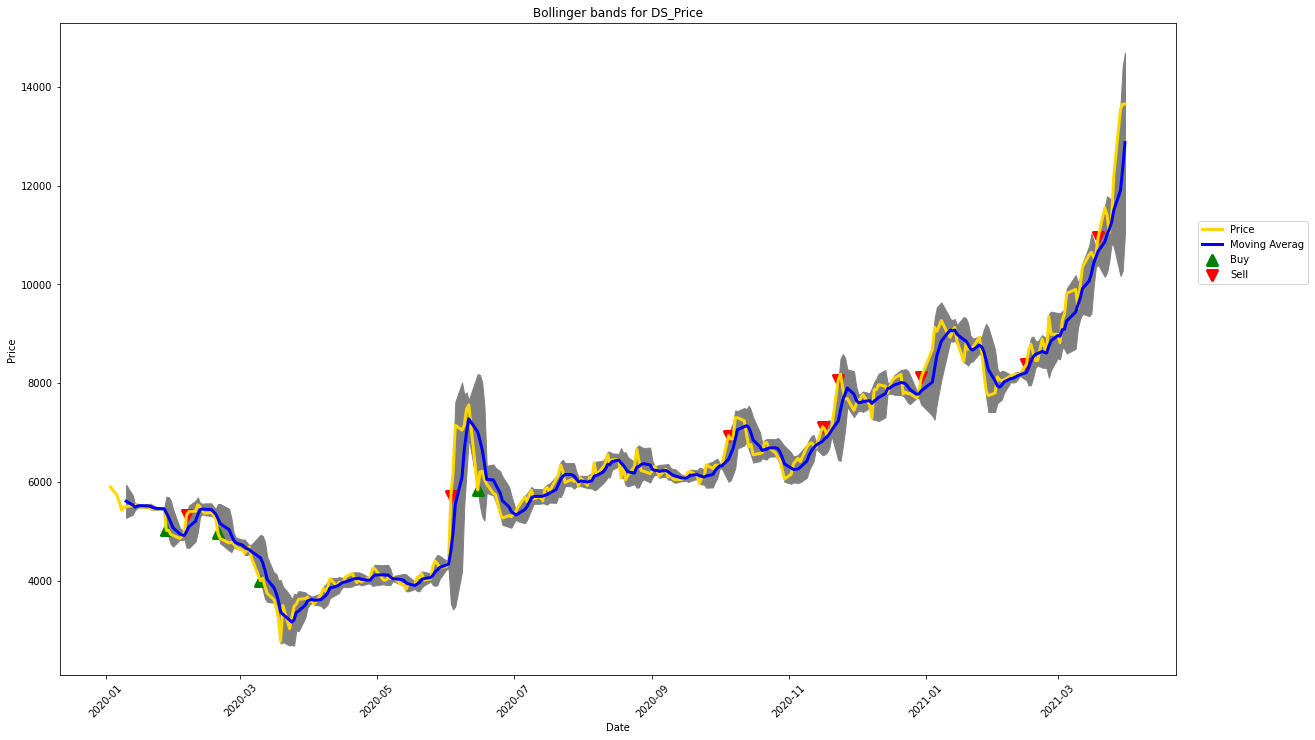

In [184]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

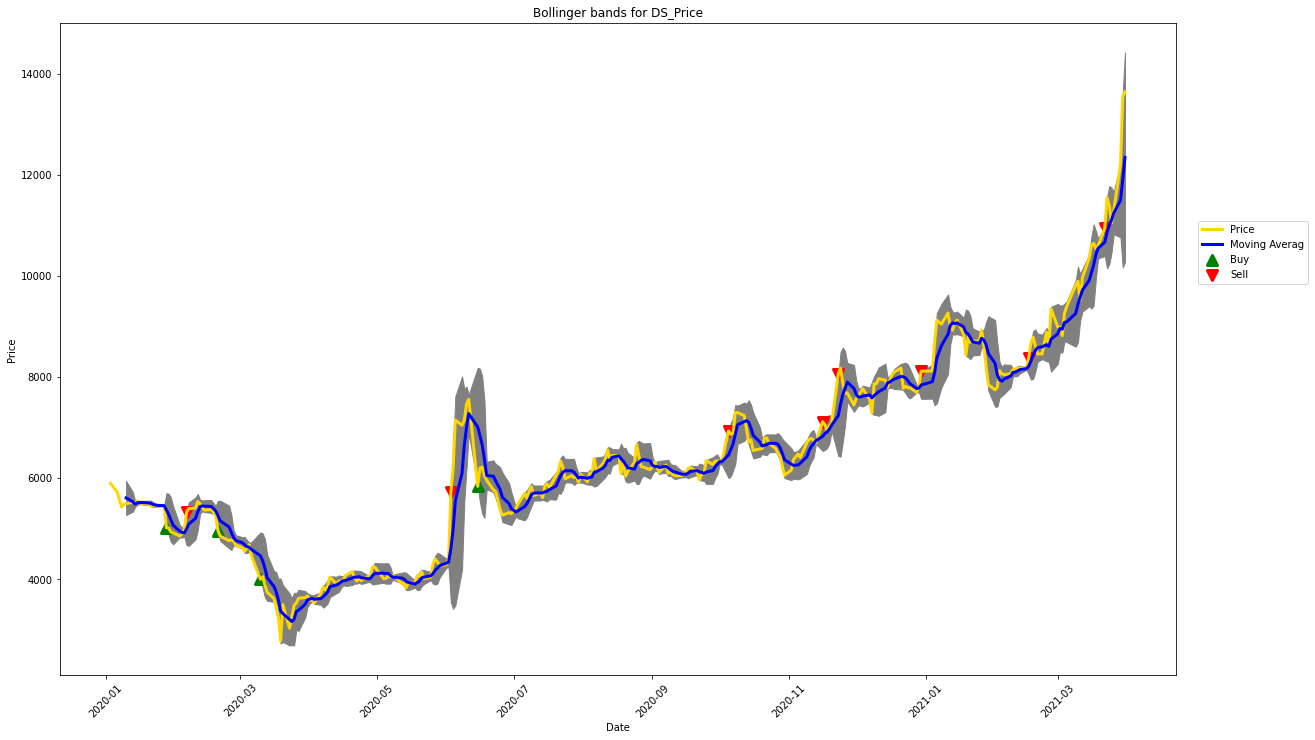

In [185]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'DS_Price', p = 5, std = 1.7)

In [186]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = pred_arima['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 68.1%


### Combining two models

In [187]:
from sklearn.metrics import mean_squared_error

In [188]:
def model_weight(col):
    x = np.arange(0,1.1, 0.1)
    y = np.arange(0,1.1, 0.1)
    squared_error = []
    weights_lstm = []
    weights_arima = []
    for i in x:
        for j in y:
            if (i+j) ==1:
                p = (i*predictions_df[col])+(j*pred_arima[col])
                e = mean_squared_error(test[col], p)
                squared_error.append(e)
                weights_lstm.append(i)
                weights_arima.append(j)
                
            else:
                pass
    return squared_error, weights_lstm, weights_arima

In [189]:
def pred_df(col):
    pred = pd.concat([train[col], weighted_predictions[col]])
    return pred

In [190]:
# The combination of the two models by weigthing the results per 0.5. 
# Didn't take approach of mean squared error because it would show to use only ARIMA

weighted_predictions = (0.5 * predictions_df) + (0.5 * pred_arima)

#### D Stock

In [191]:
# New predictions

S_predictions = pred_df(col = 'S_Price')

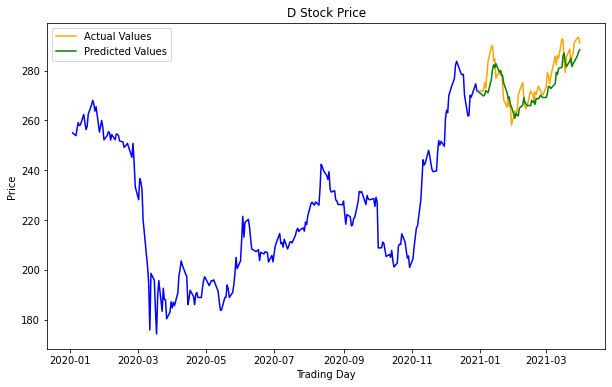

In [192]:
# Plot the Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predictions, string = 'D Stock Price')

#### KCHOL Stock

In [193]:
# New predictions

KCHOL_predictions = pred_df(col = 'KCHOL_Price')

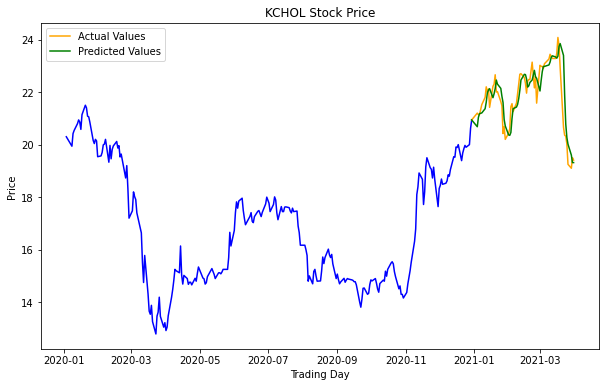

In [194]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predictions, string = 'KCHOL Stock Price')

#### M Stock

In [195]:
# New predictions

M_predictions = pred_df(col = 'M_Price')

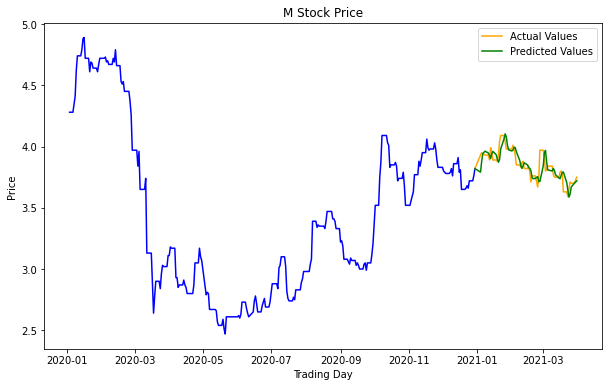

In [196]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predictions, string = 'M Stock Price')

#### BEEF Stock

In [197]:
# New predictions

BEEF_predictions = pred_df(col = 'BEEF_Price')

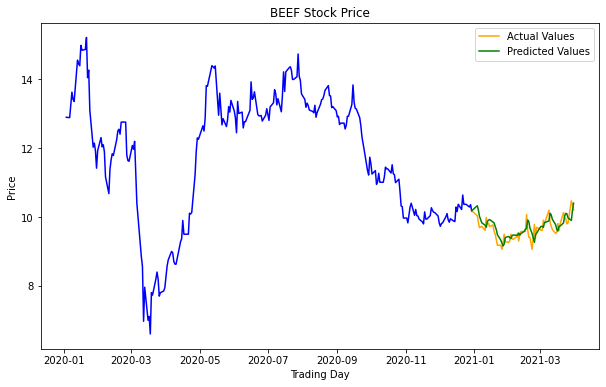

In [198]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predictions, string = 'BEEF Stock Price')

#### P Stock

In [199]:
# New predictions

P_predictions = pred_df(col = 'P_Price')

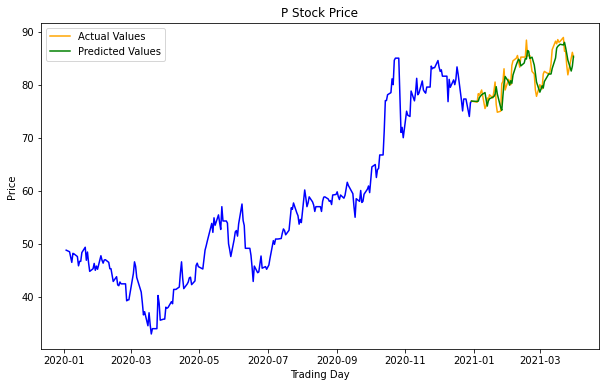

In [200]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predictions, string = 'P Stock Price')

#### C Stock

In [201]:
# New predictions

C_predictions = pred_df(col = 'C_Price')

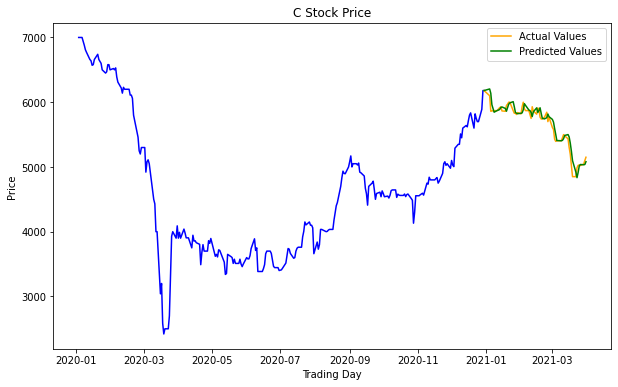

In [202]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predictions, string = 'C Stock Price')

#### IP Stock

In [203]:
# New predictions

IP_predictions = pred_df(col = 'IP_Price')

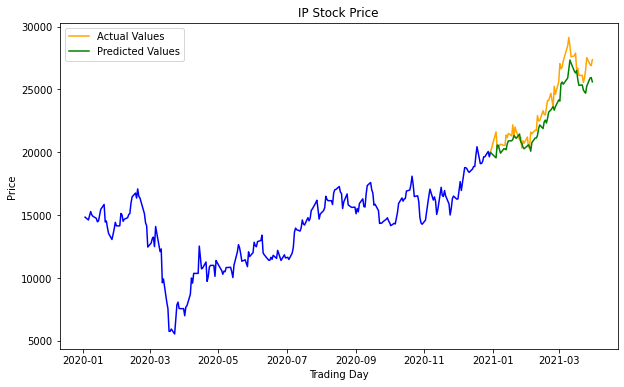

In [204]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predictions, string = 'IP Stock Price')

#### DS Stock

In [205]:
# New predictions

DS_predictions = pred_df(col = 'DS_Price')

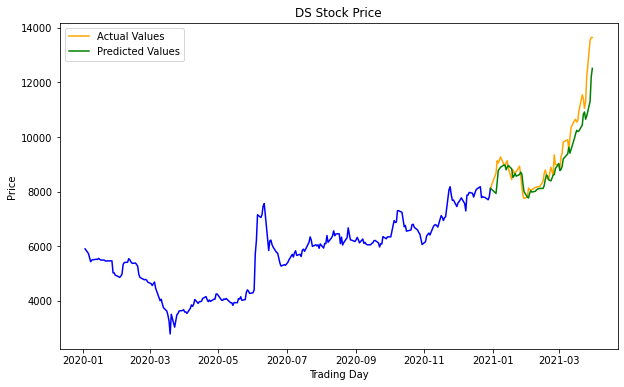

In [206]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predictions, string = 'DS Stock Price')

In [207]:
class model_reinforcement:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [208]:
def plot_signals(values):
    fig = plt.figure(figsize = (15,5))
    plt.plot(values, color='r', lw=2.)
    plt.plot(values, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(values, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

In [209]:
initial_money = 1000
window_size = 5
skip = 1
batch_size = 32

#### S Stock

##### Actual Values

In [210]:
# Define the values for the S Stock

close = S_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: -137.640000.3, cost: 0.150493, total money: 862.360000
epoch: 20, total rewards: -180.820000.3, cost: 0.124869, total money: 527.960000
epoch: 30, total rewards: -159.220000.3, cost: 0.077421, total money: 549.560000
epoch: 40, total rewards: -120.430000.3, cost: 0.057991, total money: 588.350000
epoch: 50, total rewards: -118.640000.3, cost: 0.028189, total money: 590.140000
epoch: 60, total rewards: -36.510000.3, cost: 0.030814, total money: 672.270000
epoch: 70, total rewards: 24.840000.3, cost: 0.026138, total money: 733.620000
epoch: 80, total rewards: 28.490000.3, cost: 0.025652, total money: 737.270000
epoch: 90, total rewards: 27.390000.3, cost: 0.025791, total money: 736.170000
epoch: 100, total rewards: 54.600000.3, cost: 0.023539, total money: 763.380000


In [211]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 257.990000, total balance 742.010000
day 5, sell 1 unit at price 262.400000, investment 1.709369 %, total balance 1004.410000,
day 9: buy 1 unit at price 262.500000, total balance 741.910000
day 13, sell 1 unit at price 263.730000, investment 0.468571 %, total balance 1005.640000,
day 18: buy 1 unit at price 257.310000, total balance 748.330000
day 20, sell 1 unit at price 253.990000, investment -1.290272 %, total balance 1002.320000,
day 22: buy 1 unit at price 255.200000, total balance 747.120000
day 24, sell 1 unit at price 254.300000, investment -0.352665 %, total balance 1001.420000,
day 26: buy 1 unit at price 254.500000, total balance 746.920000
day 28, sell 1 unit at price 253.890000, investment -0.239686 %, total balance 1000.810000,
day 34: buy 1 unit at price 250.800000, total balance 750.010000
day 35: buy 1 unit at price 245.190000, total balance 504.820000
day 36, sell 1 unit at price 250.800000, investment 0.000000 %, total balance 755.620000,


day 226, sell 1 unit at price 251.590000, investment 0.595762 %, total balance 1063.110000,
day 230: buy 1 unit at price 263.140000, total balance 799.970000
day 231, sell 1 unit at price 270.000000, investment 2.606977 %, total balance 1069.970000,
day 233: buy 1 unit at price 275.490000, total balance 794.480000
day 234, sell 1 unit at price 276.890000, investment 0.508185 %, total balance 1071.370000,
day 236: buy 1 unit at price 283.730000, total balance 787.640000
day 238, sell 1 unit at price 278.700000, investment -1.772812 %, total balance 1066.340000,
day 240: buy 1 unit at price 278.500000, total balance 787.840000
day 241: buy 1 unit at price 270.160000, total balance 517.680000
day 242, sell 1 unit at price 261.790000, investment -6.000000 %, total balance 779.470000,
day 243, sell 1 unit at price 262.040000, investment -3.005626 %, total balance 1041.510000,
day 251: buy 1 unit at price 275.200000, total balance 766.310000
day 252: buy 1 unit at price 272.930000, total bal

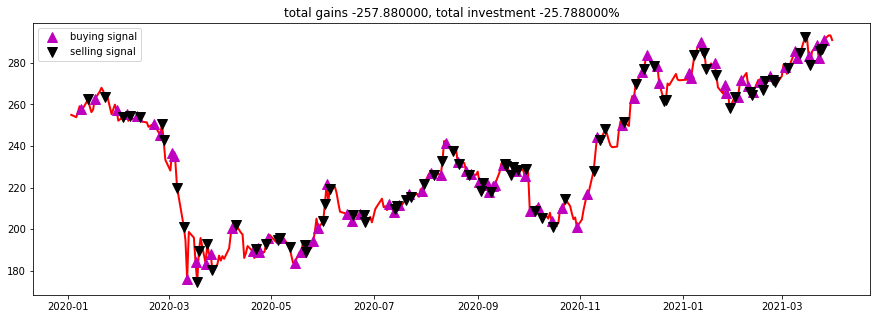

In [212]:
# Plot the results

plot_signals(values = S_actual)

##### Predicted Values

In [213]:
# Define the values for the S Stock

close = S_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 65.830035.3, cost: 0.092633, total money: 214.573416
epoch: 20, total rewards: 90.355265.3, cost: 0.067457, total money: 1090.355265
epoch: 30, total rewards: 69.809254.3, cost: 0.036080, total money: 1069.809254
epoch: 40, total rewards: 55.609960.3, cost: 0.025647, total money: 1055.609960
epoch: 50, total rewards: 20.330472.3, cost: 0.019863, total money: 1020.330472
epoch: 60, total rewards: 15.798732.3, cost: 0.014488, total money: 1015.798732
epoch: 70, total rewards: 23.726573.3, cost: 0.009672, total money: 1023.726573
epoch: 80, total rewards: 25.548838.3, cost: 0.007455, total money: 1025.548838
epoch: 90, total rewards: 38.285124.3, cost: 0.006639, total money: 1038.285124
epoch: 100, total rewards: 39.878925.3, cost: 0.006181, total money: 1039.878925


In [214]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 259.150000, total balance 740.850000
day 3, sell 1 unit at price 257.990000, investment -0.447617 %, total balance 998.840000,
day 9: buy 1 unit at price 262.500000, total balance 736.340000
day 10: buy 1 unit at price 266.280000, total balance 470.060000
day 11: buy 1 unit at price 268.060000, total balance 202.000000
day 12, sell 1 unit at price 266.540000, investment 1.539048 %, total balance 468.540000,
day 13, sell 1 unit at price 263.730000, investment -0.957639 %, total balance 732.270000,
day 14, sell 1 unit at price 265.490000, investment -0.958741 %, total balance 997.760000,
day 21: buy 1 unit at price 255.400000, total balance 742.360000
day 22, sell 1 unit at price 255.200000, investment -0.078309 %, total balance 997.560000,
day 40: buy 1 unit at price 236.630000, total balance 760.930000
day 41, sell 1 unit at price 235.270000, investment -0.574737 %, total balance 996.200000,
day 47: buy 1 unit at price 198.600000, total balance 797.600000
day

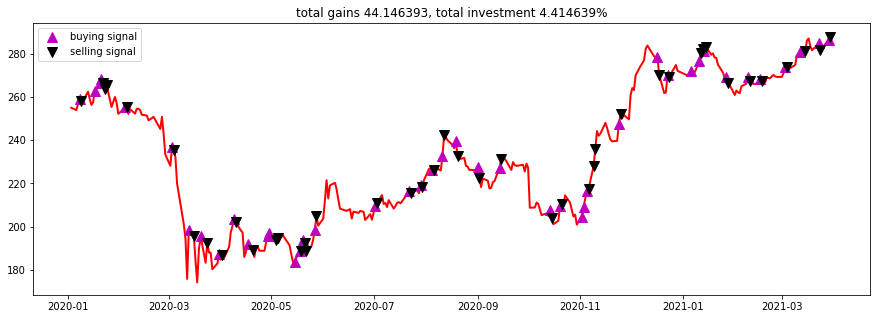

In [215]:
# Plot the results

plot_signals(values = S_predictions)

#### KCHOL Stock

##### Actual Values

In [216]:
# Define the values for the S Stock

close = KCHOL_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 66.630000.3, cost: 0.006861, total money: 966.170000
epoch: 20, total rewards: 53.660000.3, cost: 0.008821, total money: 953.200000
epoch: 30, total rewards: 50.270000.3, cost: 0.008725, total money: 949.810000
epoch: 40, total rewards: 43.270000.3, cost: 0.009431, total money: 942.810000
epoch: 50, total rewards: 37.560000.3, cost: 0.009449, total money: 937.100000
epoch: 60, total rewards: 29.620000.3, cost: 0.009677, total money: 929.160000
epoch: 70, total rewards: 19.830000.3, cost: 0.009709, total money: 919.370000
epoch: 80, total rewards: 15.130000.3, cost: 0.008982, total money: 914.670000
epoch: 90, total rewards: 4.150000.3, cost: 0.008330, total money: 944.710000
epoch: 100, total rewards: 6.700000.3, cost: 0.008080, total money: 947.260000


In [217]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 20.080000, total balance 979.920000
day 2: buy 1 unit at price 19.940000, total balance 959.980000
day 4: buy 1 unit at price 20.540000, total balance 939.440000
day 6, sell 1 unit at price 20.940000, investment 4.282869 %, total balance 960.380000,
day 7, sell 1 unit at price 20.860000, investment 4.613842 %, total balance 981.240000,
day 8, sell 1 unit at price 20.580000, investment 0.194742 %, total balance 1001.820000,
day 15: buy 1 unit at price 20.160000, total balance 981.660000
day 16: buy 1 unit at price 20.040000, total balance 961.620000
day 17: buy 1 unit at price 20.200000, total balance 941.420000
day 18: buy 1 unit at price 20.140000, total balance 921.280000
day 21, sell 1 unit at price 19.700000, investment -2.281746 %, total balance 940.980000,
day 23: buy 1 unit at price 20.020000, total balance 920.960000
day 24, sell 1 unit at price 20.200000, investment 0.798403 %, total balance 941.160000,
day 25, sell 1 unit at price 19.330000, investm

day 244: buy 1 unit at price 19.840000, total balance 978.600000
day 246, sell 1 unit at price 19.900000, investment 0.302419 %, total balance 998.500000,
day 260: buy 1 unit at price 22.300000, total balance 976.200000
day 262, sell 1 unit at price 22.000000, investment -1.345291 %, total balance 998.200000,
day 264: buy 1 unit at price 21.640000, total balance 976.560000
day 265, sell 1 unit at price 21.480000, investment -0.739372 %, total balance 998.040000,
day 266: buy 1 unit at price 20.420000, total balance 977.620000
day 267, sell 1 unit at price 20.680000, investment 1.273262 %, total balance 998.300000,
day 268: buy 1 unit at price 20.200000, total balance 978.100000
day 270: buy 1 unit at price 20.600000, total balance 957.500000
day 272: buy 1 unit at price 21.560000, total balance 935.940000
day 273, sell 1 unit at price 21.260000, investment 5.247525 %, total balance 957.200000,
day 274, sell 1 unit at price 21.580000, investment 4.757282 %, total balance 978.780000,
day

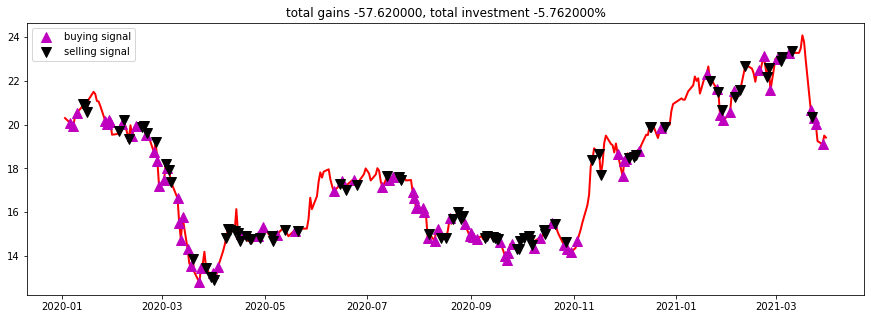

In [218]:
# Plot the results

plot_signals(values = KCHOL_actual)

##### Predicted Values

In [219]:
# Define the values for the S Stock

close = KCHOL_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -3.713324.3, cost: 0.007581, total money: 949.520543
epoch: 20, total rewards: -18.800606.3, cost: 0.004879, total money: 981.199394
epoch: 30, total rewards: 4.690073.3, cost: 0.011598, total money: 870.651138
epoch: 40, total rewards: -9.784199.3, cost: 0.005696, total money: 966.819394
epoch: 50, total rewards: -3.634472.3, cost: 0.006993, total money: 949.599394
epoch: 60, total rewards: -5.054472.3, cost: 0.006980, total money: 948.179394
epoch: 70, total rewards: -6.997680.3, cost: 0.002824, total money: 993.002320
epoch: 80, total rewards: -8.003417.3, cost: 0.001907, total money: 991.996583
epoch: 90, total rewards: -0.611706.3, cost: 0.004600, total money: 999.388294
epoch: 100, total rewards: -4.287680.3, cost: 0.002522, total money: 995.712320


In [220]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 11: buy 1 unit at price 21.400000, total balance 978.600000
day 12: buy 1 unit at price 21.080000, total balance 957.520000
day 13: buy 1 unit at price 21.060000, total balance 936.460000
day 14, sell 1 unit at price 20.860000, investment -2.523364 %, total balance 957.320000,
day 15, sell 1 unit at price 20.160000, investment -4.364326 %, total balance 977.480000,
day 16, sell 1 unit at price 20.040000, investment -4.843305 %, total balance 997.520000,
day 19: buy 1 unit at price 19.540000, total balance 977.980000
day 21: buy 1 unit at price 19.700000, total balance 958.280000
day 23, sell 1 unit at price 20.020000, investment 2.456499 %, total balance 978.300000,
day 25, sell 1 unit at price 19.330000, investment -1.878173 %, total balance 997.630000,
day 31: buy 1 unit at price 19.870000, total balance 977.760000
day 33, sell 1 unit at price 19.530000, investment -1.711122 %, total balance 997.290000,
day 38: buy 1 unit at price 17.200000, total balance 980.090000
day 39, sell 

day 226, sell 1 unit at price 18.680000, investment 27.334697 %, total balance 832.150000,
day 227: buy 1 unit at price 17.640000, total balance 814.510000
day 229, sell 1 unit at price 18.450000, investment 24.577988 %, total balance 832.960000,
day 230: buy 1 unit at price 18.690000, total balance 814.270000
day 231: buy 1 unit at price 18.490000, total balance 795.780000
day 233: buy 1 unit at price 18.620000, total balance 777.160000
day 235, sell 1 unit at price 18.800000, investment 27.027027 %, total balance 795.960000,
day 238, sell 1 unit at price 19.520000, investment 26.016785 %, total balance 815.480000,
day 242, sell 1 unit at price 19.390000, investment 25.420440 %, total balance 834.870000,
day 244: buy 1 unit at price 19.840000, total balance 815.030000
day 246: buy 1 unit at price 19.900000, total balance 795.130000
day 249, sell 1 unit at price 20.940000, investment 39.879760 %, total balance 816.070000,
day 250: buy 1 unit at price 20.681637, total balance 795.388363

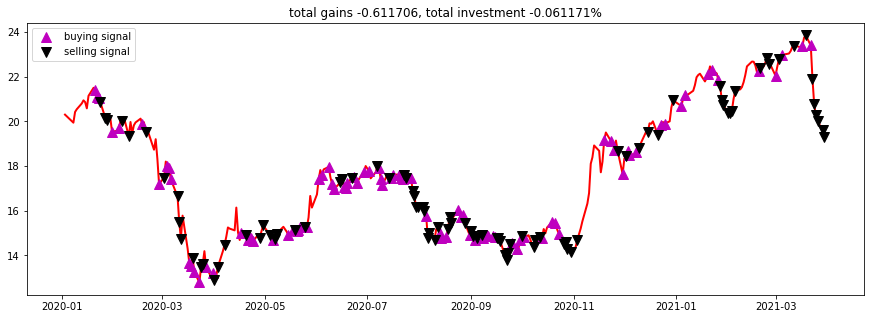

In [221]:
# Plot the results

plot_signals(values = KCHOL_predictions)

#### M Stock

##### Actual Values

In [222]:
# Define the values for the S Stock

close = M_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 10.060000.3, cost: 0.033156, total money: 682.220000
epoch: 20, total rewards: 2.910000.3, cost: 0.023285, total money: 733.360000
epoch: 30, total rewards: 7.340000.3, cost: 0.014735, total money: 791.190000
epoch: 40, total rewards: 6.710000.3, cost: 0.011214, total money: 821.580000
epoch: 50, total rewards: 3.200000.3, cost: 0.008125, total money: 844.900000
epoch: 60, total rewards: 5.360000.3, cost: 0.006595, total money: 865.900000
epoch: 70, total rewards: 6.840000.3, cost: 0.006152, total money: 874.940000
epoch: 80, total rewards: 6.080000.3, cost: 0.005135, total money: 885.780000
epoch: 90, total rewards: 3.500000.3, cost: 0.004644, total money: 890.970000
epoch: 100, total rewards: 3.920000.3, cost: 0.005163, total money: 883.620000


In [223]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 4.410000, total balance 995.590000
day 3: buy 1 unit at price 4.620000, total balance 990.970000
day 4: buy 1 unit at price 4.740000, total balance 986.230000
day 5: buy 1 unit at price 4.740000, total balance 981.490000
day 8: buy 1 unit at price 4.890000, total balance 976.600000
day 9, sell 1 unit at price 4.720000, investment 7.029478 %, total balance 981.320000,
day 11: buy 1 unit at price 4.610000, total balance 976.710000
day 12: buy 1 unit at price 4.690000, total balance 972.020000
day 13, sell 1 unit at price 4.680000, investment 1.298701 %, total balance 976.700000,
day 14, sell 1 unit at price 4.640000, investment -2.109705 %, total balance 981.340000,
day 15, sell 1 unit at price 4.640000, investment -2.109705 %, total balance 985.980000,
day 17: buy 1 unit at price 4.670000, total balance 981.310000
day 18: buy 1 unit at price 4.720000, total balance 976.590000
day 19: buy 1 unit at price 4.720000, total balance 971.870000
day 20, sell 1 unit at

day 216: buy 1 unit at price 3.950000, total balance 867.290000
day 217: buy 1 unit at price 3.950000, total balance 863.340000
day 218: buy 1 unit at price 4.060000, total balance 859.280000
day 219: buy 1 unit at price 3.990000, total balance 855.290000
day 222: buy 1 unit at price 3.980000, total balance 851.310000
day 223: buy 1 unit at price 4.030000, total balance 847.280000
day 224, sell 1 unit at price 3.980000, investment 40.636042 %, total balance 851.260000,
day 225, sell 1 unit at price 3.890000, investment 33.219178 %, total balance 855.150000,
day 228, sell 1 unit at price 3.830000, investment 28.523490 %, total balance 858.980000,
day 229, sell 1 unit at price 3.800000, investment 27.516779 %, total balance 862.780000,
day 230, sell 1 unit at price 3.790000, investment 23.051948 %, total balance 866.570000,
day 232, sell 1 unit at price 3.780000, investment 11.504425 %, total balance 870.350000,
day 233, sell 1 unit at price 3.790000, investment 11.799410 %, total balanc

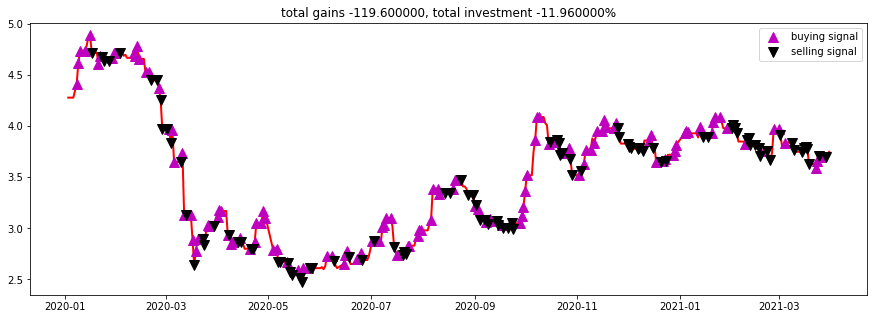

In [224]:
# Plot the results

plot_signals(values = M_actual)

##### Predicted Values

In [225]:
# Define the values for the S Stock

close = M_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -9.117748.3, cost: 0.039946, total money: 619.737708
epoch: 20, total rewards: 5.506342.3, cost: 0.028738, total money: 675.539299
epoch: 30, total rewards: 8.233920.3, cost: 0.018226, total money: 739.875336
epoch: 40, total rewards: 14.894451.3, cost: 0.010539, total money: 798.163892
epoch: 50, total rewards: 14.994451.3, cost: 0.006130, total money: 839.453892
epoch: 60, total rewards: 9.330407.3, cost: 0.003749, total money: 868.255802
epoch: 70, total rewards: 10.468044.3, cost: 0.003399, total money: 872.591078
epoch: 80, total rewards: 10.109465.3, cost: 0.001980, total money: 899.311070
epoch: 90, total rewards: 11.300220.3, cost: 0.001683, total money: 904.772581
epoch: 100, total rewards: 8.460220.3, cost: 0.002145, total money: 894.215112


In [226]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 4.410000, total balance 995.590000
day 3: buy 1 unit at price 4.620000, total balance 990.970000
day 4: buy 1 unit at price 4.740000, total balance 986.230000
day 5, sell 1 unit at price 4.740000, investment 7.482993 %, total balance 990.970000,
day 6, sell 1 unit at price 4.790000, investment 3.679654 %, total balance 995.760000,
day 7, sell 1 unit at price 4.880000, investment 2.953586 %, total balance 1000.640000,
day 10: buy 1 unit at price 4.720000, total balance 995.920000
day 11: buy 1 unit at price 4.610000, total balance 991.310000
day 12: buy 1 unit at price 4.690000, total balance 986.620000
day 16, sell 1 unit at price 4.610000, investment -2.330508 %, total balance 991.230000,
day 17: buy 1 unit at price 4.670000, total balance 986.560000
day 18: buy 1 unit at price 4.720000, total balance 981.840000
day 19, sell 1 unit at price 4.720000, investment 2.386117 %, total balance 986.560000,
day 21, sell 1 unit at price 4.730000, investment 0.852878 %

day 232, sell 1 unit at price 3.780000, investment 23.529412 %, total balance 910.510000,
day 233, sell 1 unit at price 3.790000, investment 24.262295 %, total balance 914.300000,
day 234, sell 1 unit at price 3.820000, investment 25.657895 %, total balance 918.120000,
day 236: buy 1 unit at price 3.860000, total balance 914.260000
day 237, sell 1 unit at price 3.860000, investment 26.557377 %, total balance 918.120000,
day 238: buy 1 unit at price 3.910000, total balance 914.210000
day 240: buy 1 unit at price 3.810000, total balance 910.400000
day 242: buy 1 unit at price 3.650000, total balance 906.750000
day 243: buy 1 unit at price 3.660000, total balance 903.090000
day 244: buy 1 unit at price 3.680000, total balance 899.410000
day 246: buy 1 unit at price 3.720000, total balance 895.690000
day 247, sell 1 unit at price 3.720000, investment 21.967213 %, total balance 899.410000,
day 248: buy 1 unit at price 3.760000, total balance 895.650000
day 249, sell 1 unit at price 3.820000

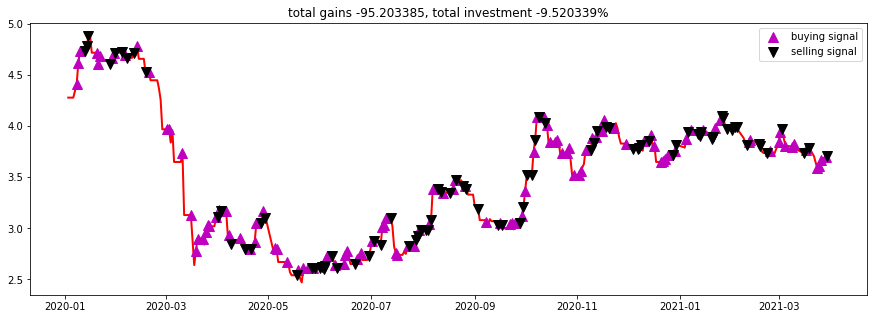

In [227]:
# Plot the results

plot_signals(values = M_predictions)

#### BEEF Stock

##### Actual Values

In [228]:
# Define the values for the S Stock

close = BEEF_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 5.210000.3, cost: 0.000996, total money: 1005.210000
epoch: 20, total rewards: 5.790000.3, cost: 0.000860, total money: 1005.790000
epoch: 30, total rewards: 2.870000.3, cost: 0.000870, total money: 1002.870000
epoch: 40, total rewards: 1.790000.3, cost: 0.001142, total money: 1001.790000
epoch: 50, total rewards: 5.080000.3, cost: 0.000821, total money: 1005.080000
epoch: 60, total rewards: 2.960000.3, cost: 0.000810, total money: 1002.960000
epoch: 70, total rewards: 4.280000.3, cost: 0.000741, total money: 1004.280000
epoch: 80, total rewards: 6.820000.3, cost: 0.000695, total money: 1006.820000
epoch: 90, total rewards: 3.490000.3, cost: 0.000717, total money: 1003.490000
epoch: 100, total rewards: 3.390000.3, cost: 0.000697, total money: 1003.390000


In [229]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 13.420000, total balance 986.580000
day 4, sell 1 unit at price 13.360000, investment -0.447094 %, total balance 999.940000,
day 6: buy 1 unit at price 14.450000, total balance 985.490000
day 7, sell 1 unit at price 14.400000, investment -0.346021 %, total balance 999.890000,
day 8: buy 1 unit at price 14.990000, total balance 984.900000
day 9, sell 1 unit at price 14.850000, investment -0.933956 %, total balance 999.750000,
day 11: buy 1 unit at price 15.220000, total balance 984.530000
day 12: buy 1 unit at price 14.050000, total balance 970.480000
day 13, sell 1 unit at price 14.270000, investment -6.241787 %, total balance 984.750000,
day 14: buy 1 unit at price 13.100000, total balance 971.650000
day 15, sell 1 unit at price 12.030000, investment -14.377224 %, total balance 983.680000,
day 16: buy 1 unit at price 12.150000, total balance 971.530000
day 17: buy 1 unit at price 11.930000, total balance 959.600000
day 18, sell 1 unit at price 11.420000, inv

day 248, sell 1 unit at price 10.360000, investment 1.968504 %, total balance 962.640000,
day 249: buy 1 unit at price 10.180000, total balance 952.460000
day 250, sell 1 unit at price 10.040000, investment -1.761252 %, total balance 962.500000,
day 251: buy 1 unit at price 9.840000, total balance 952.660000
day 252: buy 1 unit at price 9.690000, total balance 942.970000
day 253, sell 1 unit at price 9.730000, investment -6.171649 %, total balance 952.700000,
day 254, sell 1 unit at price 9.610000, investment -7.328833 %, total balance 962.310000,
day 255, sell 1 unit at price 9.990000, investment -2.915452 %, total balance 972.300000,
day 256: buy 1 unit at price 9.800000, total balance 962.500000
day 257, sell 1 unit at price 9.820000, investment -3.536346 %, total balance 972.320000,
day 258: buy 1 unit at price 9.720000, total balance 962.600000
day 259, sell 1 unit at price 9.770000, investment -0.711382 %, total balance 972.370000,
day 260: buy 1 unit at price 9.580000, total bal

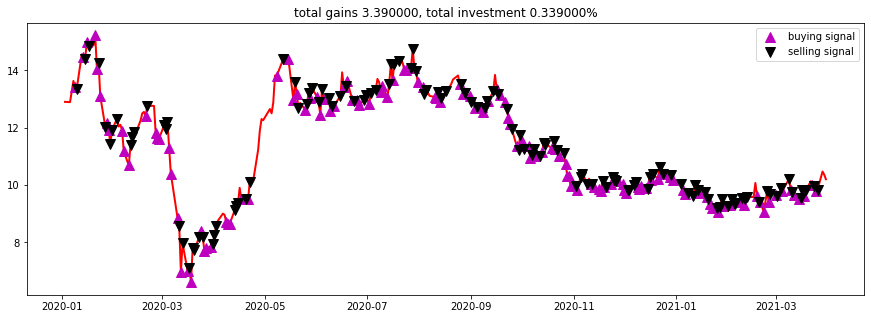

In [230]:
# Plot the results

plot_signals(values = BEEF_actual)

##### Predicted Values

In [231]:
# Define the values for the S Stock

close = BEEF_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -34.290778.3, cost: 0.023082, total money: 743.533458
epoch: 20, total rewards: -37.690841.3, cost: 0.026828, total money: 710.338195
epoch: 30, total rewards: -40.601939.3, cost: 0.028582, total money: 697.841634
epoch: 40, total rewards: -43.141889.3, cost: 0.031589, total money: 675.324756
epoch: 50, total rewards: -42.275181.3, cost: 0.034062, total money: 656.312746
epoch: 60, total rewards: -44.335181.3, cost: 0.031925, total money: 664.052746
epoch: 70, total rewards: -41.991677.3, cost: 0.033009, total money: 656.927287
epoch: 80, total rewards: -43.330134.3, cost: 0.021156, total money: 734.264177
epoch: 90, total rewards: -47.160134.3, cost: 0.021442, total money: 720.929334
epoch: 100, total rewards: -37.100281.3, cost: 0.013631, total money: 770.816794


In [232]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 16: buy 1 unit at price 12.150000, total balance 987.850000
day 17: buy 1 unit at price 11.930000, total balance 975.920000
day 18, sell 1 unit at price 11.420000, investment -6.008230 %, total balance 987.340000,
day 20: buy 1 unit at price 12.310000, total balance 975.030000
day 23, sell 1 unit at price 11.900000, investment -0.251467 %, total balance 986.930000,
day 24, sell 1 unit at price 11.170000, investment -9.260764 %, total balance 998.100000,
day 25: buy 1 unit at price 10.680000, total balance 987.420000
day 26: buy 1 unit at price 11.390000, total balance 976.030000
day 27: buy 1 unit at price 11.660000, total balance 964.370000
day 35: buy 1 unit at price 12.760000, total balance 951.610000
day 36: buy 1 unit at price 11.800000, total balance 939.810000
day 38: buy 1 unit at price 11.620000, total balance 928.190000
day 39: buy 1 unit at price 12.080000, total balance 916.110000
day 42, sell 1 unit at price 11.300000, investment 5.805243 %, total balance 927.410000,
d

day 244, sell 1 unit at price 10.370000, investment -7.575758 %, total balance 740.280000,
day 247, sell 1 unit at price 10.290000, investment -12.350937 %, total balance 750.570000,
day 249, sell 1 unit at price 10.180000, investment -11.861472 %, total balance 760.750000,
day 251, sell 1 unit at price 10.201286, investment -9.482823 %, total balance 770.951286,
day 252, sell 1 unit at price 10.015661, investment -9.031238 %, total balance 780.966947,
day 253: buy 1 unit at price 9.833749, total balance 771.133198
day 254, sell 1 unit at price 9.761544, investment -12.530964 %, total balance 780.894742,
day 255: buy 1 unit at price 9.699733, total balance 771.195009
day 256: buy 1 unit at price 9.867285, total balance 761.327724
day 257, sell 1 unit at price 9.910619, investment -12.139901 %, total balance 771.238343,
day 259: buy 1 unit at price 9.853778, total balance 761.384565
day 260, sell 1 unit at price 9.827778, investment -4.584679 %, total balance 771.212343,
day 261, sell 1

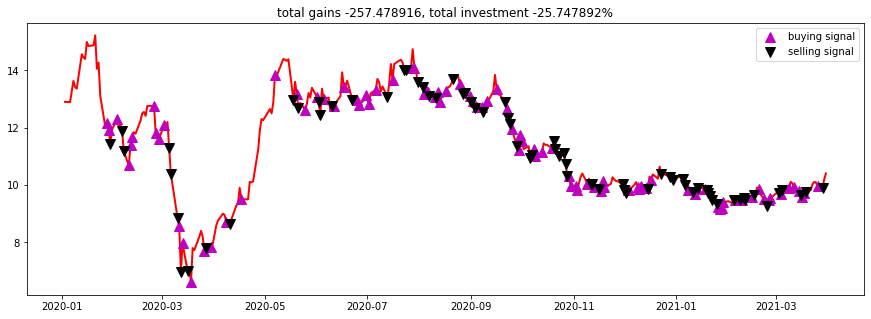

In [233]:
# Plot the results

plot_signals(values = BEEF_predictions)

#### P Stock

##### Actual Values

In [234]:
# Define the values for the S Stock

close = P_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 46.400000.3, cost: 0.037913, total money: 782.200000
epoch: 20, total rewards: 54.650000.3, cost: 0.030489, total money: 790.450000
epoch: 30, total rewards: 33.500000.3, cost: 0.024252, total money: 945.500000
epoch: 40, total rewards: 30.400000.3, cost: 0.022644, total money: 942.400000
epoch: 50, total rewards: 11.350000.3, cost: 0.022690, total money: 923.350000
epoch: 60, total rewards: 5.450000.3, cost: 0.021515, total money: 917.450000
epoch: 70, total rewards: 0.350000.3, cost: 0.020665, total money: 912.350000
epoch: 80, total rewards: 7.300000.3, cost: 0.017864, total money: 919.300000
epoch: 90, total rewards: -0.950000.3, cost: 0.015858, total money: 999.050000
epoch: 100, total rewards: 5.150000.3, cost: 0.009434, total money: 1005.150000


In [235]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 11: buy 1 unit at price 46.900000, total balance 953.100000
day 12, sell 1 unit at price 48.450000, investment 3.304904 %, total balance 1001.550000,
day 43: buy 1 unit at price 43.650000, total balance 957.900000
day 47, sell 1 unit at price 37.200000, investment -14.776632 %, total balance 995.100000,
day 63: buy 1 unit at price 39.100000, total balance 956.000000
day 64, sell 1 unit at price 38.700000, investment -1.023018 %, total balance 994.700000,
day 71: buy 1 unit at price 43.550000, total balance 951.150000
day 72, sell 1 unit at price 41.550000, investment -4.592423 %, total balance 992.700000,
day 73: buy 1 unit at price 42.400000, total balance 950.300000
day 74, sell 1 unit at price 42.800000, investment 0.943396 %, total balance 993.100000,
day 77: buy 1 unit at price 42.300000, total balance 950.800000
day 81, sell 1 unit at price 45.700000, investment 8.037825 %, total balance 996.500000,
day 82: buy 1 unit at price 45.250000, total balance 951.250000
day 88: buy 1

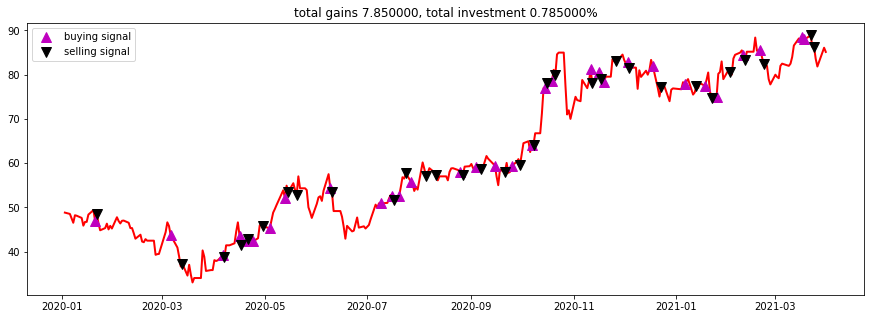

In [236]:
# Plot the results

plot_signals(values = P_actual)

##### Predicted Values

In [237]:
# Define the values for the S Stock

close = P_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 508.993946.3, cost: 0.295911, total money: 116.182741
epoch: 20, total rewards: 377.571202.3, cost: 0.245217, total money: 122.637759
epoch: 30, total rewards: 338.871202.3, cost: 0.242212, total money: 167.747670
epoch: 40, total rewards: 333.271701.3, cost: 0.229338, total money: 168.527094
epoch: 50, total rewards: 280.471202.3, cost: 0.214454, total money: 105.946104
epoch: 60, total rewards: 335.642249.3, cost: 0.214644, total money: 83.645922
epoch: 70, total rewards: 378.321114.3, cost: 0.152612, total money: 104.179865
epoch: 80, total rewards: 375.385030.3, cost: 0.149563, total money: 103.727559
epoch: 90, total rewards: 343.136709.3, cost: 0.143745, total money: 150.816589
epoch: 100, total rewards: 374.514223.3, cost: 0.118655, total money: 267.797260


In [238]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 48.500000, total balance 951.500000
day 2: buy 1 unit at price 46.500000, total balance 905.000000
day 7: buy 1 unit at price 46.700000, total balance 858.300000
day 8, sell 1 unit at price 46.700000, investment -3.711340 %, total balance 905.000000,
day 11: buy 1 unit at price 46.900000, total balance 858.100000
day 12: buy 1 unit at price 48.450000, total balance 809.650000
day 14: buy 1 unit at price 44.800000, total balance 764.850000
day 15, sell 1 unit at price 45.300000, investment -2.580645 %, total balance 810.150000,
day 22: buy 1 unit at price 46.350000, total balance 763.800000
day 24: buy 1 unit at price 47.000000, total balance 716.800000
day 27: buy 1 unit at price 45.300000, total balance 671.500000
day 29, sell 1 unit at price 42.900000, investment -8.137045 %, total balance 714.400000,
day 30, sell 1 unit at price 43.800000, investment -6.609808 %, total balance 758.200000,
day 33, sell 1 unit at price 42.800000, investment -11.661507 %, tot

day 227: buy 1 unit at price 84.550000, total balance 262.450000
day 229: buy 1 unit at price 82.500000, total balance 179.950000
day 231: buy 1 unit at price 81.600000, total balance 98.350000
day 233, sell 1 unit at price 81.600000, investment -3.546099 %, total balance 179.950000,
day 234: buy 1 unit at price 76.800000, total balance 103.150000
day 239: buy 1 unit at price 81.000000, total balance 22.150000
day 240, sell 1 unit at price 83.350000, investment -1.941176 %, total balance 105.500000,
day 241: buy 1 unit at price 82.000000, total balance 23.500000
day 244, sell 1 unit at price 77.300000, investment -9.058824 %, total balance 100.800000,
day 248: buy 1 unit at price 76.600000, total balance 24.200000
day 249, sell 1 unit at price 76.900000, investment 8.309859 %, total balance 101.100000,
day 252: buy 1 unit at price 77.573046, total balance 23.526954
day 253, sell 1 unit at price 78.094307, investment 5.532847 %, total balance 101.621261,
day 254, sell 1 unit at price 78

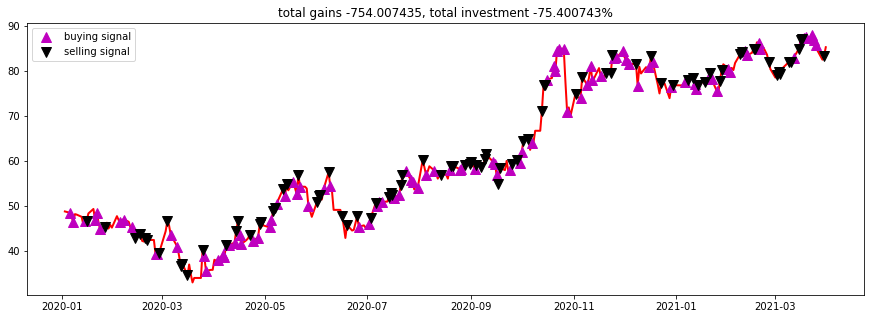

In [239]:
# Plot the results

plot_signals(values = P_predictions)

#### C Stock

##### Actual Values

In [240]:
# Different variables for this stock (May vary depending on the stock)
initial_money = 10000

# Define the values for the S Stock

close = C_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -1936.000000.3, cost: 0.300877, total money: 8064.000000
epoch: 20, total rewards: -1354.000000.3, cost: 0.137662, total money: 8646.000000
epoch: 30, total rewards: -1228.000000.3, cost: 0.084233, total money: 8772.000000
epoch: 40, total rewards: -1338.000000.3, cost: 0.045735, total money: 8662.000000
epoch: 50, total rewards: -1273.000000.3, cost: 0.035643, total money: 8727.000000
epoch: 60, total rewards: 320.000000.3, cost: 0.049082, total money: 10320.000000
epoch: 70, total rewards: -1470.000000.3, cost: 0.021953, total money: 8530.000000
epoch: 80, total rewards: -1410.000000.3, cost: 0.017444, total money: 8590.000000
epoch: 90, total rewards: -1110.000000.3, cost: 0.017128, total money: 8890.000000
epoch: 100, total rewards: -790.000000.3, cost: 0.011390, total money: 9210.000000


In [241]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 16: buy 1 unit at price 6470.000000, total balance 3530.000000
day 17, sell 1 unit at price 6580.000000, investment 1.700155 %, total balance 10110.000000,
day 33: buy 1 unit at price 6060.000000, total balance 4050.000000
day 34, sell 1 unit at price 5800.000000, investment -4.290429 %, total balance 9850.000000,
day 46: buy 1 unit at price 4000.000000, total balance 5850.000000
day 48, sell 1 unit at price 3040.000000, investment -24.000000 %, total balance 8890.000000,
day 65: buy 1 unit at price 3905.000000, total balance 4985.000000
day 67, sell 1 unit at price 3905.000000, investment 0.000000 %, total balance 8890.000000,
day 75: buy 1 unit at price 3680.000000, total balance 5210.000000
day 76: buy 1 unit at price 3800.000000, total balance 1410.000000
day 77, sell 1 unit at price 3700.000000, investment 0.543478 %, total balance 5110.000000,
day 78, sell 1 unit at price 3700.000000, investment -2.631579 %, total balance 8810.000000,
day 101: buy 1 unit at price 3600.000000,

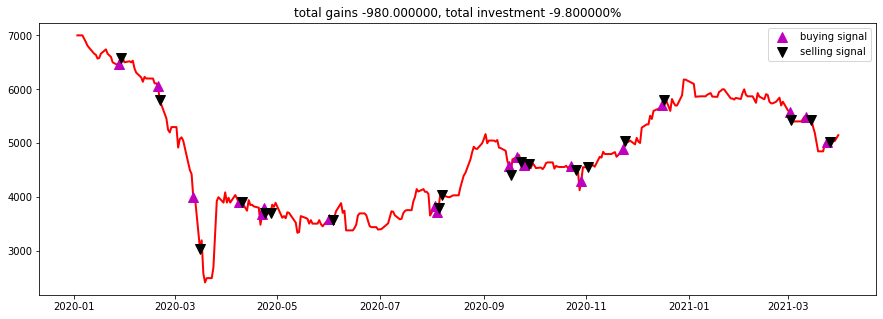

In [242]:
# Plot the results

plot_signals(values = C_actual)

##### Predicted Values

In [243]:
# Define the values for the S Stock

close = C_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -449.002400.3, cost: 0.243424, total money: 4636.561902
epoch: 20, total rewards: -421.025190.3, cost: 0.226450, total money: 4664.539113
epoch: 30, total rewards: -1008.039061.3, cost: 0.102810, total money: 4077.525242
epoch: 40, total rewards: -35.102543.3, cost: 0.116965, total money: 12.592307
epoch: 50, total rewards: -571.865187.3, cost: 0.059660, total money: 4513.699116
epoch: 60, total rewards: -2001.401775.3, cost: 0.062263, total money: 3084.162528
epoch: 70, total rewards: -1872.401775.3, cost: 0.055097, total money: 3213.162528
epoch: 80, total rewards: -2330.706611.3, cost: 0.032075, total money: 2754.857691
epoch: 90, total rewards: -519.134357.3, cost: 0.036409, total money: 4566.429946
epoch: 100, total rewards: -1757.307613.3, cost: 0.055144, total money: 3328.256690


In [244]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 9: buy 1 unit at price 6660.000000, total balance 3340.000000
day 11, sell 1 unit at price 6660.000000, investment 0.000000 %, total balance 10000.000000,
day 13: buy 1 unit at price 6600.000000, total balance 3400.000000
day 14, sell 1 unit at price 6500.000000, investment -1.515152 %, total balance 9900.000000,
day 18: buy 1 unit at price 6580.000000, total balance 3320.000000
day 21, sell 1 unit at price 6500.000000, investment -1.215805 %, total balance 9820.000000,
day 22: buy 1 unit at price 6530.000000, total balance 3290.000000
day 25, sell 1 unit at price 6220.000000, investment -4.747320 %, total balance 9510.000000,
day 28: buy 1 unit at price 6200.000000, total balance 3310.000000
day 31, sell 1 unit at price 6110.000000, investment -1.451613 %, total balance 9420.000000,
day 39: buy 1 unit at price 5300.000000, total balance 4120.000000
day 43, sell 1 unit at price 5050.000000, investment -4.716981 %, total balance 9170.000000,
day 45: buy 1 unit at price 4430.000000, 

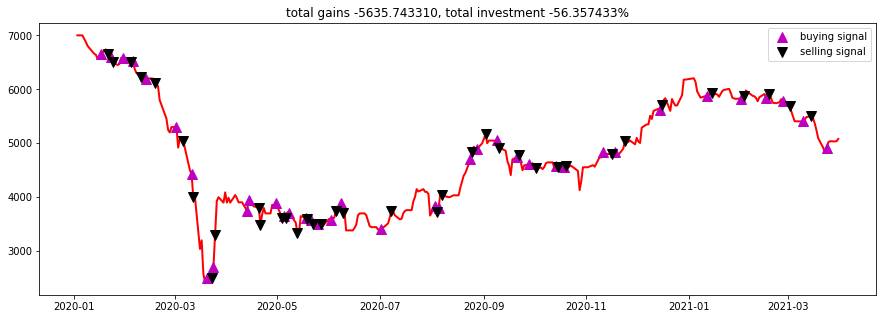

In [245]:
# Plot the results

plot_signals(values = C_predictions)

#### IP Stock

##### Actual Values

In [246]:
# Different variables for this stock (May vary depending on the stock)
initial_money = 100000

# Define the values for the S Stock

close = IP_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 9374.000000.3, cost: nan, total money: 89667.000000
epoch: 20, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 30, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 40, total rewards: 0.000000.3, cost: nan, total money: 68875.000000
epoch: 50, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 60, total rewards: 0.000000.3, cost: nan, total money: 89146.000000
epoch: 70, total rewards: 0.000000.3, cost: nan, total money: 68188.000000
epoch: 80, total rewards: 3093.000000.3, cost: nan, total money: 88793.000000
epoch: 90, total rewards: 0.000000.3, cost: nan, total money: 84349.000000
epoch: 100, total rewards: 0.000000.3, cost: nan, total money: 100000.000000


In [247]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

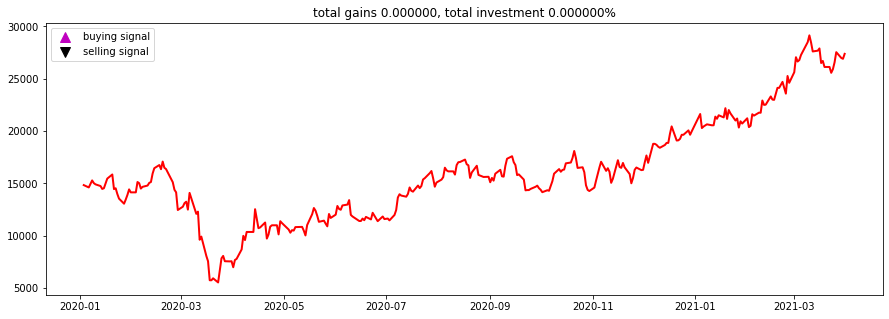

In [248]:
# Plot the results

plot_signals(values = IP_actual)

##### Predicted Values

In [249]:
# Define the values for the S Stock

close = IP_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -719.054688.3, cost: 0.041536, total money: 99280.945312
epoch: 20, total rewards: -2432.258789.3, cost: 0.018229, total money: 97567.741211
epoch: 30, total rewards: 125.321289.3, cost: 0.019125, total money: 100125.321289
epoch: 40, total rewards: 694.535156.3, cost: 0.018489, total money: 100694.535156
epoch: 50, total rewards: -1104.262695.3, cost: 0.024918, total money: 98895.737305
epoch: 60, total rewards: -1904.464844.3, cost: 0.004872, total money: 98095.535156
epoch: 70, total rewards: -3824.968750.3, cost: 0.006440, total money: 96175.031250
epoch: 80, total rewards: -9241.000000.3, cost: 0.005047, total money: 90759.000000
epoch: 90, total rewards: -4748.000000.3, cost: 0.002994, total money: 95252.000000
epoch: 100, total rewards: -1904.696289.3, cost: 0.003758, total money: 98095.303711


In [250]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 14843.000000, total balance 85157.000000
day 3, sell 1 unit at price 15031.000000, investment 1.266590 %, total balance 100188.000000,
day 7: buy 1 unit at price 14542.000000, total balance 85646.000000
day 8, sell 1 unit at price 14994.000000, investment 3.108238 %, total balance 100640.000000,
day 15: buy 1 unit at price 13068.000000, total balance 87572.000000
day 18, sell 1 unit at price 14434.000000, investment 10.453015 %, total balance 102006.000000,
day 21: buy 1 unit at price 15137.000000, total balance 86869.000000
day 22, sell 1 unit at price 15025.000000, investment -0.739909 %, total balance 101894.000000,
day 24: buy 1 unit at price 14675.000000, total balance 87219.000000
day 26, sell 1 unit at price 15055.000000, investment 2.589438 %, total balance 102274.000000,
day 32: buy 1 unit at price 17090.000000, total balance 85184.000000
day 34: buy 1 unit at price 16373.000000, total balance 68811.000000
day 35, sell 1 unit at price 15120.000000, i

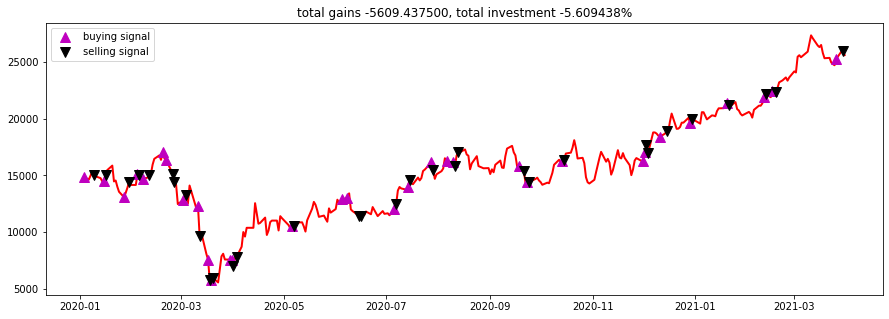

In [251]:
# Plot the results

plot_signals(values = IP_predictions)

#### DS Stock

##### Actual Values

In [252]:
# Define the values for the S Stock

close = DS_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 58320.000000.3, cost: 0.243491, total money: 11090.000000
epoch: 20, total rewards: 55105.000000.3, cost: 0.044113, total money: 6675.000000
epoch: 30, total rewards: 59800.000000.3, cost: 0.027055, total money: 8720.000000
epoch: 40, total rewards: 70425.000000.3, cost: 0.113219, total money: 975.000000
epoch: 50, total rewards: 60965.000000.3, cost: 0.013687, total money: 185.000000
epoch: 60, total rewards: 82460.000000.3, cost: 0.074927, total money: 52120.000000
epoch: 70, total rewards: 65415.000000.3, cost: 0.073370, total money: 4435.000000
epoch: 80, total rewards: 75715.000000.3, cost: 0.010319, total money: 1245.000000
epoch: 90, total rewards: 64110.000000.3, cost: 0.012174, total money: 2540.000000
epoch: 100, total rewards: 58130.000000.3, cost: 0.029139, total money: 150.000000


In [253]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 5430.000000, total balance 94570.000000
day 4: buy 1 unit at price 5500.000000, total balance 89070.000000
day 6: buy 1 unit at price 5510.000000, total balance 83560.000000
day 8, sell 1 unit at price 5520.000000, investment 1.657459 %, total balance 89080.000000,
day 9: buy 1 unit at price 5490.000000, total balance 83590.000000
day 10: buy 1 unit at price 5490.000000, total balance 78100.000000
day 11: buy 1 unit at price 5460.000000, total balance 72640.000000
day 12: buy 1 unit at price 5450.000000, total balance 67190.000000
day 14: buy 1 unit at price 5460.000000, total balance 61730.000000
day 15: buy 1 unit at price 5460.000000, total balance 56270.000000
day 17: buy 1 unit at price 5020.000000, total balance 51250.000000
day 18: buy 1 unit at price 4935.000000, total balance 46315.000000
day 20: buy 1 unit at price 4855.000000, total balance 41460.000000
day 22: buy 1 unit at price 4980.000000, total balance 36480.000000
day 24: buy 1 unit at price 

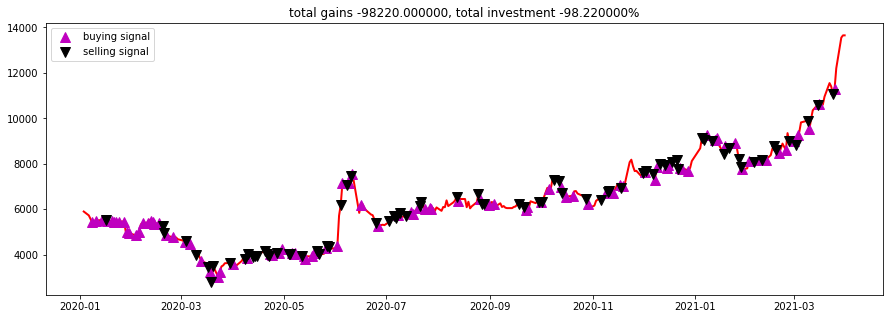

In [254]:
# Plot the results

plot_signals(values = DS_actual)

##### Predicted Values

In [255]:
# Define the values for the S Stock

close = DS_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 33087.578613.3, cost: 0.228210, total money: 6772.976807
epoch: 20, total rewards: 23019.105469.3, cost: 0.079975, total money: 5602.765869
epoch: 30, total rewards: 30710.644531.3, cost: 0.025924, total money: 10970.421143
epoch: 40, total rewards: 42722.490723.3, cost: 0.106796, total money: 32475.773682
epoch: 50, total rewards: 49703.213623.3, cost: 0.016118, total money: 24601.063232
epoch: 60, total rewards: 39553.375244.3, cost: 4.057770, total money: 139553.375244
epoch: 70, total rewards: 50894.854980.3, cost: 0.009371, total money: 8403.071045
epoch: 80, total rewards: 57330.702148.3, cost: 0.015341, total money: 26726.040771
epoch: 90, total rewards: 55249.067383.3, cost: 0.012104, total money: 25952.513428
epoch: 100, total rewards: 6005.222656.3, cost: 0.010322, total money: 7181.188721


In [256]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 9: buy 1 unit at price 5490.000000, total balance 94510.000000
day 11: buy 1 unit at price 5460.000000, total balance 89050.000000
day 12: buy 1 unit at price 5450.000000, total balance 83600.000000
day 14: buy 1 unit at price 5460.000000, total balance 78140.000000
day 17, sell 1 unit at price 5020.000000, investment -8.561020 %, total balance 83160.000000,
day 20, sell 1 unit at price 4855.000000, investment -11.080586 %, total balance 88015.000000,
day 21, sell 1 unit at price 4905.000000, investment -10.000000 %, total balance 92920.000000,
day 22, sell 1 unit at price 4980.000000, investment -8.791209 %, total balance 97900.000000,
day 23: buy 1 unit at price 5330.000000, total balance 92570.000000
day 24, sell 1 unit at price 5400.000000, investment 1.313321 %, total balance 97970.000000,
day 25: buy 1 unit at price 5410.000000, total balance 92560.000000
day 26: buy 1 unit at price 5540.000000, total balance 87020.000000
day 27: buy 1 unit at price 5500.000000, total balance

day 232, sell 1 unit at price 7560.000000, investment 14.719272 %, total balance 74990.000000,
day 234: buy 1 unit at price 7870.000000, total balance 67120.000000
day 236: buy 1 unit at price 7970.000000, total balance 59150.000000
day 237, sell 1 unit at price 7940.000000, investment 28.896104 %, total balance 67090.000000,
day 240, sell 1 unit at price 8050.000000, investment 18.556701 %, total balance 75140.000000,
day 241, sell 1 unit at price 8100.000000, investment 20.000000 %, total balance 83240.000000,
day 242: buy 1 unit at price 8180.000000, total balance 75060.000000
day 243, sell 1 unit at price 7780.000000, investment 16.119403 %, total balance 82840.000000,
day 244, sell 1 unit at price 7820.000000, investment 9.831461 %, total balance 90660.000000,
day 245: buy 1 unit at price 7790.000000, total balance 82870.000000
day 246: buy 1 unit at price 7790.000000, total balance 75080.000000
day 247, sell 1 unit at price 7700.000000, investment -4.584882 %, total balance 82780

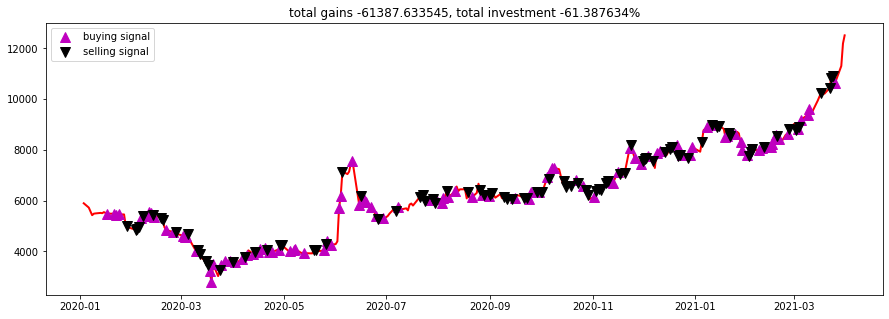

In [257]:
# Plot the results

plot_signals(values = DS_predictions)

## Approach

1. Get the historical data of the stock prices
2. Preprocess the data. Apply MinMax Scaler, re arrange the data and use the 5 days prior as independant variables and the day ahead as the dependant variable and make sure to use the correct dimensions for the data, and after applying the MinMax Scaler, prevent data leakeage by just fitting the train data
3. To foreast values, we are going to to use LSTM to see the general trend. As a note, depending on the days of data and the number of days used as independant features, we may be able to forecast prices with a longer period.
4. To calculate the next day forecast, we are using arima model (This won't work for long forecasting periods as it would capture the general trend).
5. To calculate the overal performance of both, we are using the bollinger bands and each indicator would give buy-sell signals.
6. We are calculating the weighted average between the arima model and the LSTM model.
7. We are using reinforcement learnings to check the overal buy and sell recommendations based on the forecast made with the LSTM and compare the results with the actual results. For the reinforcement learning you should input a sufficient initial investment to cover one stock price

## Other Stocks

### BRF SA

In [258]:
# Create a function that reads the data from yahoo finance
def stock_data(ticker, data_source, start, end):
    df = DataReader(ticker, data_source, start, end)['Adj Close']
    df = df.to_frame(ticker) 
    return df

In [259]:
def feature_engineering(train_array, test_array, time_steps):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    
    data = np.append(X, y).reshape(-1,1)
    
    dataX, dataY = [], []
    
    for i in range(len(data)-time_steps-1):
        c = data[i:(i+time_steps), 0]   
        dataX.append(c)
        dataY.append(data[i + time_steps, 0])
        
    # Divide one again into train and test data

    X_train = np.array(dataX[:len(train_array)- time_steps - 1])
    y_train = np.array(dataY[:len(train_array)- time_steps - 1])

    X_test = np.array(dataX[len(train_array)- time_steps - 1:])
    y_test = np.array(dataY[len(train_array)- time_steps -1:])
    
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
        
    return X_train, y_train, X_test, y_test

In [260]:
def weighted_predictions(stock, lstm_predictions, arima_predictions):
    outcome = (lstm_predictions*0.5) + (arima_predictions*0.5)
    df = pd.DataFrame()
    df['Date'] = stock['2021'].index
    df.set_index('Date', inplace = True)
    df['Price'] = outcome
    df.columns = stock.columns
    return df
    

In [261]:
#Define variables of data source, start and end date

start = datetime.date(2020,1,1)
end = datetime.date(2021,3,31)
source = 'yahoo'

In [262]:
# Get BRFS stock data

brfs_stock = stock_data('BRFS3.SA', source, start, end)

In [263]:
# Train and test data set

brfs_train = brfs_stock['2020'].values

brfs_test = brfs_stock['2021'].values

In [264]:
# Apply feature engineering

brfs_xtrain, brfs_ytrain, brfs_xtest, brfs_ytest = feature_engineering(train_array = brfs_train, 
                                                                       test_array = brfs_test, time_steps = 5)

In [265]:
# Define the neural network model

model = neural_network()

In [266]:
# Use the function to predict

brfs_pred = model_fit(Xtr = brfs_xtrain, ytr = brfs_ytrain, Xte = brfs_xtest)

Train on 241 samples
Epoch 1/100
241/241 [==============================] - 0s 435us/sample - loss: 0.1489
Epoch 2/100
241/241 [==============================] - 0s 382us/sample - loss: 0.0580
Epoch 3/100
241/241 [==============================] - 0s 528us/sample - loss: 0.0318
Epoch 4/100
241/241 [==============================] - 0s 458us/sample - loss: 0.0199
Epoch 5/100
241/241 [==============================] - 0s 353us/sample - loss: 0.0163
Epoch 6/100
241/241 [==============================] - 0s 452us/sample - loss: 0.0110
Epoch 7/100
241/241 [==============================] - 0s 388us/sample - loss: 0.0074
Epoch 8/100
241/241 [==============================] - 0s 405us/sample - loss: 0.0068
Epoch 9/100
241/241 [==============================] - 0s 378us/sample - loss: 0.0054
Epoch 10/100
241/241 [==============================] - 0s 389us/sample - loss: 0.0064
Epoch 11/100
241/241 [==============================] - 0s 483us/sample - loss: 0.0056
Epoch 12/100
241/241 [=========

241/241 [==============================] - 0s 410us/sample - loss: 0.0039
Epoch 96/100
241/241 [==============================] - 0s 416us/sample - loss: 0.0040
Epoch 97/100
241/241 [==============================] - 0s 415us/sample - loss: 0.0041
Epoch 98/100
241/241 [==============================] - 0s 556us/sample - loss: 0.0047
Epoch 99/100
241/241 [==============================] - 0s 405us/sample - loss: 0.0039
Epoch 100/100
241/241 [==============================] - 0s 414us/sample - loss: 0.0042


In [267]:
# Use the inverse transform function

brfs_pred = scaler_inverse(train_array = brfs_stock.values, predictions = brfs_pred)

brfs_pred = brfs_pred.reshape(brfs_pred.shape[0])


In [268]:
# Run the arima function

arima_selection(values = brfs_stock)

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  306
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -343.059
 Date:                Mon, 21 Jun 2021   AIC                            688.118
 Time:                        19:38:16   BIC                            691.839
 Sample:                             0   HQIC                           689.606
                                 - 306                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.5553    

In [269]:
# Get the best order for the stock

brfs_pred_arima = model_fit_arima(df = brfs_stock, col = 'BRFS3.SA', order = (0,1,0))

In [270]:
# Weighted average to do the predictions

brfs_pred = weighted_predictions(stock = brfs_stock, lstm_predictions = brfs_pred, 
                                 arima_predictions = brfs_pred_arima)

In [271]:
# Append data frames

brfs_stock_pred = brfs_stock['2020'].append(brfs_pred)

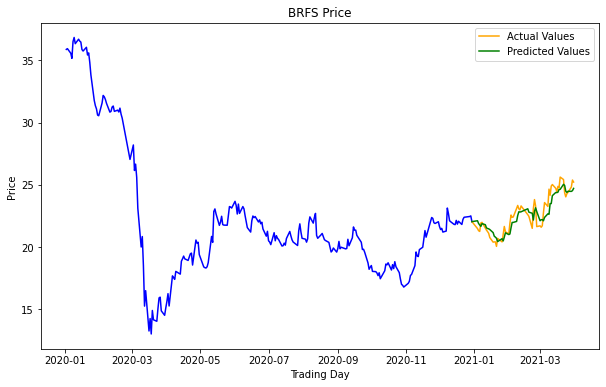

In [272]:
# Plot the graphic

plot_comparison(actual = brfs_stock, predicted = brfs_stock_pred, string = 'BRFS Price')

In [273]:
# Save the predictions and the train in the same data frame

df_brfs_pred = brfs_stock['2020'].append(brfs_pred)

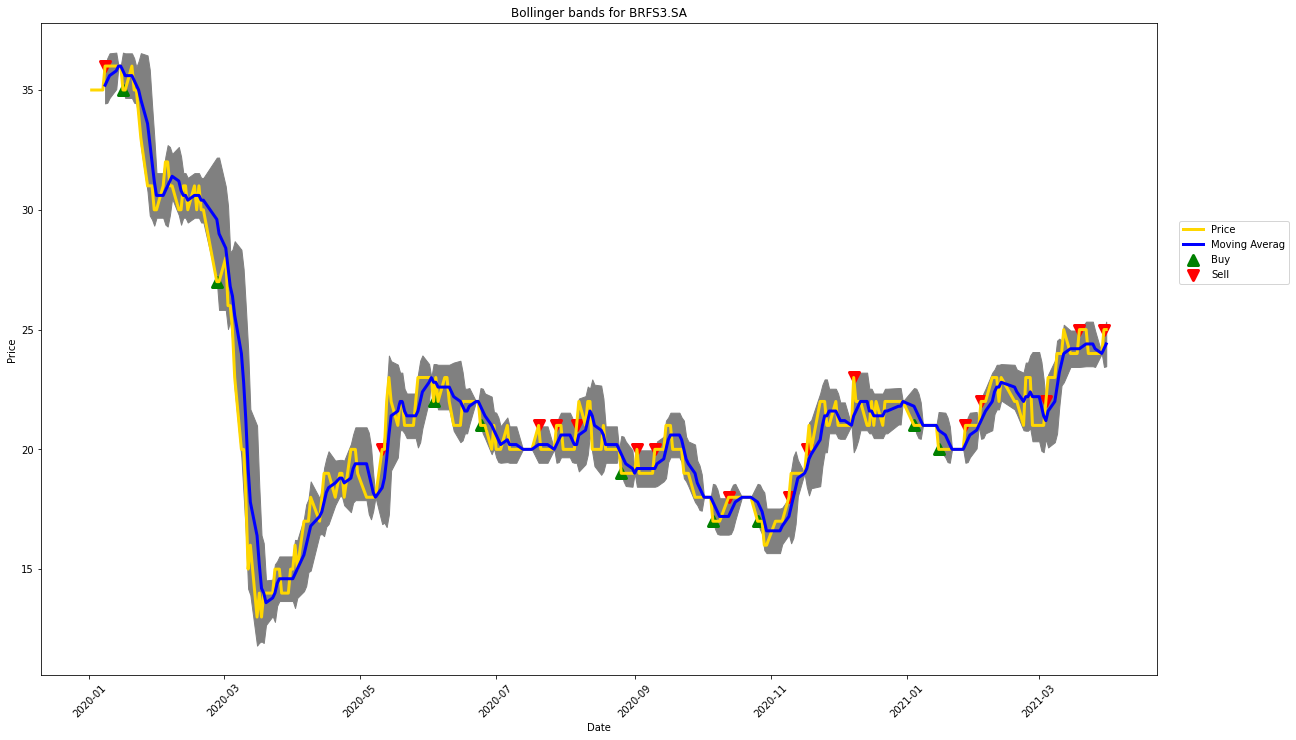

In [274]:
# Bollinger bands for the actual data daily

bollinger_bands(df = brfs_stock, col = 'BRFS3.SA' , p = 5, std = 1.7)

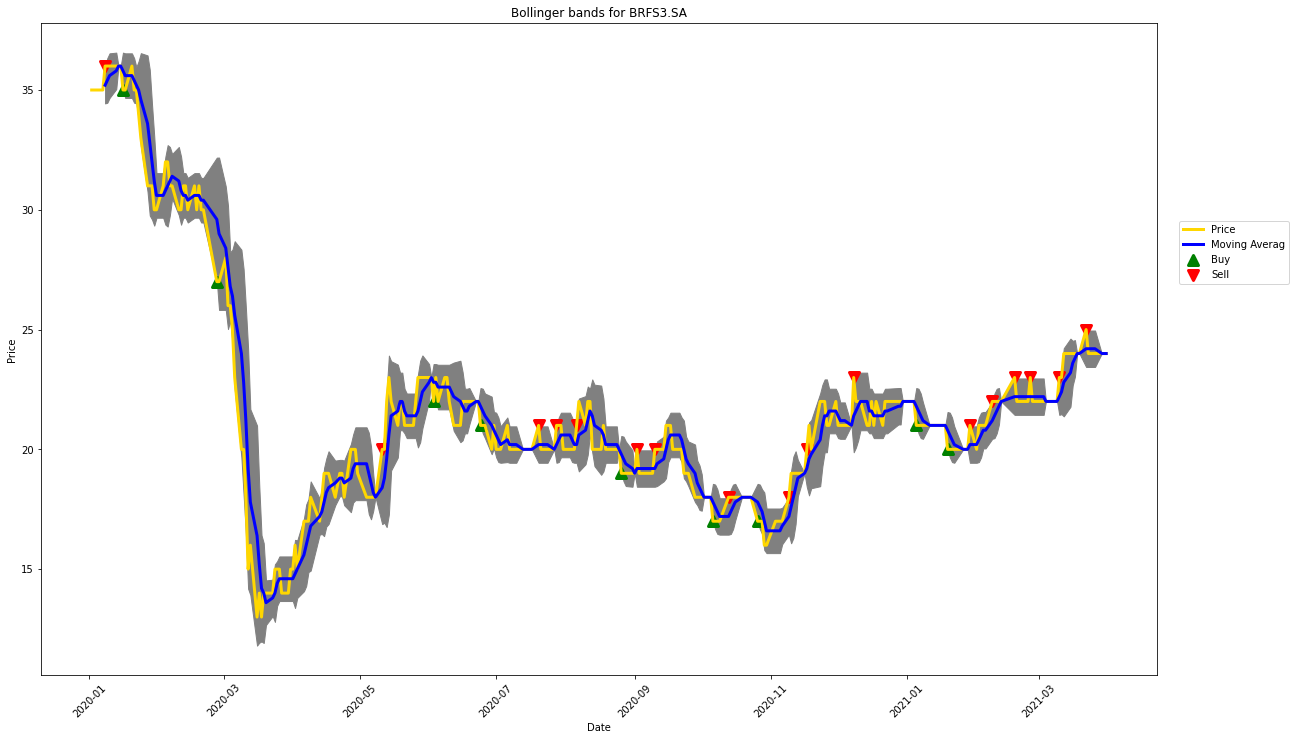

In [275]:
# Bollinger bands for the predicted data daily

bollinger_bands(df = df_brfs_pred, col = 'BRFS3.SA' , p = 5, std = 1.7)

In [276]:
# Define the values for the S Stock

initial_money = 1000

close = df_brfs_pred['BRFS3.SA'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [277]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -100.039001.3, cost: 0.305088, total money: 80.193297
epoch: 20, total rewards: -80.867162.3, cost: 0.211435, total money: 230.303576
epoch: 30, total rewards: -98.402302.3, cost: 0.206718, total money: 228.843295
epoch: 40, total rewards: -80.882174.3, cost: 0.157373, total money: 320.313423
epoch: 50, total rewards: -64.934298.3, cost: 0.054174, total money: 626.464725
epoch: 60, total rewards: -48.596591.3, cost: 0.062771, total money: 599.469986
epoch: 70, total rewards: -64.079000.3, cost: 0.053007, total money: 605.780921
epoch: 80, total rewards: -53.893351.3, cost: 0.060534, total money: 571.245254
epoch: 90, total rewards: -54.591722.3, cost: 0.024543, total money: 721.031947
epoch: 100, total rewards: -61.950667.3, cost: 0.025144, total money: 689.193657


In [278]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 35.570000, total balance 964.430000
day 3: buy 1 unit at price 35.160000, total balance 929.270000
day 4, sell 1 unit at price 36.509998, investment 2.642673 %, total balance 965.779999,
day 6: buy 1 unit at price 36.340000, total balance 929.439999
day 7, sell 1 unit at price 36.700001, investment 4.379980 %, total balance 966.139999,
day 10: buy 1 unit at price 35.869999, total balance 930.270000
day 12: buy 1 unit at price 36.049999, total balance 894.220001
day 13: buy 1 unit at price 35.430000, total balance 858.790001
day 14, sell 1 unit at price 35.599998, investment -2.036328 %, total balance 894.389999,
day 15: buy 1 unit at price 34.840000, total balance 859.549999
day 17: buy 1 unit at price 31.780001, total balance 827.769999
day 20: buy 1 unit at price 30.600000, total balance 797.169998
day 21: buy 1 unit at price 30.549999, total balance 766.619999
day 22: buy 1 unit at price 31.570000, total balance 735.049999
day 23: buy 1 unit at price 32.18

day 207: buy 1 unit at price 16.780001, total balance 493.660006
day 208: buy 1 unit at price 17.080000, total balance 476.580006
day 209: buy 1 unit at price 17.240000, total balance 459.340006
day 210: buy 1 unit at price 17.709999, total balance 441.630007
day 211, sell 1 unit at price 17.799999, investment -13.843178 %, total balance 459.430006,
day 212, sell 1 unit at price 18.500000, investment -15.563669 %, total balance 477.930006,
day 213, sell 1 unit at price 19.600000, investment -6.354515 %, total balance 497.530006,
day 216, sell 1 unit at price 19.790001, investment -4.992794 %, total balance 517.320007,
day 218, sell 1 unit at price 20.680000, investment 0.437106 %, total balance 538.000008,
day 219, sell 1 unit at price 21.320000, investment 6.599998 %, total balance 559.320007,
day 221, sell 1 unit at price 22.030001, investment 12.397960 %, total balance 581.350008,
day 224, sell 1 unit at price 21.950001, investment 10.190766 %, total balance 603.300009,
day 226: buy

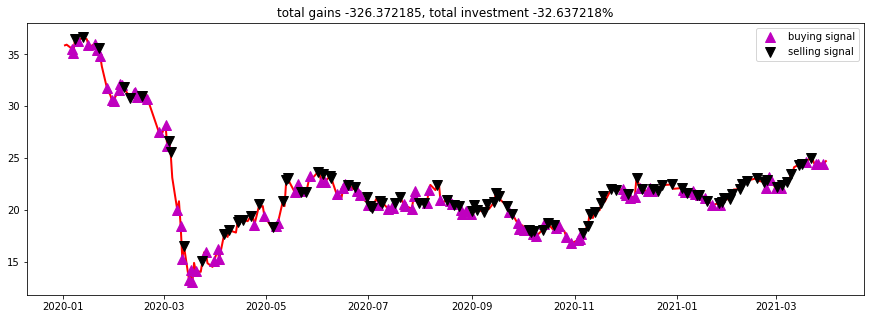

In [279]:
# Plot the results

plot_signals(values = df_brfs_pred['BRFS3.SA'])

### Anglo American Platinum Limited

In [280]:
# Get BRFS stock data

angpy_stock = stock_data('ANGPY', source, start, end)

In [281]:
# Train and test data set

angpy_train = angpy_stock['2020'].values

angpy_test = angpy_stock['2021'].values

In [282]:
# Apply feature engineering

angpy_xtrain, angpy_ytrain, angpy_xtest, angpy_ytest = feature_engineering(train_array = angpy_train, 
                                                                       test_array = angpy_test, time_steps = 5)

In [283]:
# Define the neural network model

model = neural_network()

In [284]:
# Use the function to predict

angpy_pred = model_fit(Xtr = angpy_xtrain, ytr = angpy_ytrain, Xte = angpy_xtest)

Train on 247 samples
Epoch 1/100
247/247 [==============================] - 0s 366us/sample - loss: 0.3440
Epoch 2/100
247/247 [==============================] - 0s 382us/sample - loss: 0.1163
Epoch 3/100
247/247 [==============================] - 0s 511us/sample - loss: 0.0447
Epoch 4/100
247/247 [==============================] - 0s 684us/sample - loss: 0.0225
Epoch 5/100
247/247 [==============================] - 0s 445us/sample - loss: 0.0237
Epoch 6/100
247/247 [==============================] - 0s 467us/sample - loss: 0.0175
Epoch 7/100
247/247 [==============================] - 0s 432us/sample - loss: 0.0153
Epoch 8/100
247/247 [==============================] - 0s 444us/sample - loss: 0.0154
Epoch 9/100
247/247 [==============================] - 0s 374us/sample - loss: 0.0150
Epoch 10/100
247/247 [==============================] - 0s 388us/sample - loss: 0.0127
Epoch 11/100
247/247 [==============================] - 0s 448us/sample - loss: 0.0133
Epoch 12/100
247/247 [=========

247/247 [==============================] - 0s 464us/sample - loss: 0.0086
Epoch 95/100
247/247 [==============================] - 0s 452us/sample - loss: 0.0092
Epoch 96/100
247/247 [==============================] - 0s 479us/sample - loss: 0.0080
Epoch 97/100
247/247 [==============================] - 0s 473us/sample - loss: 0.0088
Epoch 98/100
247/247 [==============================] - 0s 480us/sample - loss: 0.0083
Epoch 99/100
247/247 [==============================] - 0s 426us/sample - loss: 0.0074
Epoch 100/100
247/247 [==============================] - 0s 411us/sample - loss: 0.0097


In [285]:
# Use the inverse transform function

angpy_pred = scaler_inverse(train_array = angpy_stock.values, predictions = angpy_pred)

angpy_pred = angpy_pred.reshape(angpy_pred.shape[0])


In [286]:
# Run the arima function

arima_selection(values = angpy_stock)

(ARIMA(order=(1, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  314
 Model:               SARIMAX(1, 2, 1)   Log Likelihood                -244.031
 Date:                Mon, 21 Jun 2021   AIC                            494.062
 Time:                        19:39:50   BIC                            505.291
 Sample:                             0   HQIC                           498.550
                                 - 314                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1         -0.0969    

In [287]:
# Get the best order for the stock

angpy_pred_arima = model_fit_arima(df = angpy_stock, col = 'ANGPY', order = (1,2,1))

In [288]:
# Weighted average to do the predictions

angpy_pred = weighted_predictions(stock = angpy_stock, lstm_predictions = angpy_pred, 
                                  arima_predictions = angpy_pred_arima)

In [289]:
# Append data frames

angpy_stock_pred = angpy_stock['2020'].append(angpy_pred)

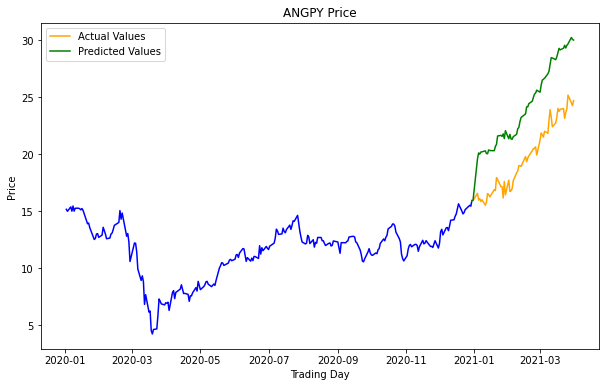

In [290]:
# Plot the graphic

plot_comparison(actual = angpy_stock, predicted = angpy_stock_pred, string = 'ANGPY Price')

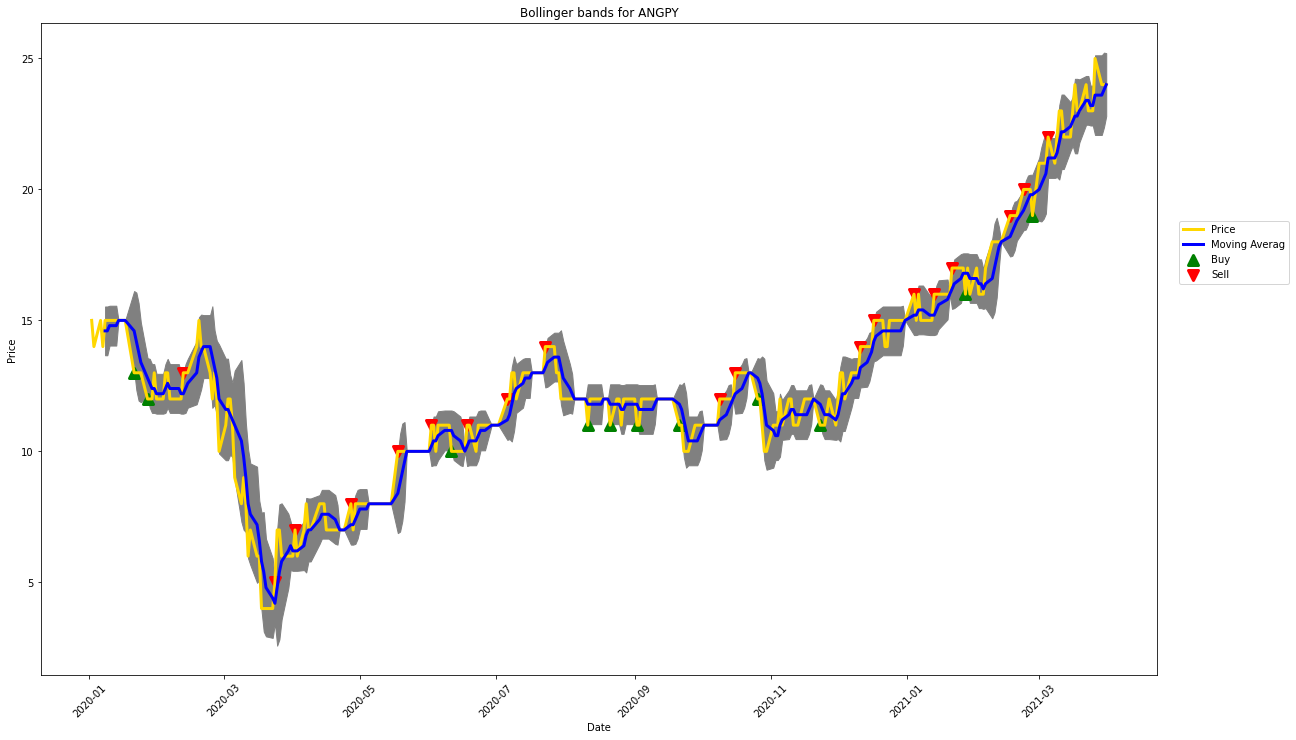

In [291]:
# Bollinger bands for the actual data daily

bollinger_bands(df = angpy_stock, col = 'ANGPY' , p = 5, std = 1.7)

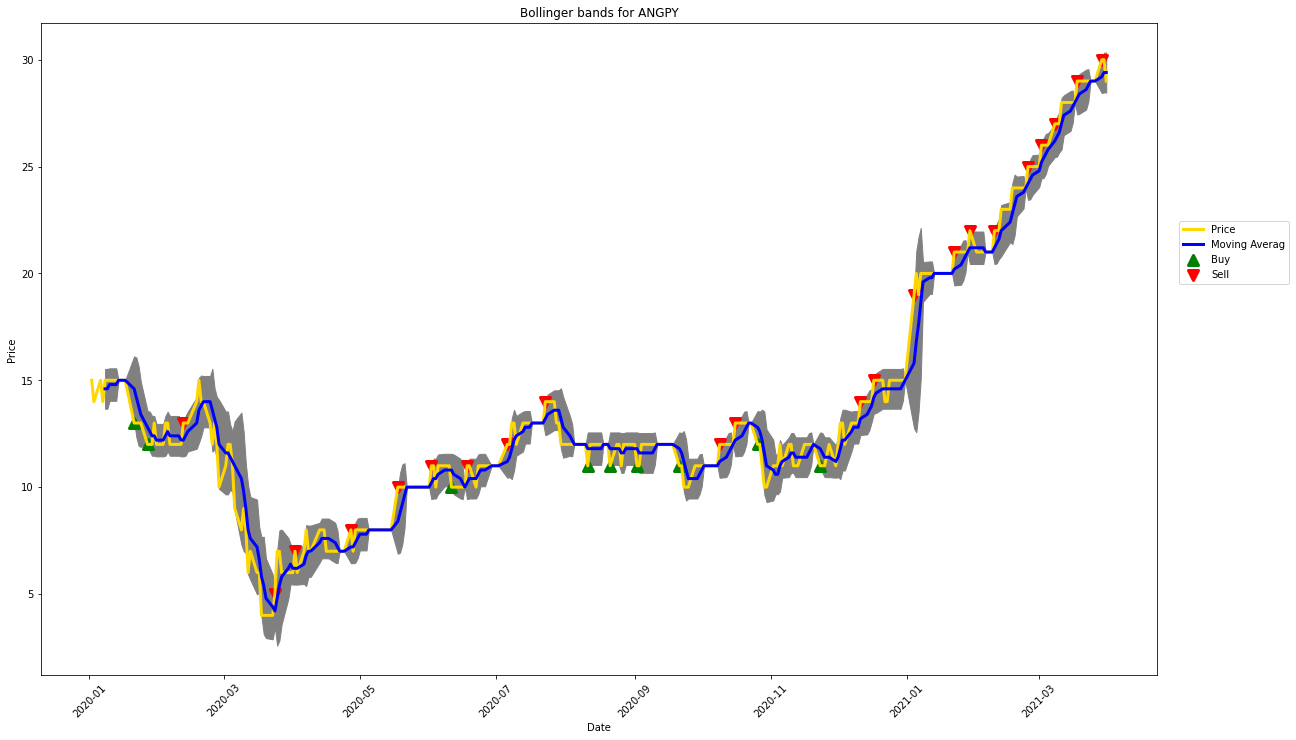

In [292]:
# Bollinger bands for the predicted data daily

bollinger_bands(df = angpy_stock_pred, col = 'ANGPY' , p = 5, std = 1.7)

In [293]:
# Define the values for the S Stock

initial_money = 1000

close = angpy_stock['ANGPY'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [294]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -1.594905.3, cost: 0.008362, total money: 998.405095
epoch: 20, total rewards: -5.175137.3, cost: 0.008364, total money: 994.824863
epoch: 30, total rewards: -1.097880.3, cost: 0.007678, total money: 998.902120
epoch: 40, total rewards: 6.090667.3, cost: 0.004525, total money: 1006.090667
epoch: 50, total rewards: 5.177834.3, cost: 0.004463, total money: 1005.177834
epoch: 60, total rewards: 4.236478.3, cost: 0.004403, total money: 1004.236478
epoch: 70, total rewards: 8.528677.3, cost: 0.004209, total money: 1008.528677
epoch: 80, total rewards: 7.128421.3, cost: 0.004167, total money: 1007.128421
epoch: 90, total rewards: 9.587557.3, cost: 0.004031, total money: 1009.587557
epoch: 100, total rewards: 6.830052.3, cost: 0.004023, total money: 1006.830052


In [295]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 15.370804, total balance 984.629196
day 3, sell 1 unit at price 14.995438, investment -2.442073 %, total balance 999.624634,
day 4: buy 1 unit at price 15.447803, total balance 984.176830
day 5, sell 1 unit at price 15.000250, investment -2.897199 %, total balance 999.177080,
day 6: buy 1 unit at price 15.252419, total balance 983.924661
day 7, sell 1 unit at price 15.255307, investment 0.018933 %, total balance 999.179968,
day 8: buy 1 unit at price 15.207183, total balance 983.972785
day 9, sell 1 unit at price 15.110934, investment -0.632916 %, total balance 999.083719,
day 11: buy 1 unit at price 15.062812, total balance 984.020907
day 12, sell 1 unit at price 13.888586, investment -7.795529 %, total balance 997.909493,
day 14: buy 1 unit at price 13.542092, total balance 984.367401
day 16, sell 1 unit at price 12.512239, investment -7.604828 %, total balance 996.879641,
day 18: buy 1 unit at price 12.993479, total balance 983.886162
day 19: buy 1 unit at

day 285, sell 1 unit at price 19.850147, investment 0.985833 %, total balance 1007.283474,
day 286: buy 1 unit at price 20.281971, total balance 987.001503
day 287, sell 1 unit at price 20.479687, investment 0.974835 %, total balance 1007.481190,
day 291: buy 1 unit at price 21.227264, total balance 986.253926
day 292, sell 1 unit at price 21.846966, investment 2.919365 %, total balance 1008.100892,
day 297: buy 1 unit at price 22.988007, total balance 985.112885
day 298, sell 1 unit at price 23.891001, investment 3.928110 %, total balance 1009.003886,
day 302: buy 1 unit at price 23.219999, total balance 985.783886
day 303: buy 1 unit at price 24.000000, total balance 961.783886
day 304, sell 1 unit at price 23.750000, investment 2.282518 %, total balance 985.533886,
day 305, sell 1 unit at price 23.920000, investment -0.333333 %, total balance 1009.453887,
day 310: buy 1 unit at price 25.170000, total balance 984.283886
day 311, sell 1 unit at price 24.500000, investment -2.661899 %,

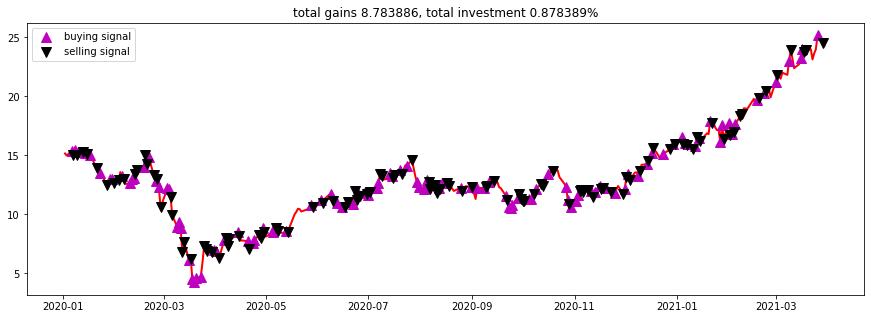

In [296]:
# Plot the results

plot_signals(values = angpy_stock['ANGPY'])

In [297]:
# Define the values for the S Stock

initial_money = 1000

close = angpy_stock_pred['ANGPY'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [298]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 113.997621.3, cost: 0.331280, total money: 8.027497
epoch: 20, total rewards: 125.300495.3, cost: 0.319870, total money: 18.627082
epoch: 30, total rewards: 98.210543.3, cost: 0.260862, total money: 8.752506
epoch: 40, total rewards: 93.992589.3, cost: 0.175964, total money: 72.949321
epoch: 50, total rewards: 94.006363.3, cost: 0.148087, total money: 128.976145
epoch: 60, total rewards: 96.071072.3, cost: 0.115262, total money: 205.181399
epoch: 70, total rewards: 120.348667.3, cost: 0.106617, total money: 256.759110
epoch: 80, total rewards: 114.953324.3, cost: 0.080338, total money: 337.081637
epoch: 90, total rewards: 116.399294.3, cost: 0.078890, total money: 338.527607
epoch: 100, total rewards: 114.334120.3, cost: 0.050580, total money: 437.578677


In [299]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 13: buy 1 unit at price 13.955959, total balance 986.044041
day 15, sell 1 unit at price 13.291848, investment -4.758620 %, total balance 999.335889,
day 16: buy 1 unit at price 12.512239, total balance 986.823649
day 17, sell 1 unit at price 12.608487, investment 0.769228 %, total balance 999.432137,
day 19: buy 1 unit at price 13.027166, total balance 986.404970
day 20: buy 1 unit at price 12.696074, total balance 973.708897
day 21: buy 1 unit at price 12.897231, total balance 960.811666
day 23: buy 1 unit at price 13.291848, total balance 947.519817
day 24: buy 1 unit at price 12.993479, total balance 934.526339
day 25, sell 1 unit at price 12.579613, investment -3.435541 %, total balance 947.105951,
day 26, sell 1 unit at price 12.637362, investment -0.462442 %, total balance 959.743313,
day 27: buy 1 unit at price 12.993479, total balance 946.749834
day 28: buy 1 unit at price 13.080102, total balance 933.669732
day 29: buy 1 unit at price 13.397720, total balance 920.272012
d

day 218, sell 1 unit at price 11.990748, investment 4.950495 %, total balance 859.284214,
day 219, sell 1 unit at price 11.479248, investment -1.973956 %, total balance 870.763463,
day 220, sell 1 unit at price 11.867791, investment 6.299550 %, total balance 882.631254,
day 222: buy 1 unit at price 12.128460, total balance 870.502794
day 223: buy 1 unit at price 12.197315, total balance 858.305479
day 225, sell 1 unit at price 12.271091, investment 8.289931 %, total balance 870.576569,
day 226, sell 1 unit at price 11.897302, investment 5.577864 %, total balance 882.473871,
day 227, sell 1 unit at price 11.912056, investment -2.101856 %, total balance 894.385927,
day 228, sell 1 unit at price 11.813691, investment -7.043342 %, total balance 906.199618,
day 229, sell 1 unit at price 12.403883, investment -7.686674 %, total balance 918.603501,
day 230, sell 1 unit at price 11.764508, investment -15.177304 %, total balance 930.368009,
day 231: buy 1 unit at price 12.172725, total balance 

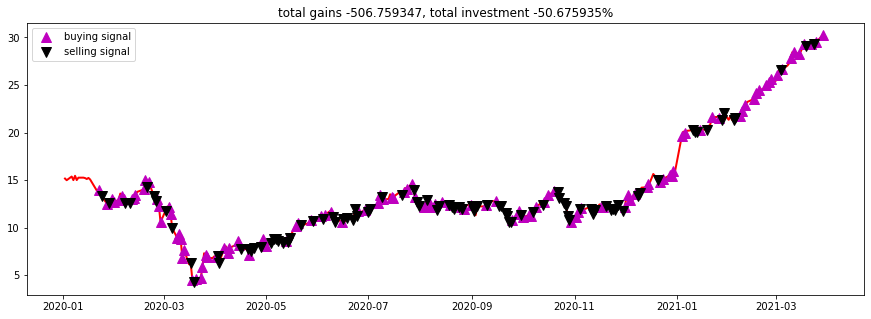

In [300]:
# Plot the results

plot_signals(values = angpy_stock_pred['ANGPY'])

##### Examples for next few days

Looks like the ARIMA model only works for the next day. For few more days, I used the LSTM 

## Forecasting

In [301]:
def feature_engineering(forecast_array, time_steps):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = forecast_array.reshape(-1,1)
    scaler = scaler.fit(a)
    data = scaler.transform(a)
    
    data = data.reshape(-1,1)
     
    dataX, dataY = [], []
    
    for i in range(len(data)-time_steps-1):
        c = data[i:(i+time_steps), 0]   
        dataX.append(c)
        dataY.append(data[i + time_steps, 0])
        
    X = np.array(dataX)
    y = np.array(dataY)
       
    X = X.reshape(X.shape[0],X.shape[1] , 1)
        
    return X, y

In [302]:
def inverse_scaler(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    scaler = scaler.fit(a)
    y_inverse = scaler.inverse_transform(predictions)
    return y_inverse
    
    

In [303]:
def forecasting_fit(Xtrain, ytrain, n_days):
    
    for i in range(n_days):
        model.fit(Xtrain, ytrain, epochs = 100, batch_size = 32, verbose = 0)
        Xtest = Xtrain[-5:]
        p = model.predictions(Xtrain[-5:])
        Xtrain = np.append(Xtrain, p)
        return Xtrain
        
        
        

In [304]:
def forecasting_model(n_days, array):
    
    for i in range(n_days):
        X, y = feature_engineering(forecast_array = array, time_steps = 5)
        model = neural_network()
        model.fit(X, y, epochs = 100, batch_size = 32, verbose = 0)
        test = X[-1]
        test_reshape = test.reshape(1, test.shape[0], 1)
        p = model.predict(test_reshape)
        p = inverse_scaler(train_array = array, predictions = p)
        array = np.append(array, p)
        
    return  array

In [305]:
def df_results(array, n_days):
    df = pd.DataFrame()
    df['Date'] = stock_prices_daily.index
    
    date = []
    
    for i in range(n_days):
        
        if i == 0:
            d = df['Date'].iloc[-1] + BDay(1)
            date.append(d)
            
        else:
            d = date[-1] + BDay(1)
            date.append(d)
            
    df2 = pd.DataFrame({'Date': date})
    
    df = df.append(df2).reset_index(drop = True)
    df.set_index('Date', inplace = True)
    
    df['Price'] = array
    
    return df
            

In [312]:
# Define a function to plot the forecasting

def plot_forecasting(df):
    plt.plot(df[:len(s_array)], color = 'blue')
    plt.plot(df[len(s_array) - 1:], color = 'green')
    plt.axvline(x = stock_prices_daily.index[-1], linestyle = '--')
    plt.xticks(rotation = 90)
    return plt.show()

### S stocks

In [307]:
# Define the neural network model

model = neural_network()

In [308]:
# Define the array

s_array = stock_prices_daily['S_Price'].values

In [309]:
# Save the predictions

s_X = forecasting_model(n_days = 5, array = s_array)

In [310]:
# Forecast the stock

s_forecast = df_results(array = s_X, n_days = 5)

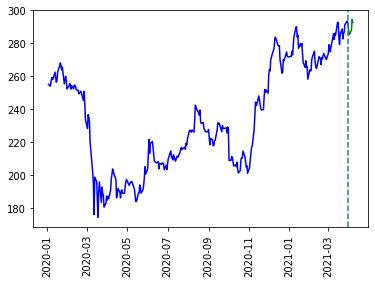

In [313]:
# Plot the predictions

plot_forecasting(df = s_forecast)

### KCHOL Stock

In [314]:
# Define the array

kchol_array = stock_prices_daily['KCHOL_Price'].values

In [315]:
# Save the predictions

kchol_X = forecasting_model(n_days = 5, array = kchol_array)

In [316]:
# Forecast the stock

kchol_forecast = df_results(array = kchol_X, n_days = 5)

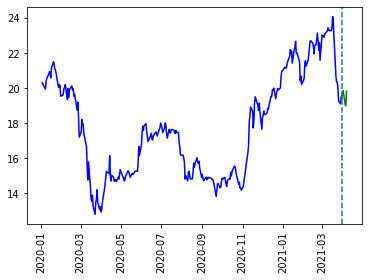

In [317]:
# Plot the predictions

plot_forecasting(df = kchol_forecast)

### M Stock

In [318]:
# Define the array

m_array = stock_prices_daily['M_Price'].values

In [319]:
# Save the predictions

m_X = forecasting_model(n_days = 5, array = m_array)

In [320]:
# Forecast the stock

m_forecast = df_results(array = m_X, n_days = 5)

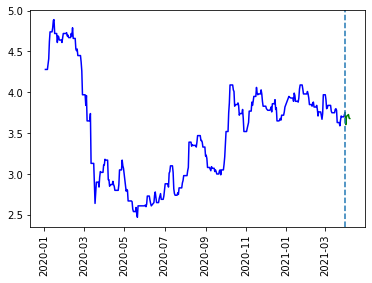

In [321]:
# Plot the predictions

plot_forecasting(df = m_forecast)

### BEEF Stock

In [322]:
# Define the array

beef_array = stock_prices_daily['BEEF_Price'].values

In [323]:
# Save the predictions

beef_X = forecasting_model(n_days = 5, array = beef_array)

In [324]:
# Forecast the stock

beef_forecast = df_results(array = beef_X, n_days = 5)

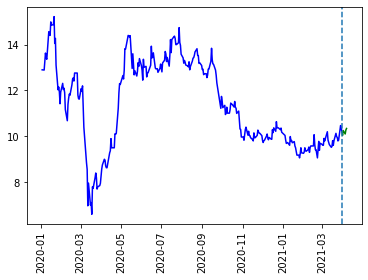

In [325]:
# Plot the predictions

plot_forecasting(df = beef_forecast)

### P Stock

In [326]:
# Define the array

p_array = stock_prices_daily['P_Price'].values

In [327]:
# Save the predictions

p_X = forecasting_model(n_days = 5, array = p_array)

In [328]:
# Forecast the stock

p_forecast = df_results(array = p_X, n_days = 5)

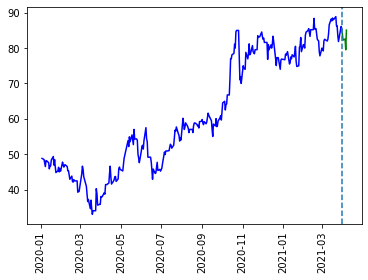

In [329]:
# Plot the predictions

plot_forecasting(df = p_forecast)

### C Stock

In [330]:
# Define the array

c_array = stock_prices_daily['C_Price'].values

In [331]:
# Save the predictions

c_X = forecasting_model(n_days = 5, array = c_array)

In [332]:
# Forecast the stock

c_forecast = df_results(array = c_X, n_days = 5)

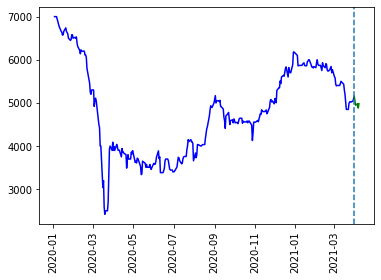

In [333]:
# Plot the predictions

plot_forecasting(df = c_forecast)

### IP Stock

In [334]:
# Define the array

ip_array = stock_prices_daily['IP_Price'].values

In [335]:
# Save the predictions

ip_X = forecasting_model(n_days = 5, array = ip_array)

In [336]:
# Forecast the stock

ip_forecast = df_results(array = ip_X, n_days = 5)

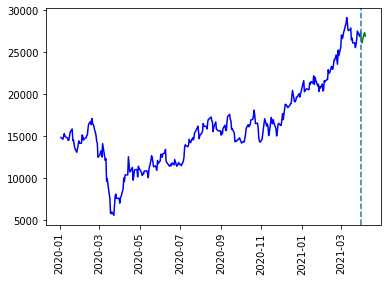

In [337]:
# Plot the predictions

plot_forecasting(df = ip_forecast)

### DS Stock

In [338]:
# Define the array

ds_array = stock_prices_daily['DS_Price'].values

In [339]:
# Save the predictions

ds_X = forecasting_model(n_days = 5, array = ds_array)

In [340]:
# Forecast the stock

ds_forecast = df_results(array = ds_X, n_days = 5)

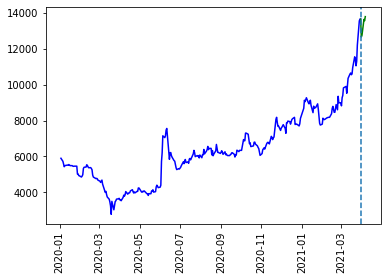

In [341]:
# Plot the predictions

plot_forecasting(df = ds_forecast)

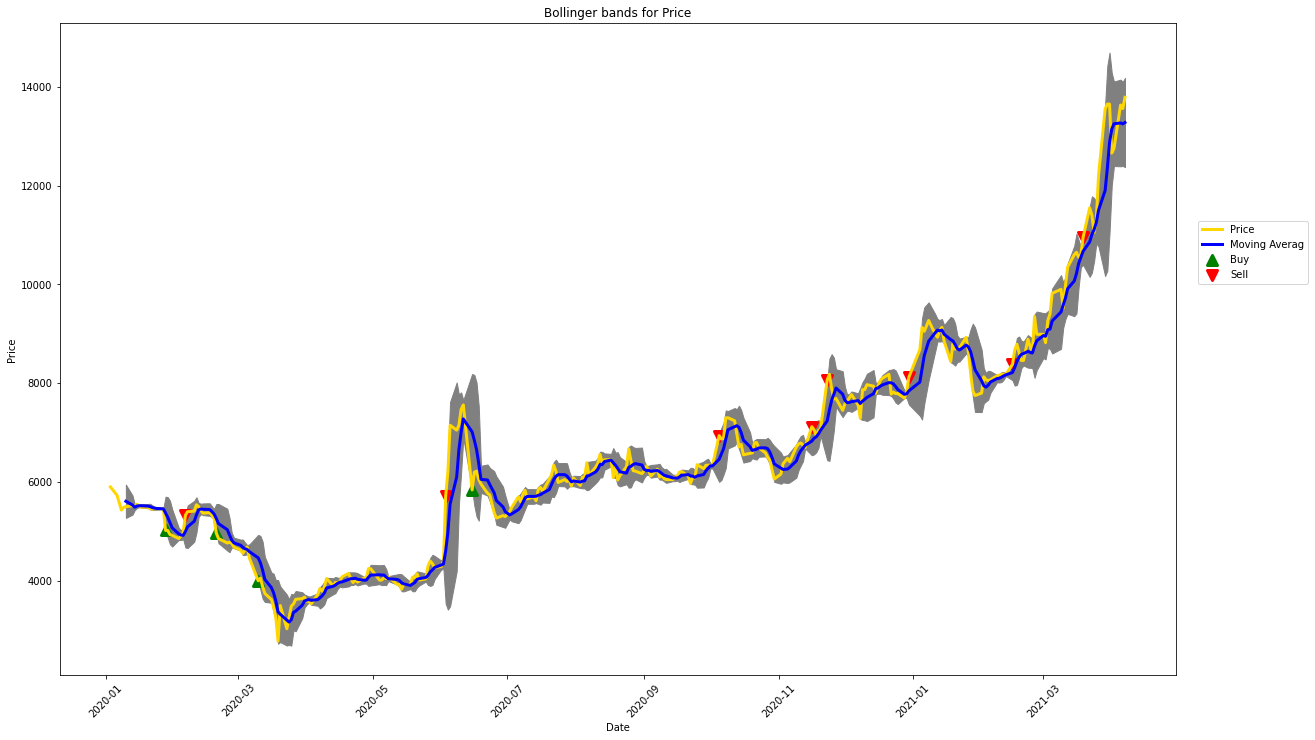

In [343]:
# Example for the bollinger band
# Just as clarification put the column name even though the data frame has only one column.

bollinger_bands(df = ds_forecast, col = 'Price', p = 5, std = 1.7)